# Clusterization

## **Introduction**

For clustering different algorithms will be done.

For mixed type of data 3 algorithms will be used:

* *PAM*,
* *Hierarchical clustering*,
* *K-prototypes*.


**PAM** algorithm proceeds in two phases:

Build phase:
1. Select k objects to become the medoids, or in case these objects were provided use them as the medoids;
2. Calculate the dissimilarity matrix if it was not provided;
3. Assign every object to its closest medoid;

Swap phase:
4. For each cluster search if any of the object of the cluster decreases the average dissimilarity coefficient; if it does, select the entity that decreases this coefficient the most as the medoid for this cluster; 5. If at least one medoid has changed go to (3), else end the algorithm.

In one sentence: PAM stands for "partition around medoids". The algorithm is intended to find
a sequence of objects called medoids that are centrally located in clusters.

(https://www.cs.umb.edu/cs738/pam1.pdf, https://www.datanovia.com/en/lessons/k-medoids-in-r-algorithm-and-practical-examples/)


**Hierarchical clustering** algorithm - algorithm that groups similar objects into clusters. The endpoint is a set of clusters, where each cluster is distinct from each other cluster, and the objects within each cluster are broadly similar to each other. 

Hierarchical clustering starts by treating each observation as a separate cluster. Then, it repeatedly executes the following two steps:  
1. identify the two clusters that are closest together, 
2. merge the two most similar clusters. This iterative process continues until all the clusters are merged together.

The main output of Hierarchical Clustering is a dendrogram, which shows the hierarchical relationship between the clusters

There are a few criteria of linkage that determine from where the distances are computed:
* *single* - it can be computed between the two most similar parts of a cluster,
* *complete* - the two least similar bits of a cluster,
* *average* - the center of the clusters,
* *Ward* - this method works out which observations to group based on reducing the sum of squared distances of each observation from the average observation in a cluster.

(https://www.displayr.com/what-is-hierarchical-clustering/)

**K-prototypes** algorithm - used to cluster large datasets with mixed numerical and categorical values. It is an advanced version of the k-means clustering algorithm for mixed data types.

K-prototype algorithm is an ensemble of K-means and K-modes clustering algorithms. It uses different distance metrics for numerical data and different distance metrics for categorical datatype. Euclidean and Manhattan distance is used for numerical data and matching_distance is used for categorical data. It was first published by Huang (1998).

(https://medium.com/@keswani-rohitkumar/k-prototypes-clustering-algorithm-f5d8e09a0104)

In [1]:
# libraries

import pandas as pd
import numpy as np
import bz2
pd.set_option('display.max_columns', None)
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pingouin as pg
import statsmodels.api as sm
import matplotlib as mpl
from scipy import stats
from distfit import distfit
import scikit_posthocs as sp
import datetime as dt

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["image.cmap"] = "Pastel2"

import plotly.graph_objects as go
from random import sample
from numpy.random import uniform
from math import isnan

from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

from scipy.spatial.distance import euclidean


/home/evida-monika/anaconda3/envs/mhunters/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# planting seed

import random

random.seed(10)

In [33]:
# importing data

df = pd.read_csv("/home/evida-monika/mhunters/final_data_4_5.csv.bz2", compression="bz2", sep=",")

# this is cleaned dataset
# we need to delete another user - ID = 235, because it has 274 sessions in 4 weeks - impossible.

df = df[df['id_users'] != 235]

In [34]:
# changing types of data

cols = ['name_en_exercises','discarded_session_execution', 'code_name_sessions', 
        'name_en_sessions', 'active_user_programs', 'completed_user_programs',
        'pro_programs', 'available_programs', 'name_en_programs', 
        'gender', 
        'activity_level', 'goal', 'body_type', 'newsletter_subscription', 'notifications_setting',
        'language', 'scientific_data_usage', 'BMI_category', 'name_en_implements']

for col in cols:
    df[col] = df[col].astype('category')
    
col_date = ['updated_at_ex_ex', 'created_at_exercises', 'updated_at_exercises',
            'updated_at_session_execution', 'created_at_user_programs', 'updated_at_user_programs',
            'created_at_programs', 'updated_at_programs', 'created_at_users', 'updated_at_users',
            'date_of_birth']

for col in col_date:
    df[col] = pd.to_datetime(df[col])#.dt.strftime("%Y-%m-%d %H:%M:%S")

cat_names = {
    'gender': {1: 'male', 0: 'female'},
    'activity_level': {0: 'very active', 1: 'active', 2: 'sedentary'},
    'goal': {0: 'lose', 1: 'gain', 2: 'antiaging'},
    'body_type': {0: 'thin', 1: 'mid', 2: 'strong'}
}

df = df.replace(cat_names)


In [35]:
# dataset only for users

df_users_only_once = df.drop_duplicates(subset=['id_users'], keep='first')

In [36]:
# here dropping all of the columns that are not relevant for users

df_users_only = df_users_only_once.loc[:, ['id_users', 'created_at_users', 'updated_at_users', 'gender',
       'date_of_birth', 'height', 'weight', 'activity_level', 'goal',
       'body_type', 'body_fat', 'newsletter_subscription',
       'notifications_setting', 'training_days_setting', 'language', 'points',
       'scientific_data_usage', 'best_weekly_streak_users', 'BMI', 'BMI_category', 'total_sessions_users2',
                                          'total_time_users2', 'total_reps_users2', 'reps_per_session_users2',
                                          'total_calories_users2', 'kcal_per_session_users2']]

In [37]:
# dataset for only one of id_session_execution

df_session_exe_only_once = df.drop_duplicates(subset=['id_session_execution'], keep='first')

In [38]:
# here dropping all of the columns that are not relevant for session_execution

df_session_exe = df_session_exe_only_once.loc[:, ['id_session_execution', 
                                                  'difficulty_feedback_session_execution',
       'enjoyment_feedback_session_execution',
       'reps_executed_session_execution', 'updated_at_session_execution',
       'discarded_session_execution', 'id_sessions', 'order_sessions',
       'time_duration_sessions', 'code_name_sessions', 'name_en_sessions',
       'id_user_programs', 'created_at_user_programs',
       'updated_at_user_programs', 'active_user_programs',
       'current_session_id_user_programs', 'completed_user_programs',
       'id_programs', 'created_at_programs', 'updated_at_programs',
       'pro_programs', 'available_programs', 'strength_programs',
       'endurance_programs', 'technique_programs', 'flexibility_programs',
       'intensity_programs', 'name_en_programs', 'description_en_programs',
       'id_users', 'created_at_users', 'updated_at_users', 'gender',
       'date_of_birth', 'height', 'weight', 'activity_level', 'goal',
       'body_type', 'body_fat', 'newsletter_subscription',
       'notifications_setting', 'training_days_setting', 'language', 'points',
       'scientific_data_usage', 'best_weekly_streak_users', 'BMI', 'BMI_category', 'total_sessions_users2',
       'total_time_session_execution', 'total_reps_session_execution',
       'total_time_users2', 'total_reps_users2', 'reps_per_session_users2',
       'total_time_session_execution_min', 'reps_per_min_session_execution',
       'exercise_execution_time_min', 'calories_session_execution',
       'total_calories_users2', 'kcal_per_session_users2',
                                          'YYYY/WW']]

In [39]:
# DFS CHANGES

# all
#df = df_after_upgrade.copy()

# changing types of data

cols = ['name_en_exercises','discarded_session_execution', 'code_name_sessions', 
        'name_en_sessions', 'active_user_programs', 'completed_user_programs',
        'pro_programs', 'available_programs', 'name_en_programs', 
        'gender', 
        'activity_level', 'goal', 'body_type', 'newsletter_subscription', 'notifications_setting',
        'language', 'scientific_data_usage', 'BMI_category', 'name_en_implements']

for col in cols:
    df[col] = df[col].astype('category')
    
col_date = ['updated_at_ex_ex', 'created_at_exercises', 'updated_at_exercises',
            'updated_at_session_execution', 'created_at_user_programs', 'updated_at_user_programs',
            'created_at_programs', 'updated_at_programs', 'created_at_users', 'updated_at_users',
            'date_of_birth']

for col in col_date:
    df[col] = pd.to_datetime(df[col])#.dt.strftime("%Y-%m-%d %H:%M:%S")

cat_names = {
    'gender': {1: 'male', 0: 'female'},
    'activity_level': {0: 'very active', 1: 'active', 2: 'sedentary'},
    'goal': {0: 'lose', 1: 'gain', 2: 'antiaging'},
    'body_type': {0: 'thin', 1: 'mid', 2: 'strong'}
}

df = df.replace(cat_names)

exercise_per_sess = pd.DataFrame(df.groupby(['id_session_execution'])['id_session_execution'].count())

exercise_per_sess.rename(columns = {'id_session_execution': 'number_exercises_in_session'}, inplace = True)

exercise_per_sess.reset_index(inplace = True)

df_no_rest = df[df['name_en_exercises'] != 'Rest']

exercise_per_sess_no_rest = pd.DataFrame(df_no_rest.groupby(['id_session_execution'])['id_session_execution'].count())

exercise_per_sess_no_rest.rename(columns = {'id_session_execution': 'number_exercises_without_rest_in_session'}, inplace = True)

exercise_per_sess_no_rest.reset_index(inplace = True)

df = df.merge(exercise_per_sess, how = 'left', left_on = 'id_session_execution', right_on = 'id_session_execution')

df = df.merge(exercise_per_sess_no_rest, how = 'left', left_on = 'id_session_execution', right_on = 'id_session_execution')


df.drop(['number_exercises_without_rest_in_session_y', 'number_exercises_in_session_y'], inplace = True, axis = 1)

df.rename(columns = {'number_exercises_without_rest_in_session_x': 'number_exercises_without_rest_in_session',
                     'number_exercises_in_session_x': 'number_exercises_in_session'},
         inplace = True)

exercises_users = df.copy()
exercises_users = exercises_users.drop_duplicates(subset = ['id_session_execution'], keep = 'first')         

exercises_per_user = pd.DataFrame(exercises_users.groupby(['id_users'])['number_exercises_in_session'].sum())

exercises_per_user.rename(columns = {'number_exercises_in_session': 'exercises_per_user'}, inplace = True)

exercises_per_user.reset_index(inplace = True)

df = df.merge(exercises_per_user, how = 'left', left_on = 'id_users', right_on = 'id_users')


df.drop(['exercises_per_user_x'], axis = 1, inplace = True)
df.rename(columns = {'exercises_per_user_y': 'exercises_per_user'},
         inplace = True)

exercises_users_no_rest = df.copy()
exercises_users_no_rest = exercises_users_no_rest.drop_duplicates(subset = ['id_session_execution'], keep = 'first')

exercises_no_rest_per_user = pd.DataFrame(exercises_users_no_rest.groupby(['id_users'])['number_exercises_without_rest_in_session'].sum())

exercises_no_rest_per_user.rename(columns = {'number_exercises_without_rest_in_session': 'exercises_without_rest_per_user'}, inplace = True)

exercises_no_rest_per_user.reset_index(inplace = True)

df = df.merge(exercises_no_rest_per_user, how = 'left', left_on = 'id_users', right_on = 'id_users')


df.drop(['exercises_without_rest_per_user_x'], axis = 1, inplace = True)
df.rename(columns = {'exercises_without_rest_per_user_y': 'exercises_without_rest_per_user'},
         inplace = True)

df['age_in_years'] = np.where(df['age_in_years'] < 10, np.median(df['age_in_years']), df['age_in_years'])

# users
df_users_only_once = df.drop_duplicates(subset=['id_users'], keep='first')

# here dropping all of the columns that are not relevant for users

df_users_only = df_users_only_once.loc[:, ['id_users', 'created_at_users', 'updated_at_users', 'gender',
       'date_of_birth', 'height', 'weight', 'activity_level', 'goal',
       'body_type', 'body_fat', 'newsletter_subscription',
       'notifications_setting', 'training_days_setting', 'language', 'points',
       'scientific_data_usage', 'best_weekly_streak_users', 'BMI', 'BMI_category', 'total_sessions_users2',
                                          'total_time_users2', 'total_reps_users2', 'reps_per_session_users2',
                                          'total_calories_users2', 'kcal_per_session_users2',
                                           'exercises_per_user', 'exercises_without_rest_per_user',
                                           'age_in_years']]


# dataset for only one of id_session_execution

df_session_exe_only_once = df.drop_duplicates(subset=['id_session_execution'], keep='first')

# here dropping all of the columns that are not relevant for session_execution

df_session_exe = df_session_exe_only_once.loc[:, ['id_session_execution', 
                                                  'difficulty_feedback_session_execution',
       'enjoyment_feedback_session_execution',
       'reps_executed_session_execution', 'updated_at_session_execution',
       'discarded_session_execution', 'id_sessions', 'order_sessions',
       'time_duration_sessions', 'code_name_sessions', 'name_en_sessions',
       'id_user_programs', 'created_at_user_programs',
       'updated_at_user_programs', 'active_user_programs',
       'current_session_id_user_programs', 'completed_user_programs',
       'id_programs', 'created_at_programs', 'updated_at_programs',
       'pro_programs', 'available_programs', 'strength_programs',
       'endurance_programs', 'technique_programs', 'flexibility_programs',
       'intensity_programs', 'name_en_programs', 'description_en_programs',
       'id_users', 'created_at_users', 'updated_at_users', 'gender',
       'date_of_birth', 'height', 'weight', 'activity_level', 'goal',
       'body_type', 'body_fat', 'newsletter_subscription',
       'notifications_setting', 'training_days_setting', 'language', 'points',
       'scientific_data_usage', 'best_weekly_streak_users', 'BMI', 'BMI_category', 'total_sessions_users2',
       'total_time_session_execution', 'total_reps_session_execution',
       'total_time_users2', 'total_reps_users2', 'reps_per_session_users2',
       'total_time_session_execution_min', 'reps_per_min_session_execution',
       'exercise_execution_time_min', 'calories_session_execution',
       'total_calories_users2', 'kcal_per_session_users2',
                                          'YYYY/WW', 'number_exercises_in_session',
                                                 'number_exercises_without_rest_in_session']]

In [19]:
# other libraries

import gower
import plotly.graph_objects as go
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
from sklearn.metrics import silhouette_score

from sklearn.metrics import davies_bouldin_score
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score
from clusteval import clusteval
from clusterval import Clusterval

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

from sklearn.cluster import DBSCAN

from scipy.spatial.distance import euclidean
from kmodes.kprototypes import KPrototypes

In [20]:
# function for finding a number of cluster based on silhouette width and elbow method for PAM

def pam_sil_elbow(data, ran = range(2,11), metric = 'precomputed'):
    sw = []
    em = []
    dbi = []
    chi = []
    
    for i in ran:
        km_model = KMedoids(n_clusters = i, random_state = 42, metric = metric, method = 'pam', 
                            init =  'k-medoids++').fit(data)  
        km_model.fit(data)
        y_kmed = km_model.fit_predict(data)
        cluster_labels = km_model.labels_
        
        silhouette_avg = silhouette_score(data, cluster_labels)
        # The closer the value of the silhouette score to 1 the better-separated the clusters.
        db_index = davies_bouldin_score(data, cluster_labels)
        # Smaller value (closer to 0) represents a better model that produces better clusters.
        ch_index = calinski_harabasz_score(data,y_kmed) # Calinski Harabaz Index also known as the Variance Ratio Criterion
        # The higher the index the more separable the clusters.
        
        sw.append(silhouette_avg)
        em.append(km_model.inertia_)
        dbi.append(db_index)
        chi.append(ch_index)
        
        # silhouette score
        # silhouette_avg2 = silhouette_score(data, cluster_labels)
        print("For n_clusters={0}, the silhouette score is {1}, the Davies-Boulding Index is {2},".format(i, round(silhouette_avg, 4), round(db_index, 4)),
              "\n", "the Calinski Harabaz Index is {0}".format(round(ch_index, 4)))

    
    plt.subplots(figsize=(15, 12))
    
    plt.subplot(2, 2, 1) 
    plt.plot(ran, sw, marker = 'o')
    plt.title('Silhoute Score')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average Silhouette Width')
    
    plt.subplot(2,2,2)
    plt.plot(ran, em, marker = 'o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of squared distances')
    
    plt.subplot(2,2,3)
    plt.plot(ran, dbi, marker = 'o')
    plt.title('the Davies-Boulding Index')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Davies-Boulding Index value')
    
    plt.subplot(2,2,4)
    plt.plot(ran, chi, marker = 'o')
    plt.title('the Calinski Harabaz Index')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Calinski Harabaz Index value')
    
    plt.tight_layout()
    plt.show()

In [21]:
# function for finding a number of cluster based on silhouette width and elbow method for K-PROTOTYPES

def kpro_sil_elbow(data, cat_cols, ran = range(2,11)):
    
    categorical_indexes = []

    for c in cat_cols:
        categorical_indexes.append(data.columns.get_loc(c))


    sw_h = []
    sw_c = []
    em_h = []
    em_c = []
    
    method = ['Huang', 'Cao']
    
    for i in ran:
        for j in range(len(method)):
            kp_model = KPrototypes(n_clusters=i, init=method[j], random_state=42)
            kp_model.fit_predict(data, categorical= categorical_indexes)
            cluster_labels = kp_model.labels_

            silhouette_avg = silhouette_score(data, cluster_labels)
            # The closer the value of the silhouette score to 1 the better-separated the clusters.
            
            if j == 0:
                sw_h.append(silhouette_avg)
                em_h.append(kp_model.cost_)
            
            elif j == 1:
                sw_c.append(silhouette_avg)
                em_c.append(kp_model.cost_)
                
            print("For n_clusters={0}, method: {1}, the silhouette score is {2}".format(i, method[j], round(silhouette_avg, 4)))

    
    plt.subplots(figsize=(15, 12))
    
    plt.subplot(2, 2, 1) 
    plt.plot(ran, sw_h, marker = 'o')
    plt.title('Silhoute Score for Huang init method')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average Silhouette Width')
    
    plt.subplot(2,2,2)
    plt.plot(ran, em_h, marker = 'o')
    plt.title('Elbow method for Huang init method')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of squared distances')
    
    plt.subplot(2, 2, 3) 
    plt.plot(ran, sw_c, marker = 'o')
    plt.title('Silhoute Score for Cao init method')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average Silhouette Width')
    
    plt.subplot(2,2,4)
    plt.plot(ran, em_c, marker = 'o')
    plt.title('Elbow method for Cao init method')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of squared distances')

    
    plt.tight_layout()
    plt.show()

In [22]:
# function for finding a number of cluster based on silhouette width and elbow method for hierarchical

def hier_sil(data, ran = range(2,11), link = ['single', 'complete', 'average']):
    sw = []
    dbi = []
    chi = []
    
    for i in ran:
        agg = AgglomerativeClustering(n_clusters = i, affinity = 'precomputed', linkage = link).fit(data)  
        y_agg = agg.fit_predict(data)
        cluster_labels = agg.labels_
        
        silhouette_avg = silhouette_score(data, cluster_labels)
        # The closer the value of the silhouette score to 1 the better-separated the clusters.
        db_index = davies_bouldin_score(data, cluster_labels)
        # Smaller value (closer to 0) represents a better model that produces better clusters.
        ch_index = calinski_harabasz_score(data,y_agg) # Calinski Harabaz Index also known as the Variance Ratio Criterion
        # The higher the index the more separable the clusters.
        
        sw.append(silhouette_avg)
        dbi.append(db_index)
        chi.append(ch_index)
        
        # silhouette score
        # silhouette_avg2 = silhouette_score(data, cluster_labels)
        print("For n_clusters={0}, the silhouette score is {1}, the Davies-Boulding Index is {2},".format(i, round(silhouette_avg, 4), round(db_index, 4)),
              "\n", "the Calinski Harabaz Index is {0}".format(round(ch_index, 4)))

    
    plt.subplots(figsize=(15, 12))
    
    plt.subplot(2, 2, 1) 
    plt.plot(ran, sw, marker = 'o')
    plt.title('Silhoute Score')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average Silhouette Width')

    
    plt.subplot(2,2,2)
    plt.plot(ran, dbi, marker = 'o')
    plt.title('the Davies-Boulding Index')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Davies-Boulding Index value')
    
    plt.subplot(2,2,3)
    plt.plot(ran, chi, marker = 'o')
    plt.title('the Calinski Harabaz Index')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Calinski Harabaz Index value')
    
    plt.tight_layout()
    plt.show()

In [23]:
# hopkins function 

def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H




In [40]:
df_users_only_demo = df_users_only.loc[:, ['gender', 'height', 'weight', 'activity_level', 'goal',
       'body_type', 'body_fat', 'newsletter_subscription',
       'notifications_setting', 'BMI', 'age_in_years']]

In [41]:
df_users_only_demo_id = df_users_only.loc[:, ['id_users', 'gender', 'height', 'weight', 'activity_level', 'goal',
       'body_type', 'body_fat', 'newsletter_subscription',
       'notifications_setting', 'BMI', 'age_in_years']]

In [26]:
from sklearn.preprocessing import LabelEncoder

## **Variables gender, body_type, newsletter_subscription, height, weight and body fat**

Variables taken into consideration are:
* gender,
* body_type,
* newsletter_subscription,
* height,
* weight and
* body_fat.

In [151]:
df_users_only_demo_clus = df_users_only_demo.copy()

In [152]:
df_users_only_demo_clus1 = df_users_only_demo_clus.loc[:, ['gender', 'height', 'weight',
       'body_type', 'body_fat', 'newsletter_subscription']]

df_users_only_demo_clus_enc1 = df_users_only_demo_clus1.copy()

for col in ['gender', 'body_type', 'newsletter_subscription']:
    df_users_only_demo_clus_enc1[col] = LabelEncoder().fit_transform(df_users_only_demo_clus_enc1[col])



For PAM method and hierarchical clustering, we need to create matrix with dissimilarity gower distances. 

In [153]:
gower_matrix_1 = gower.gower_matrix(df_users_only_demo_clus_enc1, cat_features = [True, False, False, True, False, True])


Now, we check the if the data is good for clustering by hopkins function (score above 0.5 indicates that the data is good for clustering). Here, hopkins score is 0.98, so it is good for clustering and we can proceed.

In [154]:
hopkins(pd.DataFrame(gower_matrix_1)) # hopkins score to see if data is good for clustering


0.9824080097583097

### **PAM**

First, we will do PAM method.

For n_clusters=2, the silhouette score is 0.3418999910354614, the Davies-Boulding Index is 1.279, 
 the Calinski Harabaz Index is 1647.166
For n_clusters=3, the silhouette score is 0.35659998655319214, the Davies-Boulding Index is 1.2087, 
 the Calinski Harabaz Index is 1623.6014
For n_clusters=4, the silhouette score is 0.3937000036239624, the Davies-Boulding Index is 0.982, 
 the Calinski Harabaz Index is 1616.0738
For n_clusters=5, the silhouette score is 0.47040000557899475, the Davies-Boulding Index is 0.9399, 
 the Calinski Harabaz Index is 2008.1201
For n_clusters=6, the silhouette score is 0.5138999819755554, the Davies-Boulding Index is 0.7634, 
 the Calinski Harabaz Index is 2219.1027
For n_clusters=7, the silhouette score is 0.580299973487854, the Davies-Boulding Index is 0.6564, 
 the Calinski Harabaz Index is 2806.354
For n_clusters=8, the silhouette score is 0.6252999901771545, the Davies-Boulding Index is 0.6852, 
 the Calinski Harabaz Index is 3074.105
For n_clusters=9,

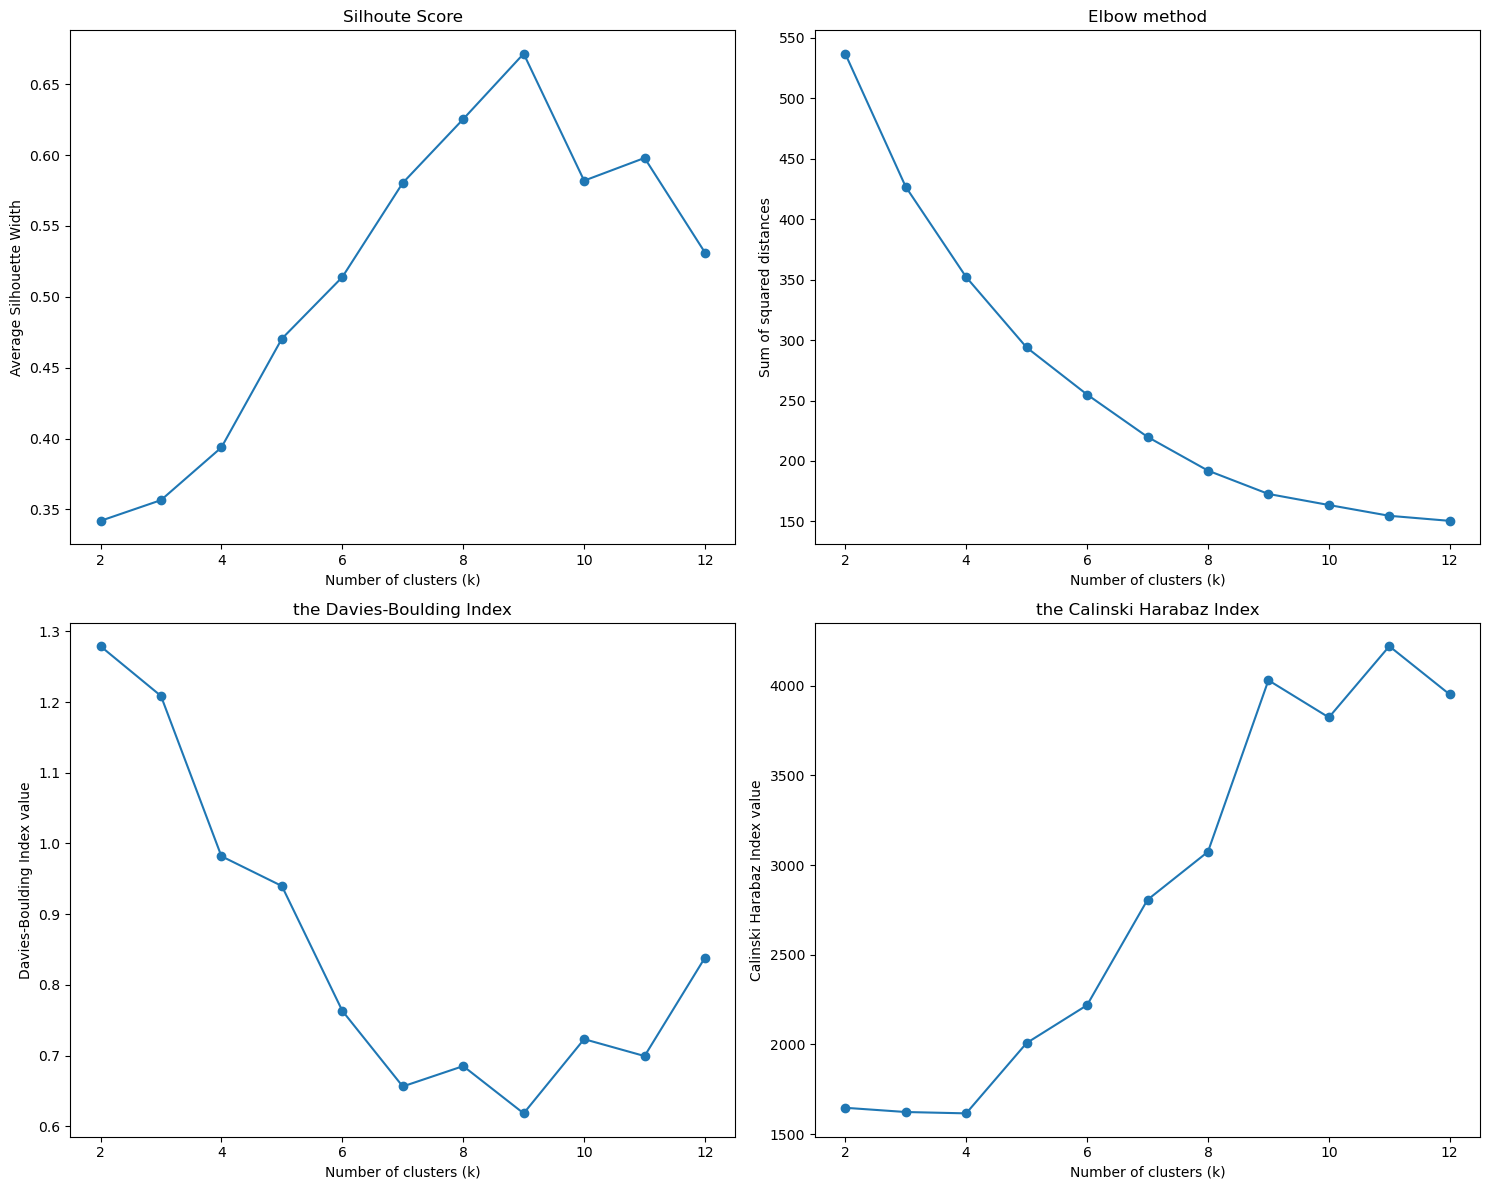

In [155]:
pam_sil_elbow(gower_matrix_1, range(2,13))

The number of clusters is 9. So we fit the model to the data and predict the cluster values.

In [156]:
km_model = KMedoids(n_clusters = 9, random_state = 42, metric = 'precomputed', method = 'pam', 
                            init =  'k-medoids++')
km_model.fit(gower_matrix_1)
km_model.predict(gower_matrix_1)

array([6, 0, 3, ..., 5, 5, 2])

And now, we add the labels to the dataset.

In [157]:
trial_data = df_users_only_demo_clus1.copy()

trial_data['cluster'] = km_model.labels_

In [158]:
def clus_plot(df, cat_cols, num_cols):
    
    df2 = df.loc[:, df.columns != 'cluster']
    no_col = len(df2.columns)
    
    df_cols = df2.columns
    
    plt.figure(figsize=(15,12))
    
    no_rows_pl = math.ceil(no_col/2)
    
    for i in range(no_col):
        
        axi = plt.subplot(no_rows_pl, 2, i+1)
        
        if df_cols[i] in num_cols:
            sns.swarmplot(y = df[df_cols[i]], x = df["cluster"])
            plt.title("{}\n".format(df_cols[i]), fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
        elif df_cols[i] in cat_cols:
            sns.countplot(x="cluster", hue = df_cols[i], data=df, ax = axi)
            plt.title("{}\n".format(df_cols[i]), fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
        plt.tight_layout()
    
    plt.show()
    

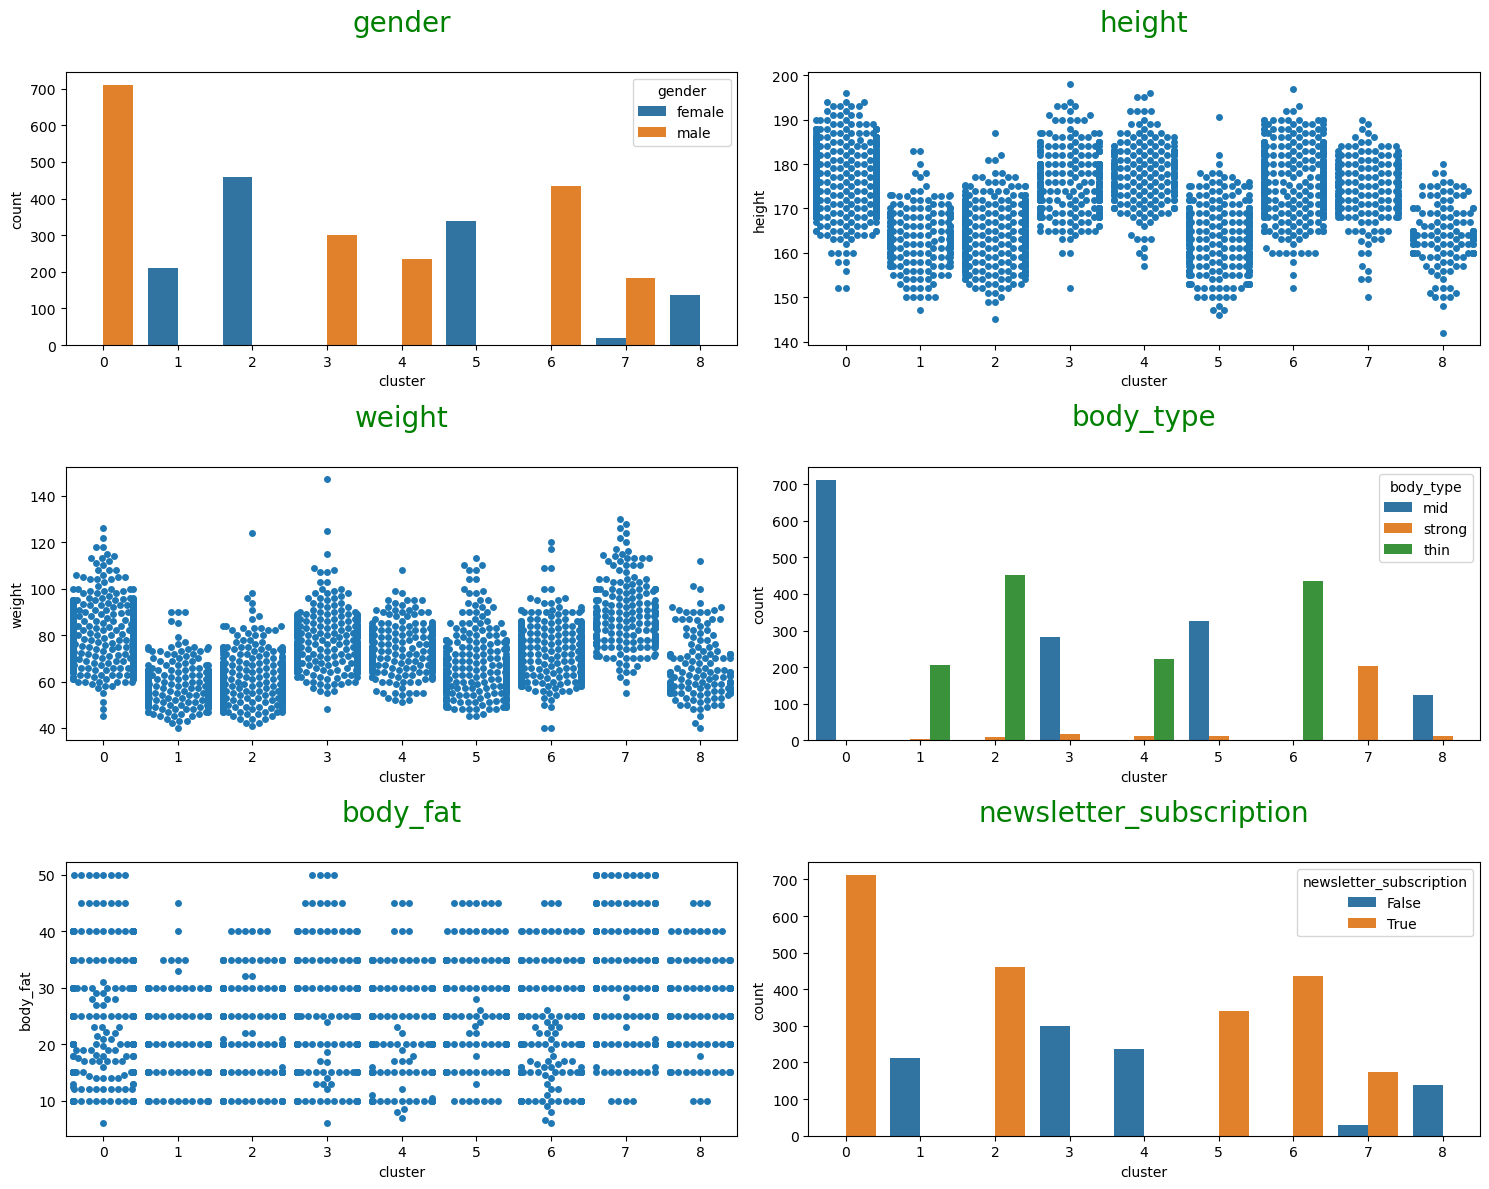

In [160]:
clus_plot(trial_data, cat_cols = ['gender', 'body_type', 'newsletter_subscription'], 
          num_cols = ['height', 'weight', 'body_fat'])

The description of the cluster could be as follow:

* **Cluster 0** - mid women without newsletter subscription, lower to average height, lower to average weight and all body fat,
* **Cluster 1** - mid women with newsletter subscription, medium to lower height, low to average weight and average body fat,
* **Cluster 2** - men with mid body type with newsletter subscription, tall, medium and high weight and mostly medium to high body fat,
* **Cluster 3** - female with thin body type, newsletter subscription, medium height, lower weight and body fat from low to average,
* **Cluster 4** - thin men with newsletter subscription, tall, average weight and lower to medium body fat,
* **Cluster 5** - women with thin body type, no newsletter subscription, shorter to average height, low weight and low body fat,
* **Cluster 6** - strong man with mostly newsletter subscription, of average height, high weight and average to high body fat,
* **Cluster 7** - men with mostly mid body type, no newsletter subscription, rather tall, medium weight and medium body fat,
* **Cluster 8** - men with thin body type without newsletter subscription, rather tall, average weight and average body fat.

### **Hierarchical clustering**

Now, let's proceed with hierarchical clustering. The linkages taken into consideration are:
* single,
* complete,
* average.

#### **Single**

First we'll try with single linkage.

For n_clusters=2, the silhouette score is 0.18970000743865967, the Davies-Boulding Index is 0.8738, 
 the Calinski Harabaz Index is 35.3247
For n_clusters=3, the silhouette score is 0.006599999964237213, the Davies-Boulding Index is 1.1085, 
 the Calinski Harabaz Index is 38.5793
For n_clusters=4, the silhouette score is -0.06530000269412994, the Davies-Boulding Index is 1.0868, 
 the Calinski Harabaz Index is 55.3293
For n_clusters=5, the silhouette score is 0.030899999663233757, the Davies-Boulding Index is 0.9559, 
 the Calinski Harabaz Index is 174.5802
For n_clusters=6, the silhouette score is 0.20669999718666077, the Davies-Boulding Index is 0.8191, 
 the Calinski Harabaz Index is 435.2391
For n_clusters=7, the silhouette score is 0.26420000195503235, the Davies-Boulding Index is 0.7655, 
 the Calinski Harabaz Index is 487.0628
For n_clusters=8, the silhouette score is 0.37540000677108765, the Davies-Boulding Index is 0.6938, 
 the Calinski Harabaz Index is 763.2618
For n_cluster

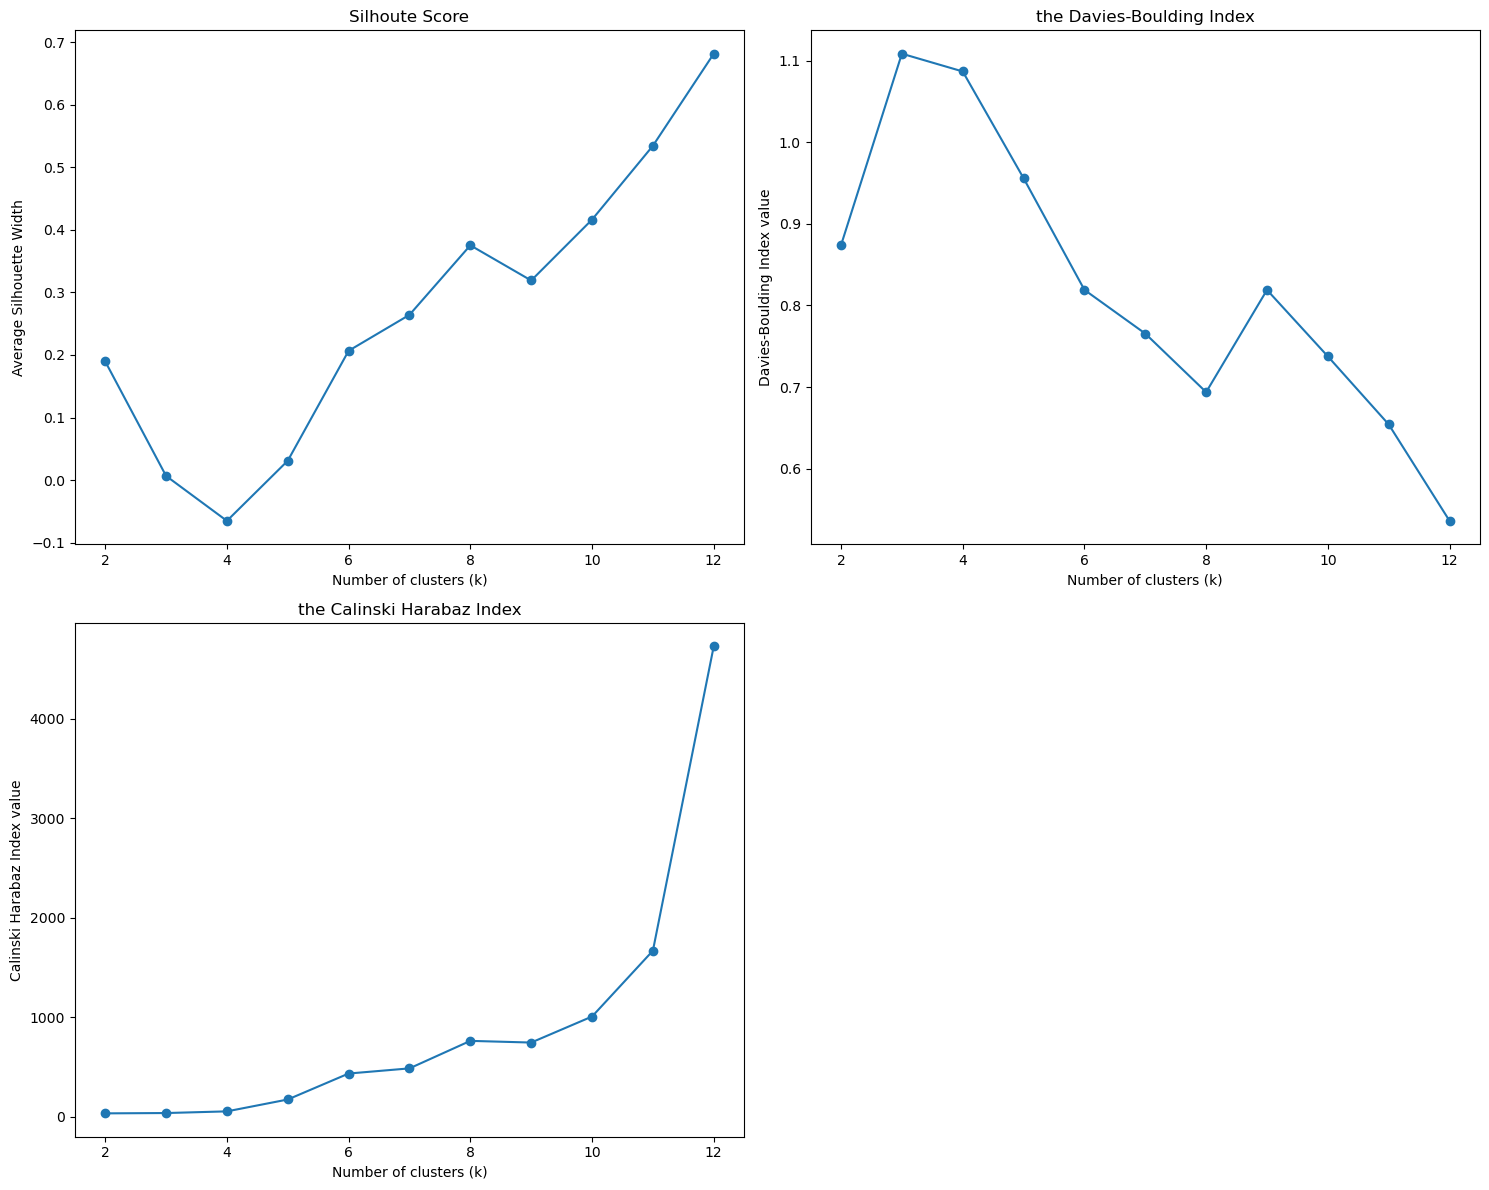

In [167]:
hier_sil(gower_matrix_1, ran = range(2,13), link = 'single')

The number of clusters is 12.

In [55]:
Agg_hc = AgglomerativeClustering(n_clusters = 12, affinity = 'precomputed', linkage = 'single').fit(gower_matrix_1)
#y_hc = Agg_hc.fit_predict(gower_matrix_4_weeks) # model fitting on the dataset

labels = Agg_hc.labels_

#### **Complete**

Now, let's take the complete linkage.

For n_clusters=2, the silhouette score is 0.4113999903202057, the Davies-Boulding Index is 1.1334, 
 the Calinski Harabaz Index is 2120.2126
For n_clusters=3, the silhouette score is 0.3919999897480011, the Davies-Boulding Index is 1.2028, 
 the Calinski Harabaz Index is 1822.2645
For n_clusters=4, the silhouette score is 0.3970000147819519, the Davies-Boulding Index is 1.1349, 
 the Calinski Harabaz Index is 1450.4885
For n_clusters=5, the silhouette score is 0.4341000020503998, the Davies-Boulding Index is 1.1717, 
 the Calinski Harabaz Index is 1579.488
For n_clusters=6, the silhouette score is 0.41920000314712524, the Davies-Boulding Index is 1.2128, 
 the Calinski Harabaz Index is 1346.0176
For n_clusters=7, the silhouette score is 0.4943999946117401, the Davies-Boulding Index is 1.0844, 
 the Calinski Harabaz Index is 1677.0093
For n_clusters=8, the silhouette score is 0.5644000172615051, the Davies-Boulding Index is 0.9366, 
 the Calinski Harabaz Index is 2054.3717
For n_cluster

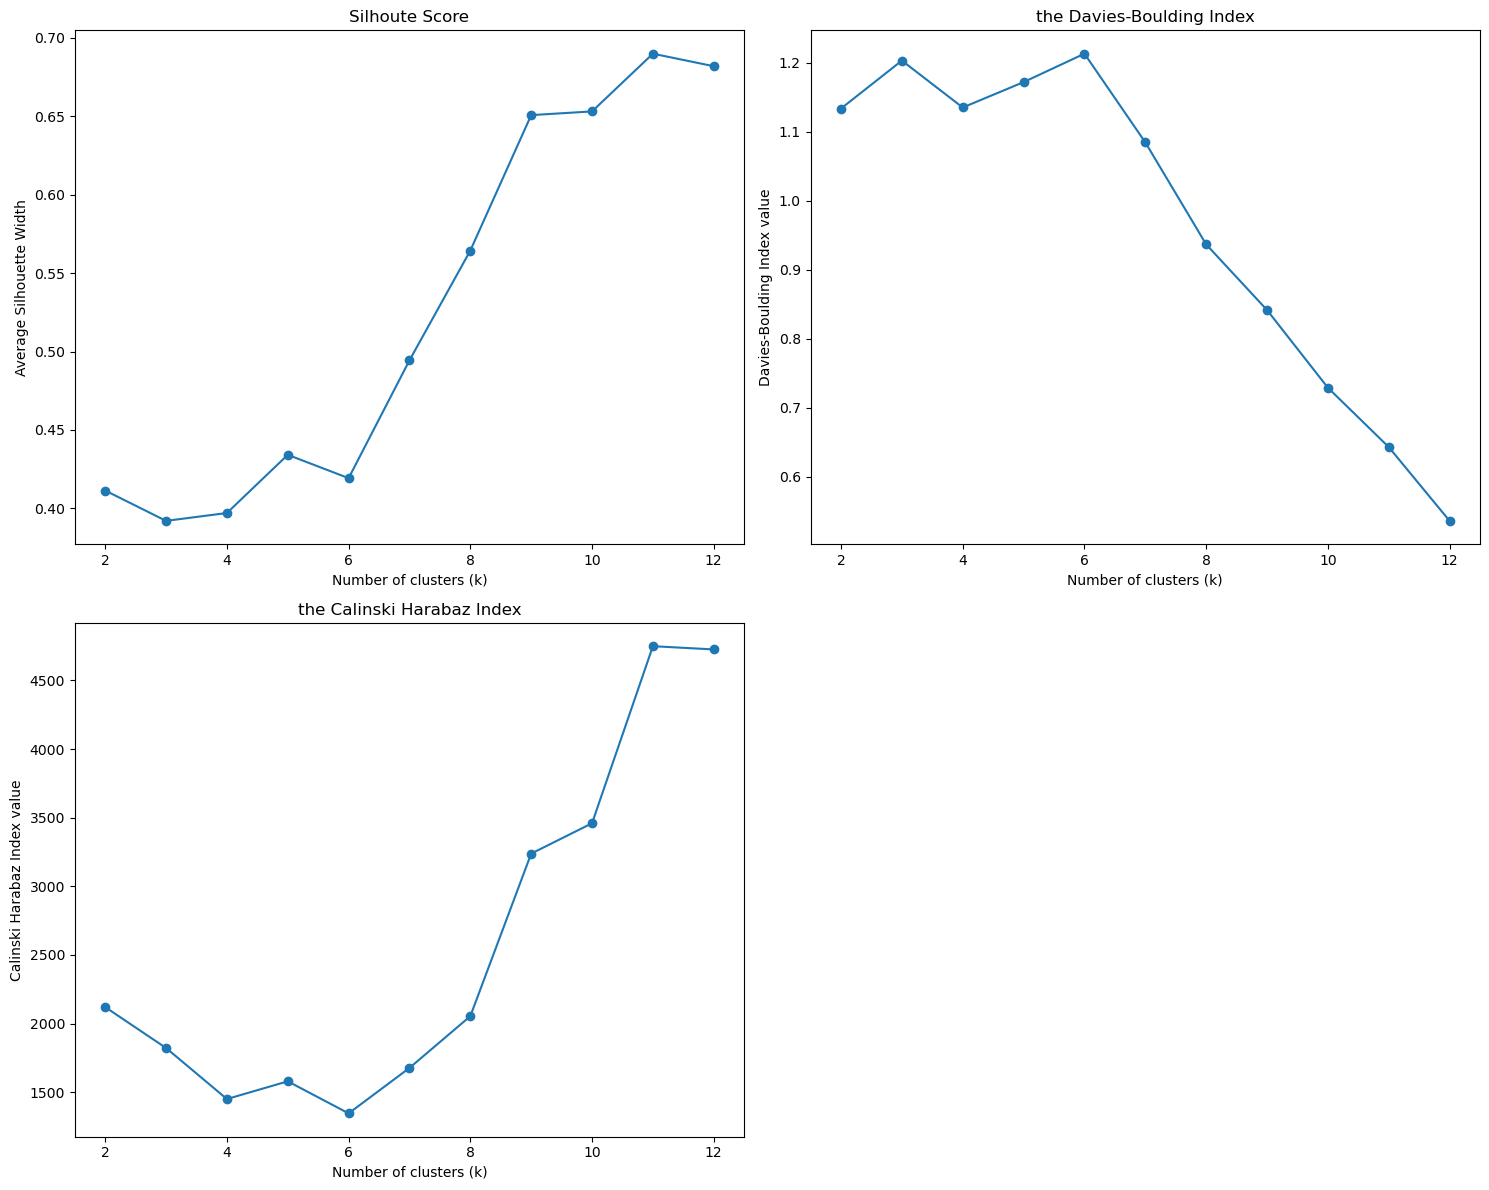

In [168]:
hier_sil(gower_matrix_1, ran = range(2,13), link = 'complete')

The number of clusters is 11.


In [56]:
Agg_hc_c = AgglomerativeClustering(n_clusters = 11, affinity = 'precomputed', linkage = 'complete').fit(gower_matrix_1)
#y_hc = Agg_hc.fit_predict(gower_matrix_4_weeks) # model fitting on the dataset

labels_c = Agg_hc_c.labels_

#### **Average**

Now with the average linkage.

For n_clusters=2, the silhouette score is 0.4113999903202057, the Davies-Boulding Index is 1.1334, 
 the Calinski Harabaz Index is 2120.2126
For n_clusters=3, the silhouette score is 0.2799000144004822, the Davies-Boulding Index is 1.5305, 
 the Calinski Harabaz Index is 1213.3498
For n_clusters=4, the silhouette score is 0.1915999948978424, the Davies-Boulding Index is 1.7634, 
 the Calinski Harabaz Index is 839.4704
For n_clusters=5, the silhouette score is 0.33500000834465027, the Davies-Boulding Index is 1.42, 
 the Calinski Harabaz Index is 1130.0825
For n_clusters=6, the silhouette score is 0.436599999666214, the Davies-Boulding Index is 1.1837, 
 the Calinski Harabaz Index is 1396.3157
For n_clusters=7, the silhouette score is 0.38580000400543213, the Davies-Boulding Index is 1.0174, 
 the Calinski Harabaz Index is 1256.5343
For n_clusters=8, the silhouette score is 0.3441999852657318, the Davies-Boulding Index is 0.8676, 
 the Calinski Harabaz Index is 1102.9394
For n_clusters=

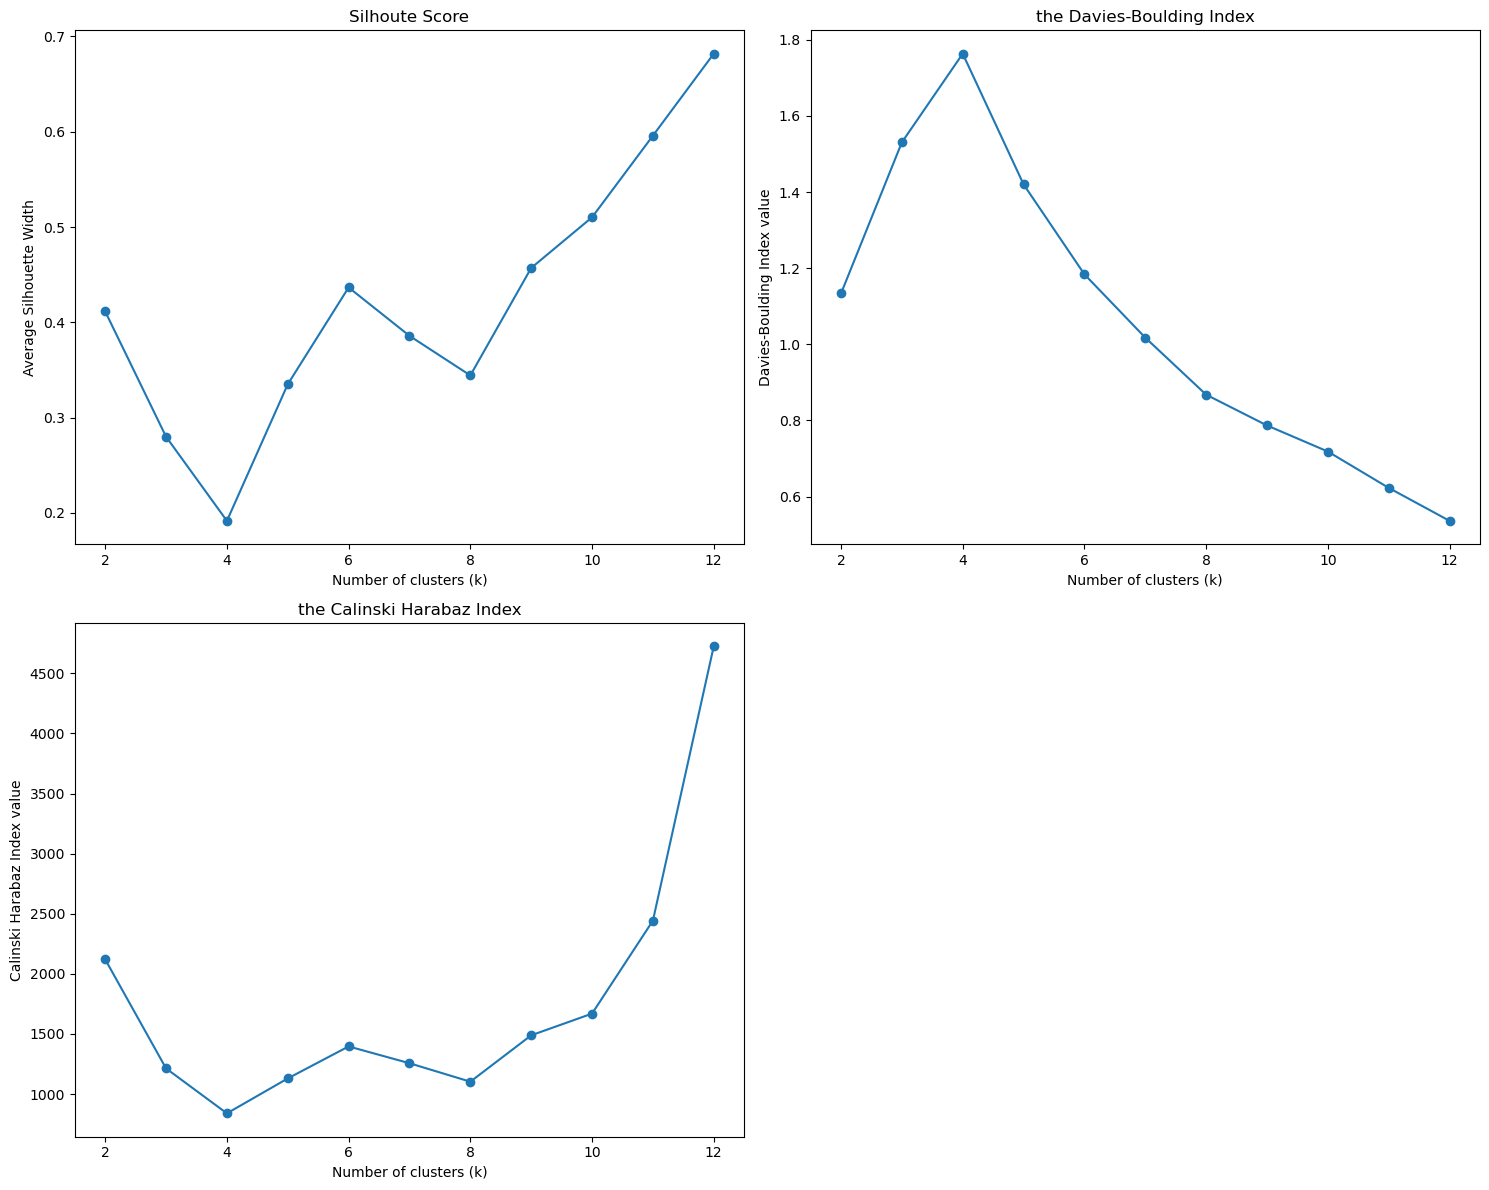

In [169]:
hier_sil(gower_matrix_1, ran = range(2,13), link = 'average')

The number of clusters is 12.

In [57]:
Agg_hc_a = AgglomerativeClustering(n_clusters = 11, affinity = 'precomputed', linkage = 'average').fit(gower_matrix_1)
#y_hc = Agg_hc.fit_predict(gower_matrix_4_weeks) # model fitting on the dataset

labels_a = Agg_hc_a.labels_

#### **Summary**

Now, to summarize, the best option is complete linkage. Now, we will add labels to the data.

In [170]:
cluster_labels_1 = labels_c

In [171]:
trial_data_hier = df_users_only_demo_clus1.copy()
trial_data_hier["cluster"] = cluster_labels_1

Below there is a number of users in each cluster,

In [172]:
trial_data_hier["cluster"].value_counts()

2     711
5     451
4     435
7     327
1     283
8     223
10    206
3     155
6     125
0      59
9      59
Name: cluster, dtype: int64

In [61]:
trial_data_hier.head()

gender  height  weight body_type  body_fat newsletter_subscription  \
0      male  180.00   70.00      thin     15.00                    True   
35     male  186.00   79.00       mid     10.00                    True   
67     male  186.00   86.00       mid     30.00                   False   
103    male  178.00   70.00       mid     30.00                   False   
198  female  164.00   62.00      thin     30.00                    True   

     age_in_years  cluster  
0           32.00        4  
35          48.00        2  
67          37.00        1  
103         29.00        1  
198         43.00        5

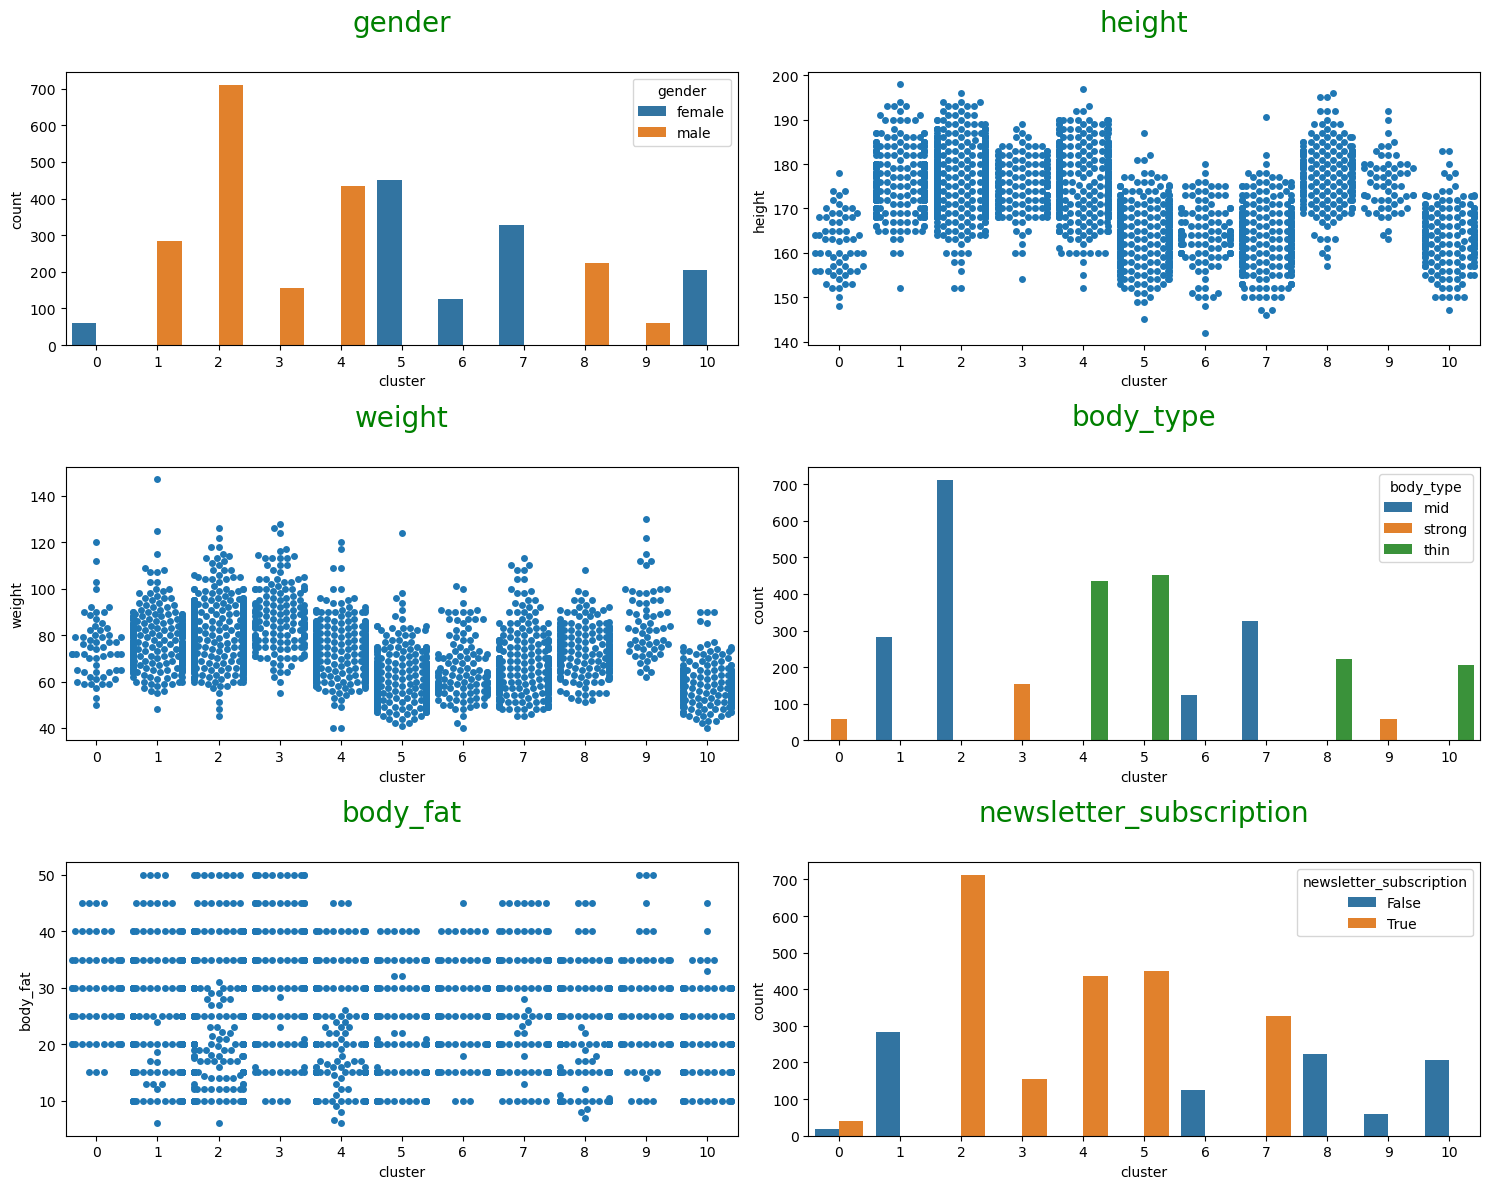

In [173]:
clus_plot(trial_data_hier, cat_cols = ['gender', 'body_type', 'newsletter_subscription'], 
          num_cols = ['height', 'weight', 'body_fat'])

The description of the cluster could be as follow:

* **Cluster 0** - strong women mostly with newsletter subscription, lower to average height, average weight and average to high body fat,
* **Cluster 1** - mid men without newsletter subscription, rather tall height, average to high weight and all levels of body fat body fat,
* **Cluster 2** - men with mid body type with newsletter subscription, tall, medium and high weight and mostly low to medium body fat,
* **Cluster 3** - female with mid body type, newsletter subscription, low to medium height, lower to medium weight and average body fat,
* **Cluster 4** - thin women with newsletter subscription, low to average height, low weight and lower to medium body fat,
* **Cluster 5** - men with strong body type, newsletter subscription, average height, high weight and evenly distributed body fat,
* **Cluster 6** - women with mid body type, no newsletter subscription, rather shorter, lower weight and average body fat,
* **Cluster 7** - men with thin body type, no newsletter subscription, rather average to tall, medium weight and medium body fat,
* **Cluster 8** - men with thin body type, newsletter subscription, rather tall, average weight and lower to average body fat,
* **Cluster 9** - men with strong body type, no newsletter subscription, average height, rather big weight and average body fat,
* **Cluster 10** - thin women, no newsletter subscription, rather shorter, lower weight and lower body fat.

### **K-prototypes**

For K-prototypes model we won't use the gower matrix of dissimilarities. Data used will be encoded and raw.

In [174]:
df_kpro = df_users_only_demo_clus_enc1.copy()

In [175]:
hopkins(df_kpro)

0.89354699195401

In [176]:
categorical_cols = ['gender', 'body_type', 'newsletter_subscription']

For n_clusters=2, method: Huang, the silhouette score is 0.3884
For n_clusters=2, method: Cao, the silhouette score is 0.3884
For n_clusters=3, method: Huang, the silhouette score is 0.3449
For n_clusters=3, method: Cao, the silhouette score is 0.3463
For n_clusters=4, method: Huang, the silhouette score is 0.3307
For n_clusters=4, method: Cao, the silhouette score is 0.3299
For n_clusters=5, method: Huang, the silhouette score is 0.3126
For n_clusters=5, method: Cao, the silhouette score is 0.3124
For n_clusters=6, method: Huang, the silhouette score is 0.2776
For n_clusters=6, method: Cao, the silhouette score is 0.2764
For n_clusters=7, method: Huang, the silhouette score is 0.276
For n_clusters=7, method: Cao, the silhouette score is 0.2749
For n_clusters=8, method: Huang, the silhouette score is 0.2703
For n_clusters=8, method: Cao, the silhouette score is 0.2703
For n_clusters=9, method: Huang, the silhouette score is 0.2479
For n_clusters=9, method: Cao, the silhouette score is 

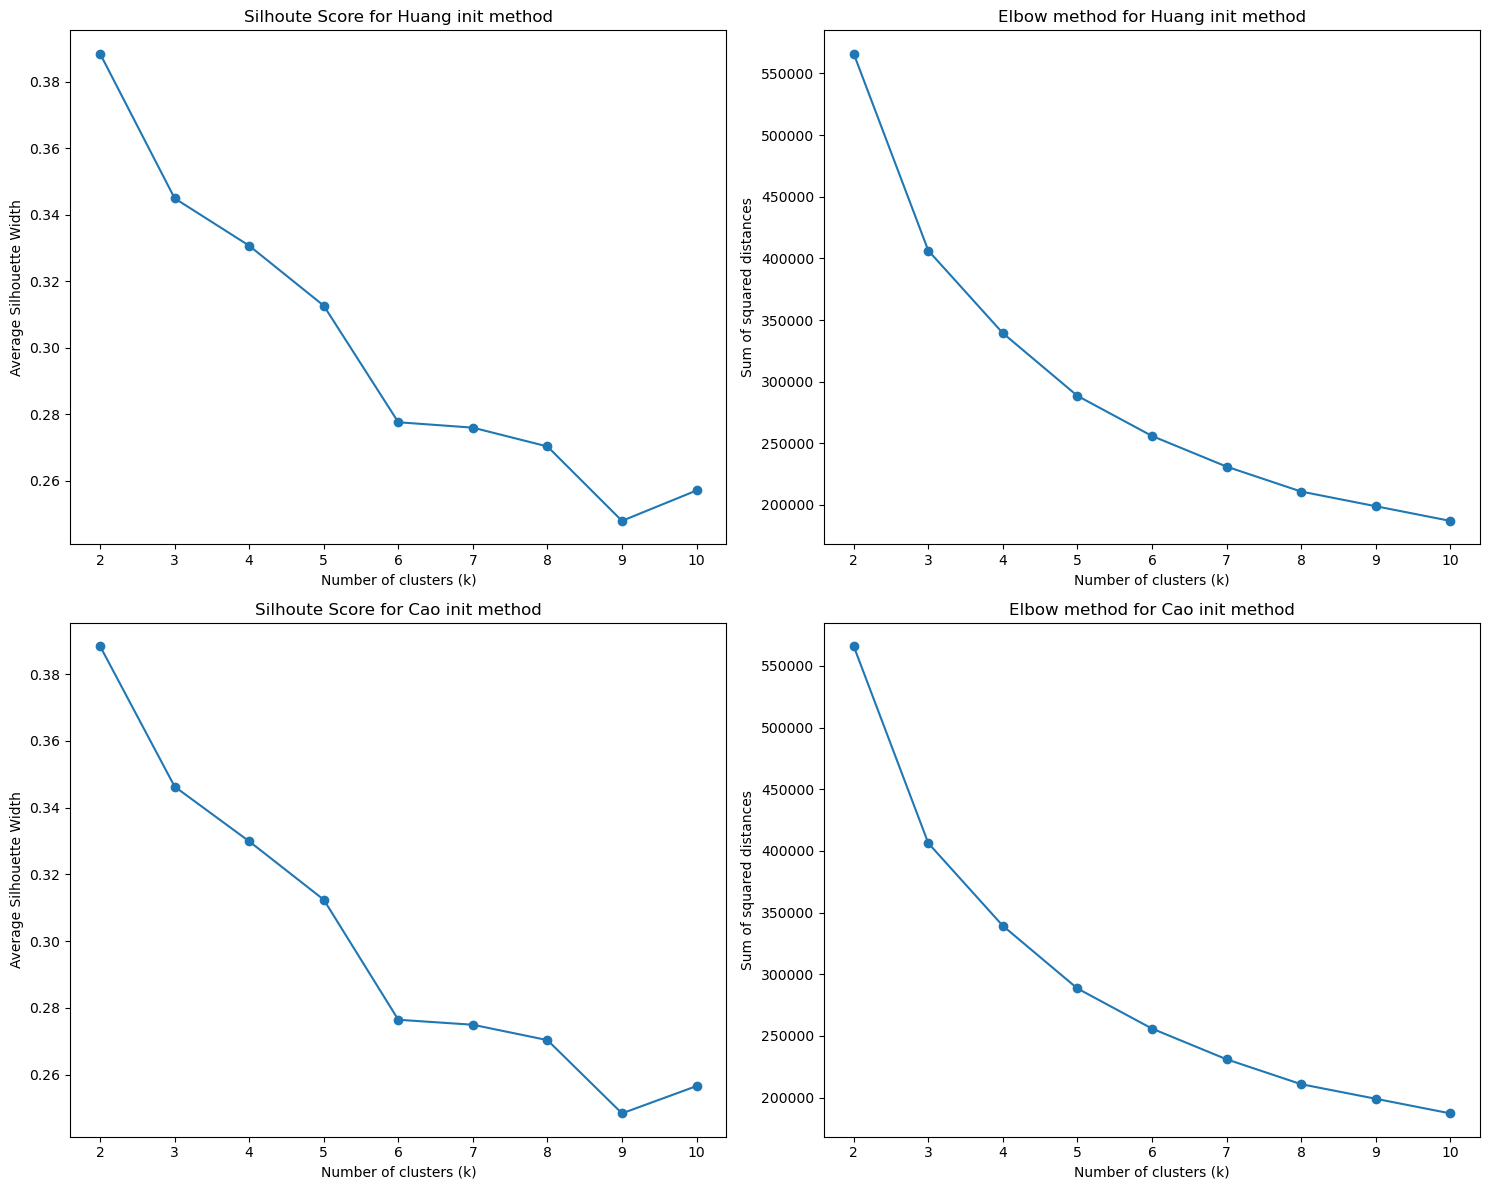

In [177]:
kpro_sil_elbow(df_kpro, categorical_cols, ran = range(2,11))

In [178]:
kproto = KPrototypes(n_clusters=2, init='Huang')
clusters = kproto.fit_predict(df_kpro, categorical=[0, 3,5])

labels = pd.DataFrame(clusters)
labels.rename(columns = {0: 'cluster'}, inplace = True)

In [68]:
df_kpro.reset_index(inplace = True, drop = True)
#df_kpro.drop(['index'], inplace = True)

In [69]:
labeled_data = pd.concat((df_users_only_demo_clus1.reset_index(drop = True),labels),axis=1)

In [70]:
davies_bouldin_score(df_kpro, labeled_data['cluster'])

1.1788642757519494

In [71]:
labeled_data['cluster'].value_counts()

1    1521
0    1513
Name: cluster, dtype: int64

In [72]:
labeled_data.head()

gender  height  weight body_type  body_fat newsletter_subscription  \
0    male  180.00   70.00      thin     15.00                    True   
1    male  186.00   79.00       mid     10.00                    True   
2    male  186.00   86.00       mid     30.00                   False   
3    male  178.00   70.00       mid     30.00                   False   
4  female  164.00   62.00      thin     30.00                    True   

   age_in_years  cluster  
0         32.00        0  
1         48.00        1  
2         37.00        1  
3         29.00        1  
4         43.00        0

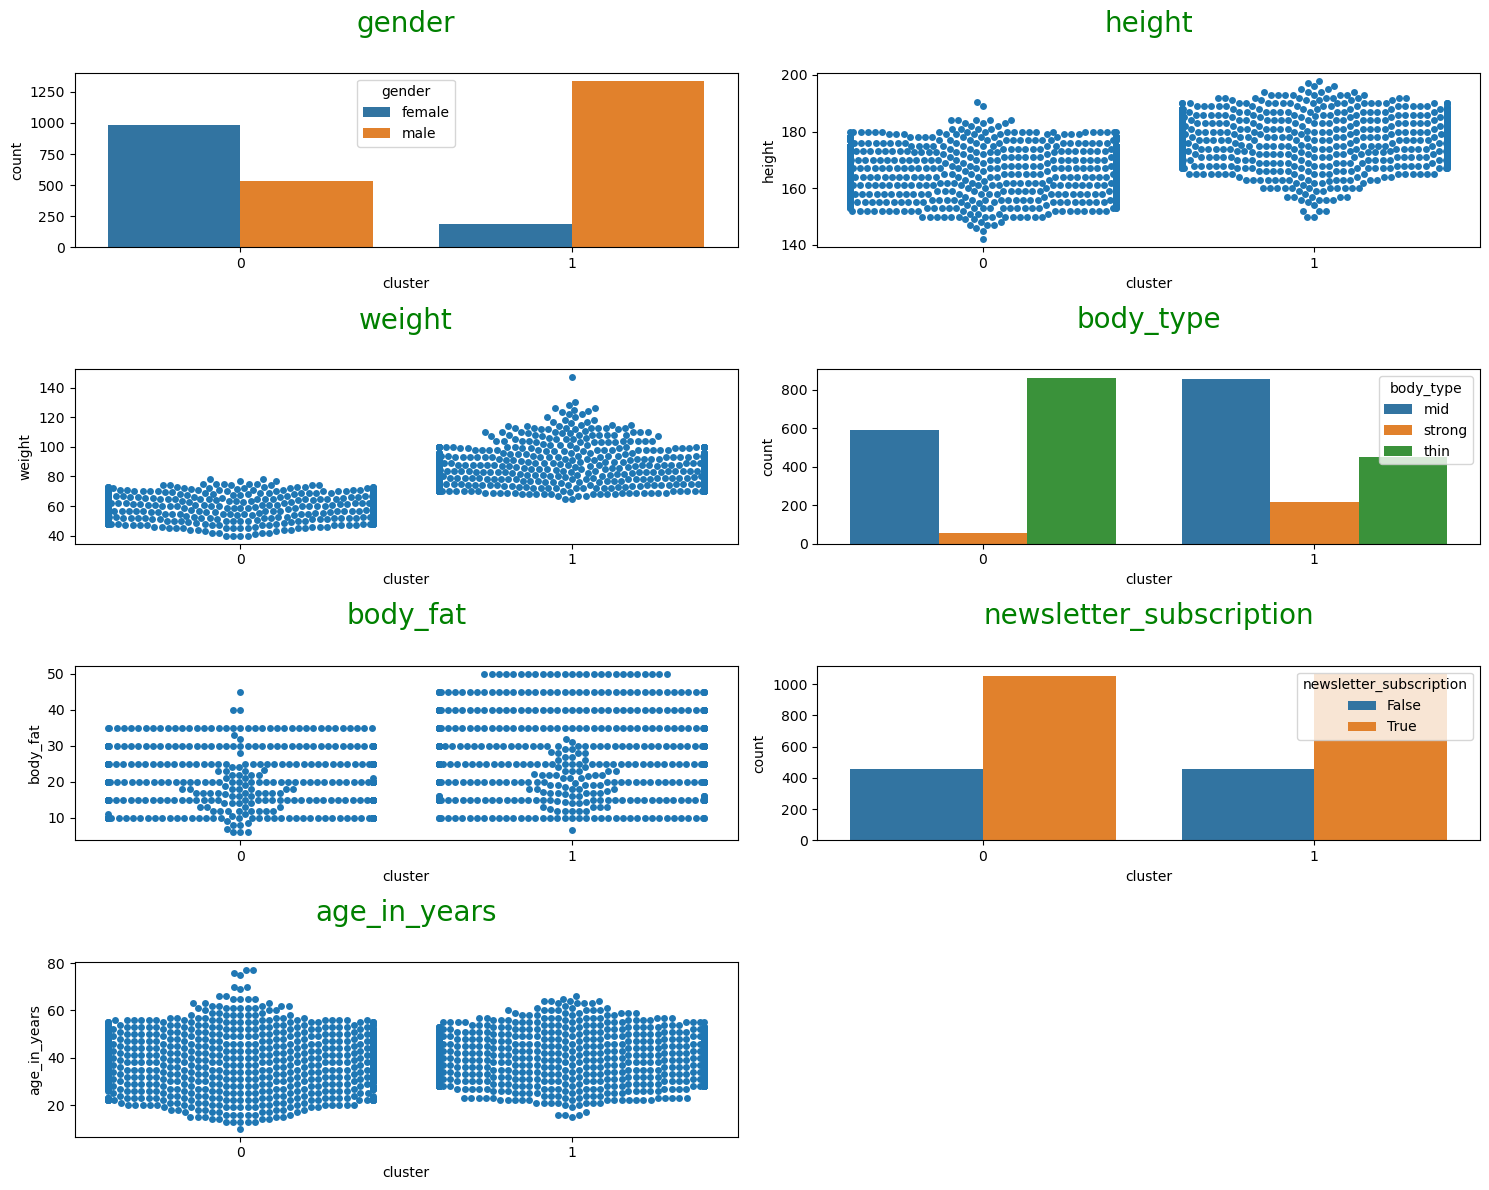

In [73]:
clus_plot(labeled_data, cat_cols = ['gender', 'body_type', 'newsletter_subscription'], 
          num_cols = ['height', 'weight', 'body_fat', 'age_in_years'])

The description of the cluster could be as follow:

* **Cluster 0** - mostly female with thin or mid body type, and mostly with newsletter subscription, lower to average height, low weight and lower body fat, 
* **Cluster 1** - mostly men with mid body type, newsletter subscription, average to tall height, big weight and average to big body fat.-

#### **Scaled data**

For K-prototypes model we won't use the gower matrix of dissimilarities. Data used will be encoded and numerical data will be scaled.

In [48]:
df_kpro_sca = df_kpro.copy()

In [49]:
numerical_columns = ['height', 'weight', 'body_fat']

In [50]:
scaler = StandardScaler()

# standard scale numerical features
for c in numerical_columns:
    df_kpro_sca[c] = scaler.fit_transform(df_kpro_sca[[c]])

Again, we check hopkins score, it is better than before.

In [51]:
hopkins(df_kpro_sca)

0.878862559008324

For n_clusters=2, method: Huang, the silhouette score is 0.2651
For n_clusters=2, method: Cao, the silhouette score is 0.265
For n_clusters=3, method: Huang, the silhouette score is 0.2485
For n_clusters=3, method: Cao, the silhouette score is 0.2485
For n_clusters=4, method: Huang, the silhouette score is 0.2183
For n_clusters=4, method: Cao, the silhouette score is 0.2184
For n_clusters=5, method: Huang, the silhouette score is 0.1777
For n_clusters=5, method: Cao, the silhouette score is 0.1772
For n_clusters=6, method: Huang, the silhouette score is 0.1607
For n_clusters=6, method: Cao, the silhouette score is 0.1584
For n_clusters=7, method: Huang, the silhouette score is 0.1569
For n_clusters=7, method: Cao, the silhouette score is 0.1525
For n_clusters=8, method: Huang, the silhouette score is 0.1374
For n_clusters=8, method: Cao, the silhouette score is 0.1453
For n_clusters=9, method: Huang, the silhouette score is 0.1297
For n_clusters=9, method: Cao, the silhouette score is 

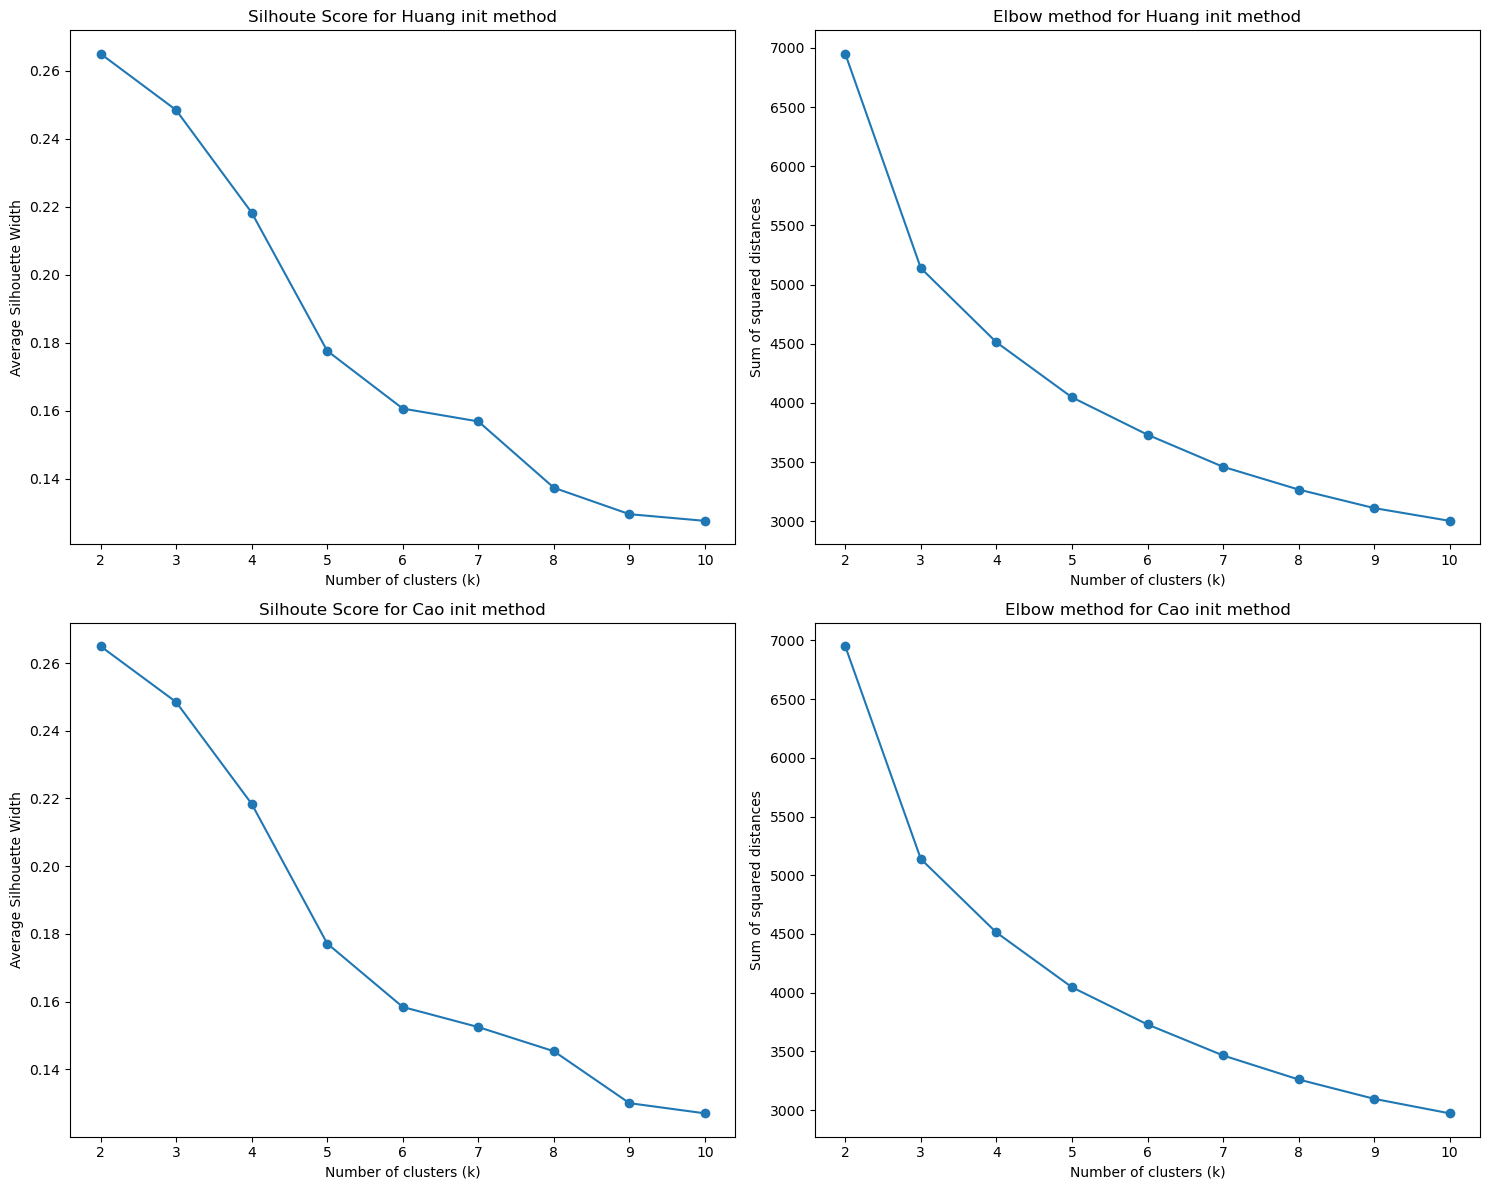

In [52]:
kpro_sil_elbow(df_kpro_sca, categorical_cols, ran = range(2,11))

The probable number of clusters is 2, but the silhouette score is pretty low, so the clusterization won't be too good.

In [53]:
kproto_sca = KPrototypes(n_clusters=2, init='Huang')
clusters_sca = kproto_sca.fit_predict(df_kpro_sca, categorical=[0, 3,5])

labels_sca = pd.DataFrame(clusters_sca)
labels_sca.rename(columns = {0: 'cluster'}, inplace = True)

We add the labels to the data.

In [54]:
labeled_data_sca = pd.concat((df_users_only_demo_clus1.reset_index(drop = True),labels_sca),axis=1)

Below there is a value count of number of users in each cluster.

In [55]:
labeled_data_sca['cluster'].value_counts()

1    1684
0    1350
Name: cluster, dtype: int64

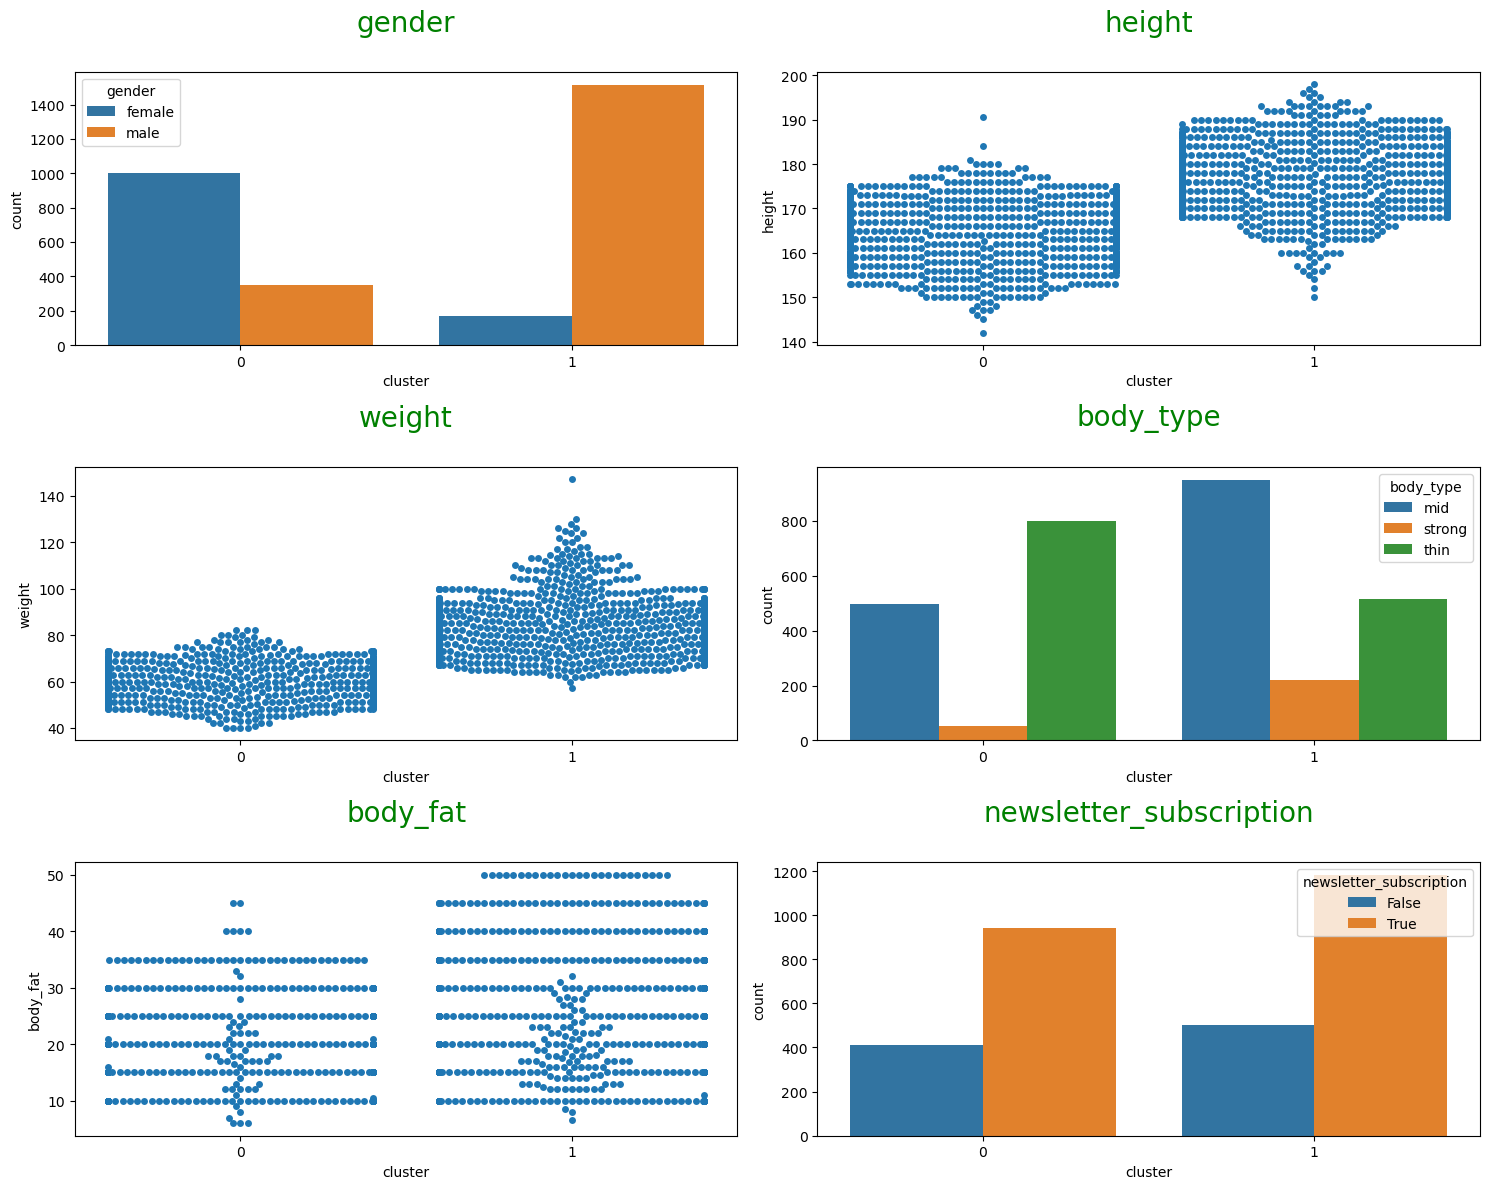

In [56]:
clus_plot(labeled_data_sca, cat_cols = ['gender', 'body_type', 'newsletter_subscription'], 
          num_cols = ['height', 'weight', 'body_fat'])

The description of the cluster could be as follow:

* **Cluster 0** - mostly women with mostly thin and mid body type, newsletter subscription, lower to average height, low weight and low to average body fat,
* **Cluster 1** - mostly mid men with newsletter subscription, average to tall height, average to high weight and higher of body fat.

### **Summary**

In [179]:
# data into summary table
data = {'Name of algorithm' : ['PAM', 'hierarchial clustering (complete linkage)', 
                               'K-prototypes'],
        'Number of clusters (k)' : [9, 11, 2],
        'Silhouette score' : [silhouette_score(gower_matrix_1, trial_data['cluster']),
                              silhouette_score(gower_matrix_1, trial_data_hier["cluster"]),
                              silhouette_score(df_kpro, labeled_data["cluster"])
                              ],
        'Calinski Harabaz Index' : [calinski_harabasz_score(gower_matrix_1, trial_data['cluster']),
                                    calinski_harabasz_score(gower_matrix_1, trial_data_hier["cluster"]),
                                    calinski_harabasz_score(df_kpro, labeled_data["cluster"])
                                   ],
        'Davies Bouldin Index' : [davies_bouldin_score(gower_matrix_1, trial_data['cluster']),
                                  davies_bouldin_score(gower_matrix_1, trial_data_hier["cluster"]),
                                  davies_bouldin_score(df_kpro, labeled_data["cluster"])
                                 ]}


In [180]:
summary_tab = pd.DataFrame(data)
summary_tab.set_index(['Name of algorithm'], inplace = True)

In [181]:
summary_tab

Number of clusters (k)  \
Name of algorithm                                                   
PAM                                                             9   
hierarchial clustering (complete linkage)                      11   
K-prototypes                                                    2   

                                           Silhouette score  \
Name of algorithm                                             
PAM                                                    0.67   
hierarchial clustering (complete linkage)              0.69   
K-prototypes                                           0.39   

                                           Calinski Harabaz Index  \
Name of algorithm                                                   
PAM                                                       4029.88   
hierarchial clustering (complete linkage)                 4749.79   
K-prototypes                                              2635.98   

                                           Davies Bouldin Index  
Name of algorithm                                                
PAM                                                        0.62  
hierarchial clustering (complete linkage)                  0.64  
K-prototypes                                               0.96

Here the best one is hierarchical clustering with complete linkage.

## **Variables gender, body_type, newsletter_subscription, BMI and body fat**

Here, variables taken into consideration are:
* gender,
* body_type.
* newsletter_subscription,
* BMI and
* body_fat.

In [182]:
df_users_only_demo_clus2 = df_users_only_demo_clus.loc[:, ['gender', 'BMI',
       'body_type', 'body_fat', 'newsletter_subscription']]

df_users_only_demo_clus_enc2 = df_users_only_demo_clus2.copy()

for col in ['gender', 'body_type', 'newsletter_subscription']:
    df_users_only_demo_clus_enc2[col] = LabelEncoder().fit_transform(df_users_only_demo_clus_enc2[col])



In [183]:
gower_matrix_2 = gower.gower_matrix(df_users_only_demo_clus_enc2, cat_features = [True, False, True, False, True])


In [184]:
hopkins(pd.DataFrame(gower_matrix_2)) # hopkins score to see if data is good for clustering

0.9947718394621782

### **PAM**

For n_clusters=2, the silhouette score is 0.3357999920845032, the Davies-Boulding Index is 1.3914, 
 the Calinski Harabaz Index is 1345.3333
For n_clusters=3, the silhouette score is 0.3407999873161316, the Davies-Boulding Index is 1.1514, 
 the Calinski Harabaz Index is 1344.6331
For n_clusters=4, the silhouette score is 0.39730000495910645, the Davies-Boulding Index is 0.9945, 
 the Calinski Harabaz Index is 1480.1722
For n_clusters=5, the silhouette score is 0.49480000138282776, the Davies-Boulding Index is 0.8922, 
 the Calinski Harabaz Index is 1808.292
For n_clusters=6, the silhouette score is 0.5497000217437744, the Davies-Boulding Index is 0.8044, 
 the Calinski Harabaz Index is 2066.6041
For n_clusters=7, the silhouette score is 0.6223000288009644, the Davies-Boulding Index is 0.6185, 
 the Calinski Harabaz Index is 2691.2126
For n_clusters=8, the silhouette score is 0.6746000051498413, the Davies-Boulding Index is 0.6549, 
 the Calinski Harabaz Index is 3135.7411
For n_cluste

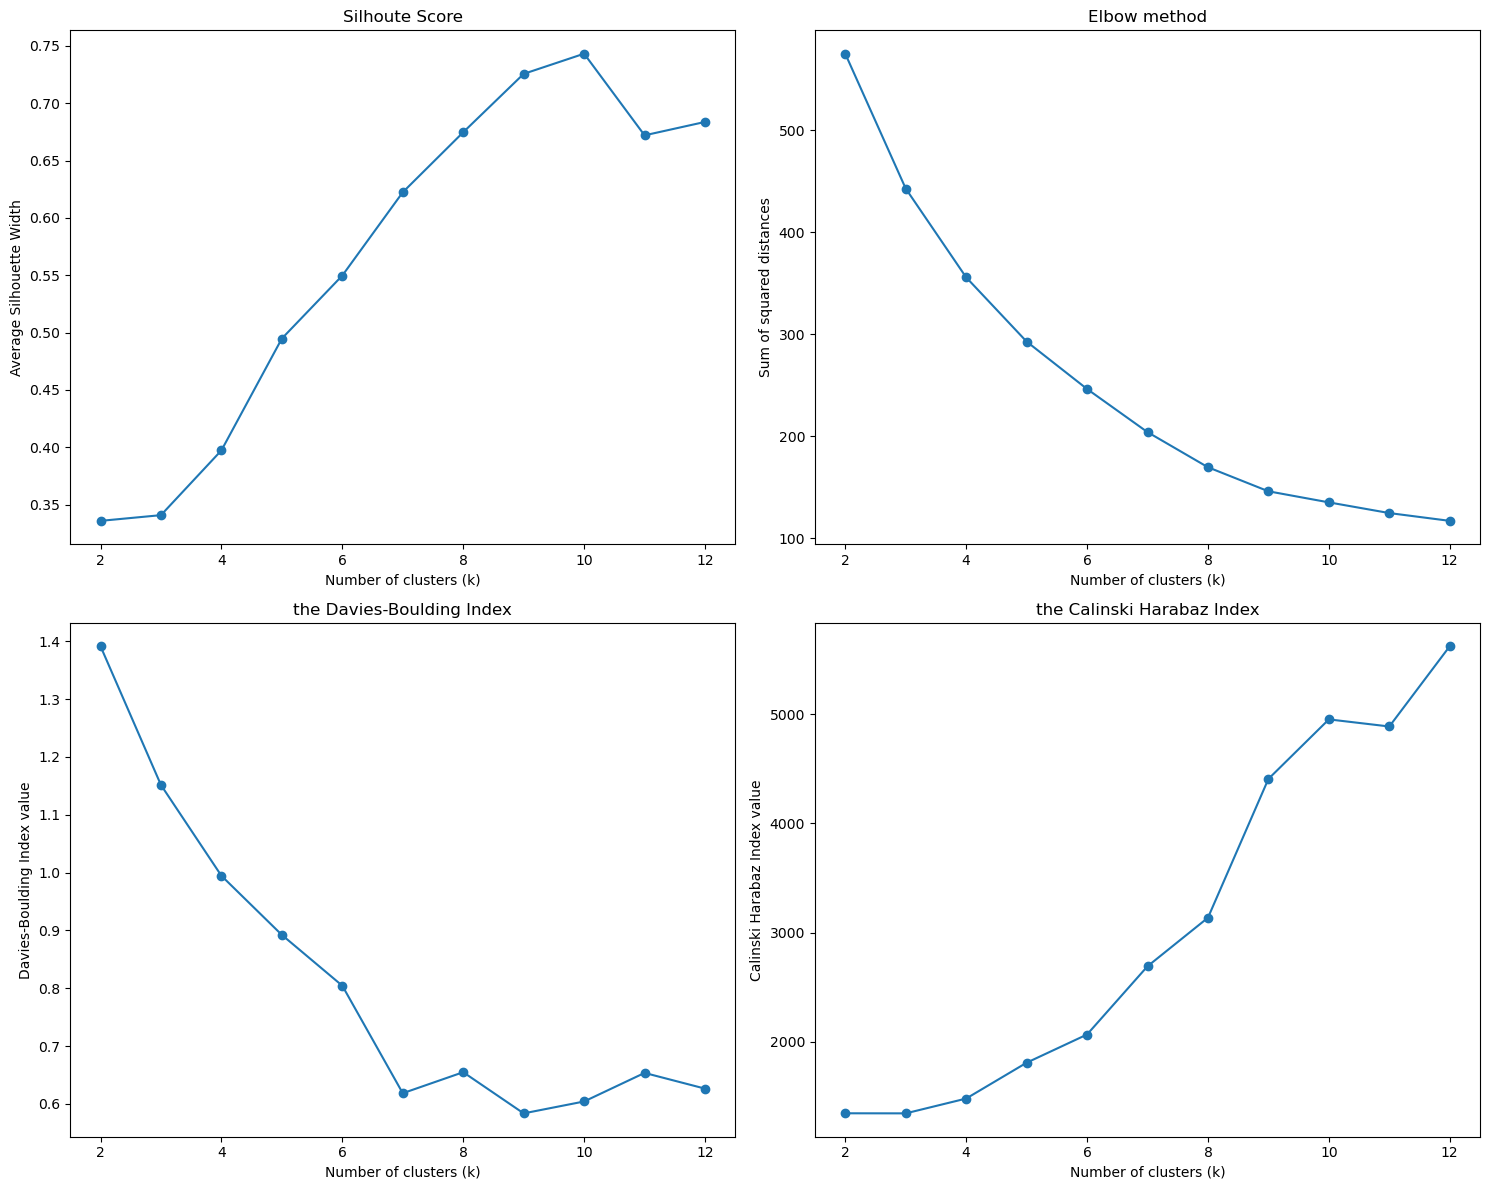

In [185]:
pam_sil_elbow(gower_matrix_2, range(2,13))

The number of clusters is 10.

In [186]:
km_model2 = KMedoids(n_clusters = 10, random_state = 42, metric = 'precomputed', method = 'pam', 
                            init =  'k-medoids++')
km_model2.fit(gower_matrix_2)
km_model2.predict(gower_matrix_2)

array([5, 0, 4, ..., 7, 3, 1])

In [187]:
trial_data2 = df_users_only_demo_clus2.copy()

trial_data2['cluster'] = km_model2.labels_

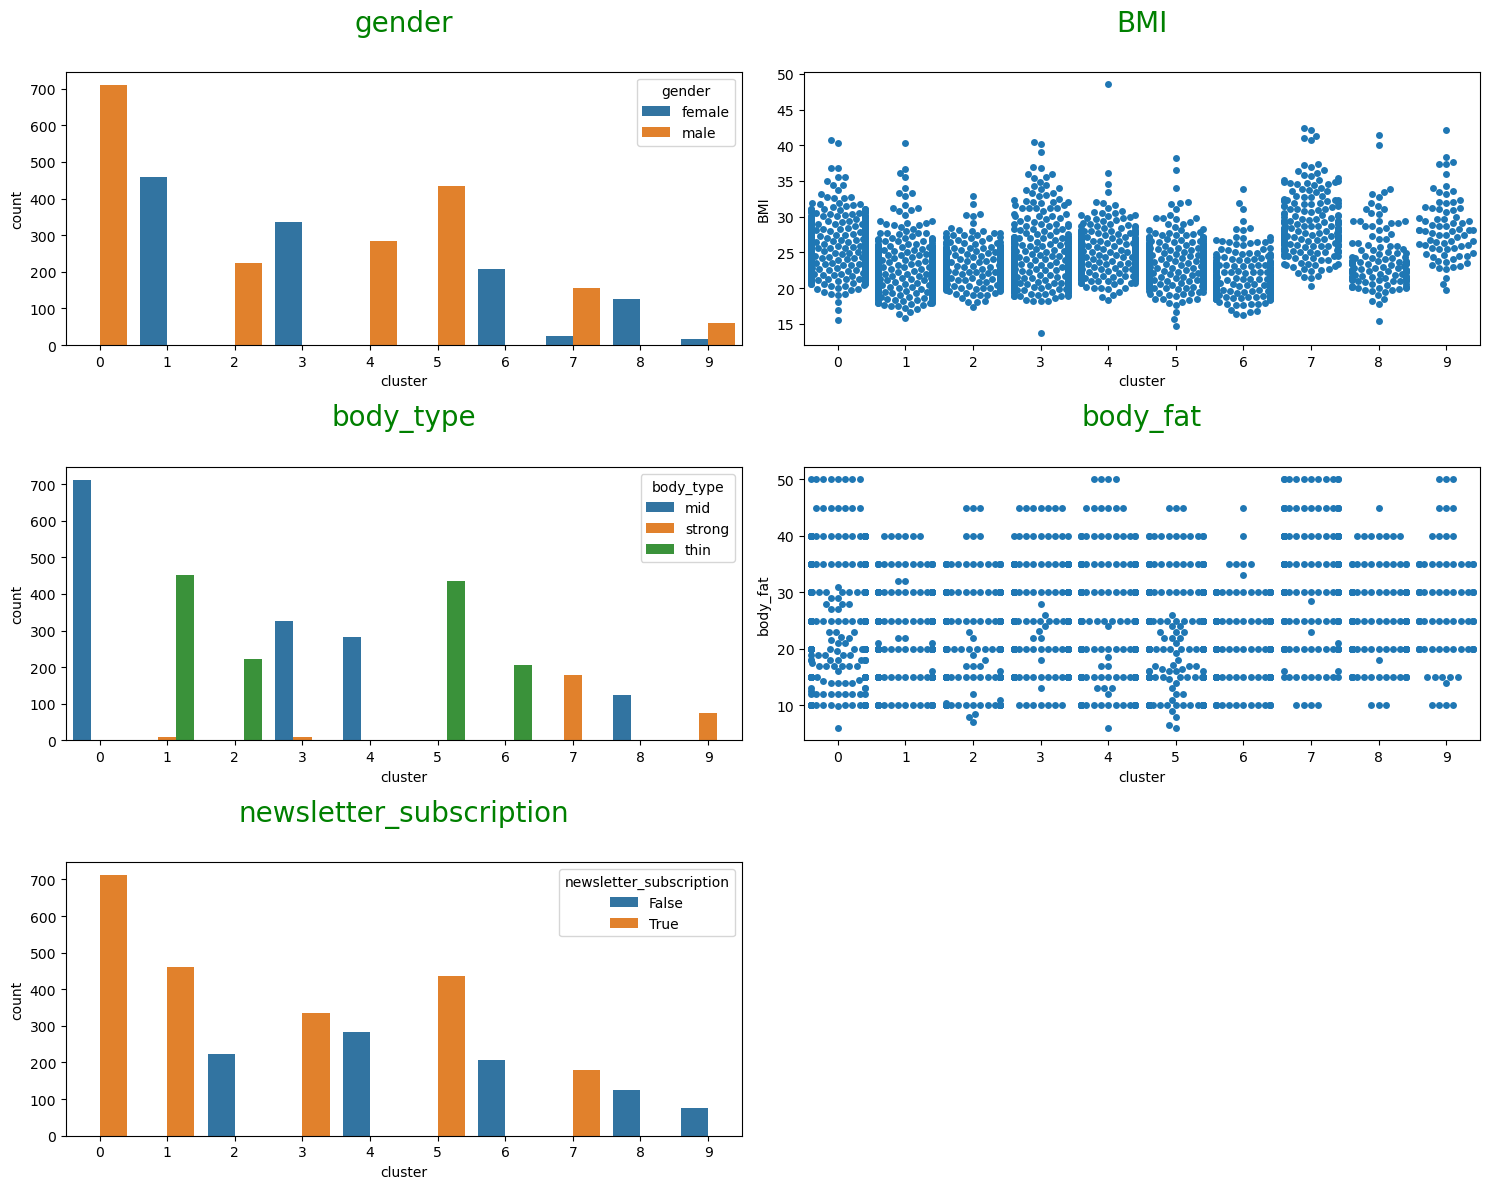

In [188]:
clus_plot(trial_data2, cat_cols = ['gender', 'body_type', 'newsletter_subscription'], 
          num_cols = ['BMI', 'body_fat'])

The description of the cluster could be as follow:

* **Cluster 0** - strong men mostly with no newsletter subscription, average to high BMI and evenly distributed body fat,
* **Cluster 1** - mid women with newsletter subscription, average to high BMI and all levels of body fat body fat,
* **Cluster 2** - women with thin body type with newsletter subscription, lower to average BMI and mostly low to medium body fat,
* **Cluster 3** - male with mid body type, newsletter subscription, medium to high BMI and all levels of body fat body fat,
* **Cluster 4** - thin women without newsletter subscription, low BMI and rather low body fat,
* **Cluster 5** - thin male without newsletter subscription, low BMI and low to average body fat,
* **Cluster 6** - men with mid body type, no newsletter subscription, rather average BMI and evenly distributed body fat,
* **Cluster 7** - women with mid body type, no newsletter subscription, low BMI and average body fat,
* **Cluster 8** - men with strong body type, newsletter subscription, high BMI and average to high body fat,
* **Cluster 9** - men with thin body type, newsletter subscription, low to average BMI and average body fat.

### **Hierarchical clustering**

#### **Single**

For n_clusters=2, the silhouette score is 0.22059999406337738, the Davies-Boulding Index is 0.8371, 
 the Calinski Harabaz Index is 39.4289
For n_clusters=3, the silhouette score is 0.025299999862909317, the Davies-Boulding Index is 1.0805, 
 the Calinski Harabaz Index is 41.8131
For n_clusters=4, the silhouette score is -0.023800000548362732, the Davies-Boulding Index is 1.0475, 
 the Calinski Harabaz Index is 60.4814
For n_clusters=5, the silhouette score is 0.07280000299215317, the Davies-Boulding Index is 0.9267, 
 the Calinski Harabaz Index is 179.1953
For n_clusters=6, the silhouette score is 0.22930000722408295, the Davies-Boulding Index is 0.8041, 
 the Calinski Harabaz Index is 415.4852
For n_clusters=7, the silhouette score is 0.28630000352859497, the Davies-Boulding Index is 0.7571, 
 the Calinski Harabaz Index is 461.5086
For n_clusters=8, the silhouette score is 0.3695000112056732, the Davies-Boulding Index is 0.7107, 
 the Calinski Harabaz Index is 665.0312
For n_clusters

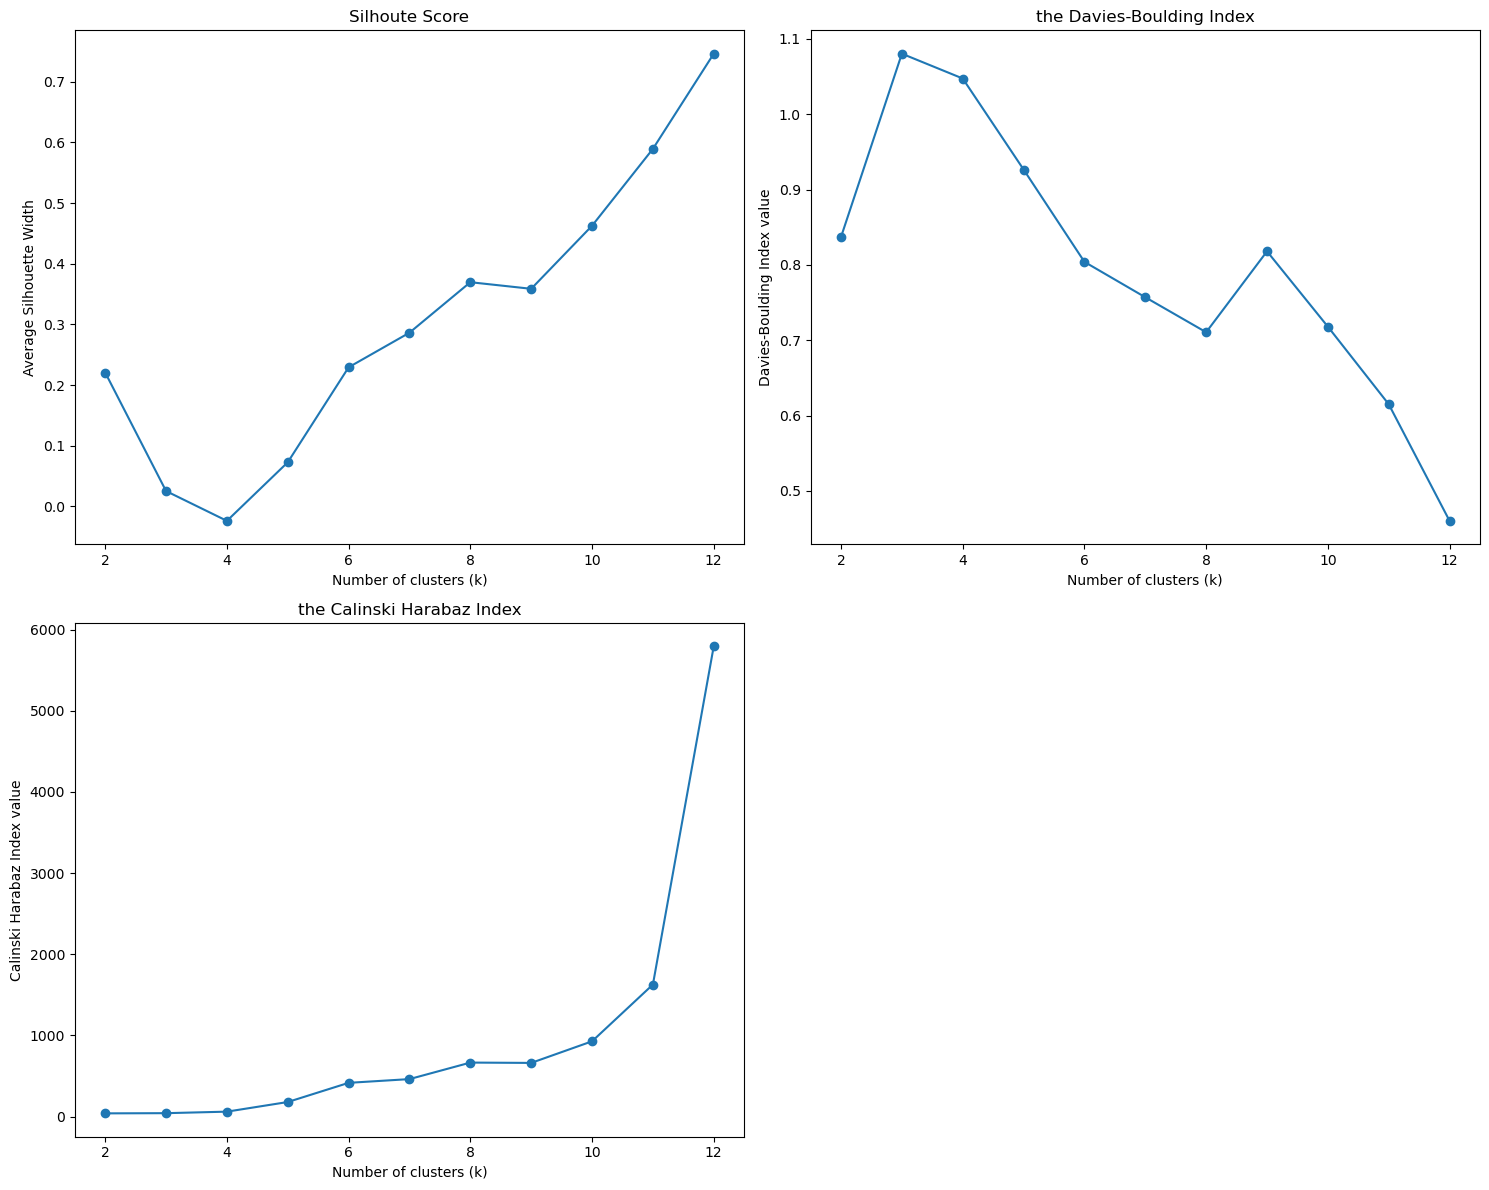

In [189]:
hier_sil(gower_matrix_2, ran = range(2,13), link = 'single')

Number of clusters is probably 12.

In [68]:
Agg_hc2 = AgglomerativeClustering(n_clusters = 12, affinity = 'precomputed', linkage = 'single').fit(gower_matrix_2)
#y_hc = Agg_hc.fit_predict(gower_matrix_4_weeks) # model fitting on the dataset

labels2 = Agg_hc2.labels_

#### **Complete**

For n_clusters=2, the silhouette score is 0.3167000114917755, the Davies-Boulding Index is 1.5122, 
 the Calinski Harabaz Index is 1230.3804
For n_clusters=3, the silhouette score is 0.3077999949455261, the Davies-Boulding Index is 1.5103, 
 the Calinski Harabaz Index is 898.1505
For n_clusters=4, the silhouette score is 0.374099999666214, the Davies-Boulding Index is 1.2993, 
 the Calinski Harabaz Index is 1050.0337
For n_clusters=5, the silhouette score is 0.3427000045776367, the Davies-Boulding Index is 1.1818, 
 the Calinski Harabaz Index is 853.6011
For n_clusters=6, the silhouette score is 0.4478999972343445, the Davies-Boulding Index is 1.1093, 
 the Calinski Harabaz Index is 1155.2109
For n_clusters=7, the silhouette score is 0.5281000137329102, the Davies-Boulding Index is 0.9637, 
 the Calinski Harabaz Index is 1477.6591
For n_clusters=8, the silhouette score is 0.5627999901771545, the Davies-Boulding Index is 0.855, 
 the Calinski Harabaz Index is 1579.2374
For n_clusters=9,

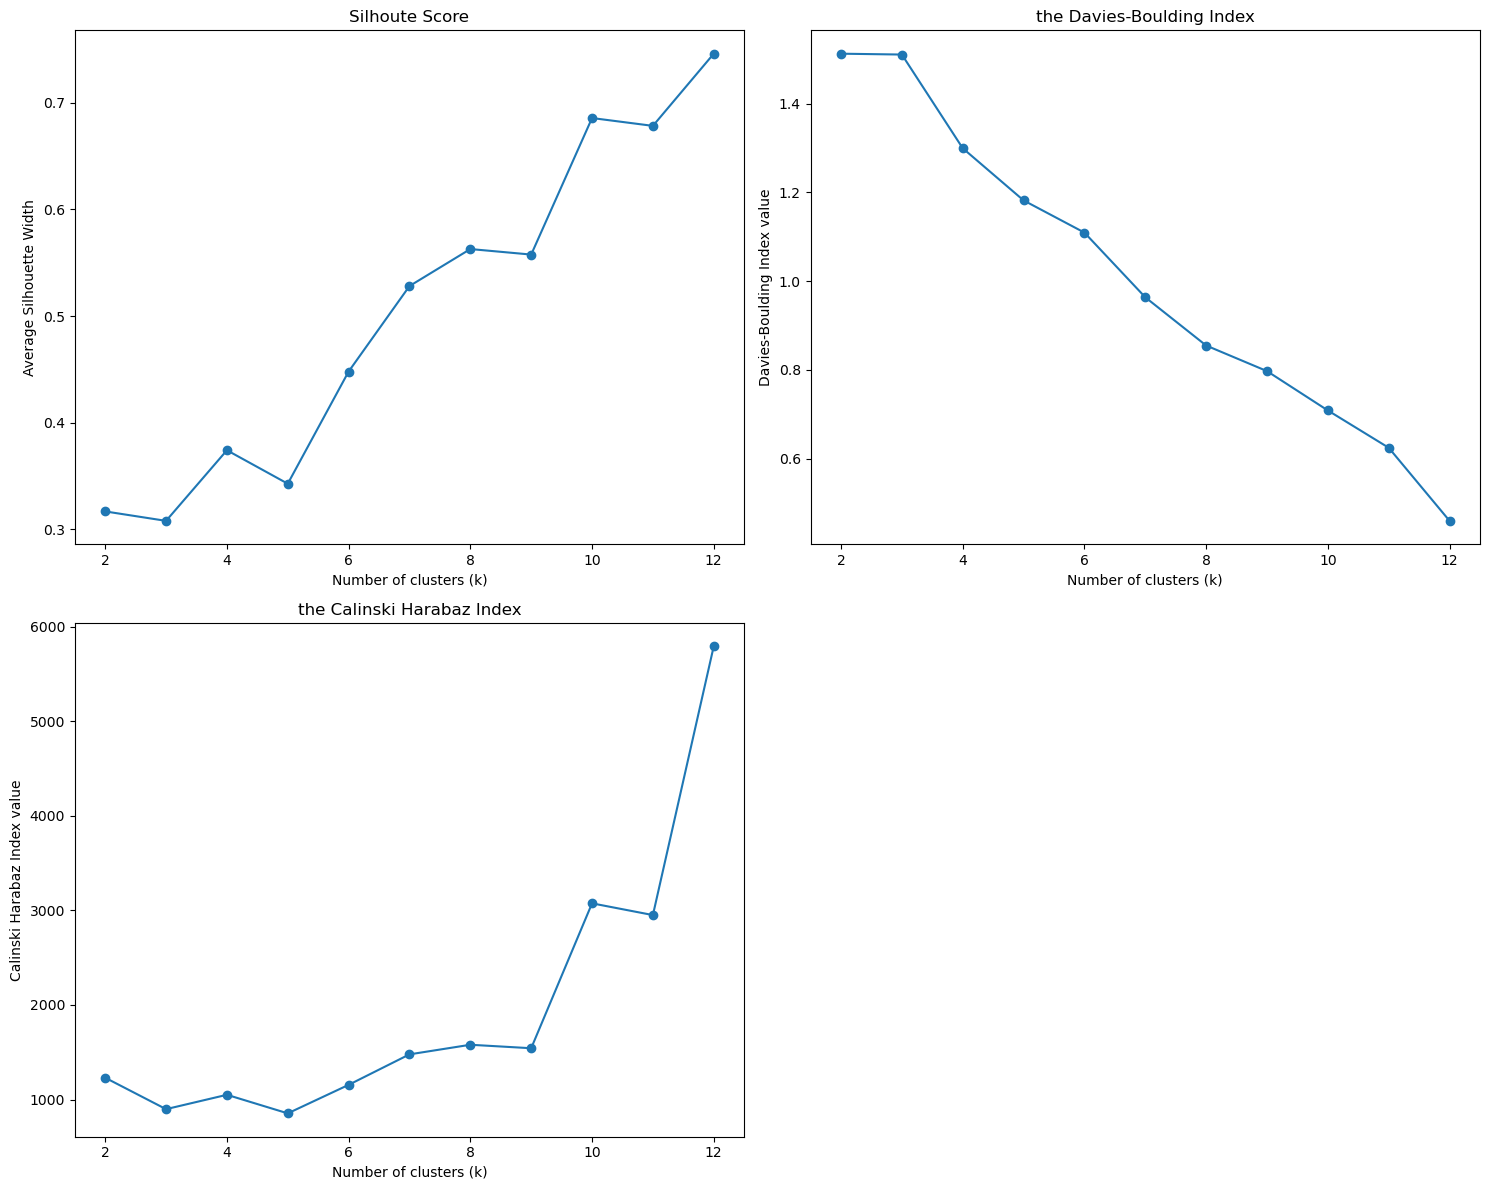

In [190]:
hier_sil(gower_matrix_2, ran = range(2,13), link = 'complete')

Number of clusters is probably 12.

In [193]:
Agg_hc_c2 = AgglomerativeClustering(n_clusters = 12, affinity = 'precomputed', linkage = 'complete').fit(gower_matrix_2)
#y_hc = Agg_hc.fit_predict(gower_matrix_4_weeks) # model fitting on the dataset

labels_c2 = Agg_hc_c2.labels_

#### **Average**

For n_clusters=2, the silhouette score is 0.3321000039577484, the Davies-Boulding Index is 1.4507, 
 the Calinski Harabaz Index is 1332.3041
For n_clusters=3, the silhouette score is 0.3077999949455261, the Davies-Boulding Index is 1.5103, 
 the Calinski Harabaz Index is 898.1505
For n_clusters=4, the silhouette score is 0.22120000422000885, the Davies-Boulding Index is 1.3098, 
 the Calinski Harabaz Index is 652.0126
For n_clusters=5, the silhouette score is 0.3260999917984009, the Davies-Boulding Index is 1.1373, 
 the Calinski Harabaz Index is 824.1222
For n_clusters=6, the silhouette score is 0.45719999074935913, the Davies-Boulding Index is 1.073, 
 the Calinski Harabaz Index is 1211.4449
For n_clusters=7, the silhouette score is 0.4219000041484833, the Davies-Boulding Index is 0.9628, 
 the Calinski Harabaz Index is 1095.7411
For n_clusters=8, the silhouette score is 0.37860000133514404, the Davies-Boulding Index is 0.8533, 
 the Calinski Harabaz Index is 963.604
For n_clusters=9

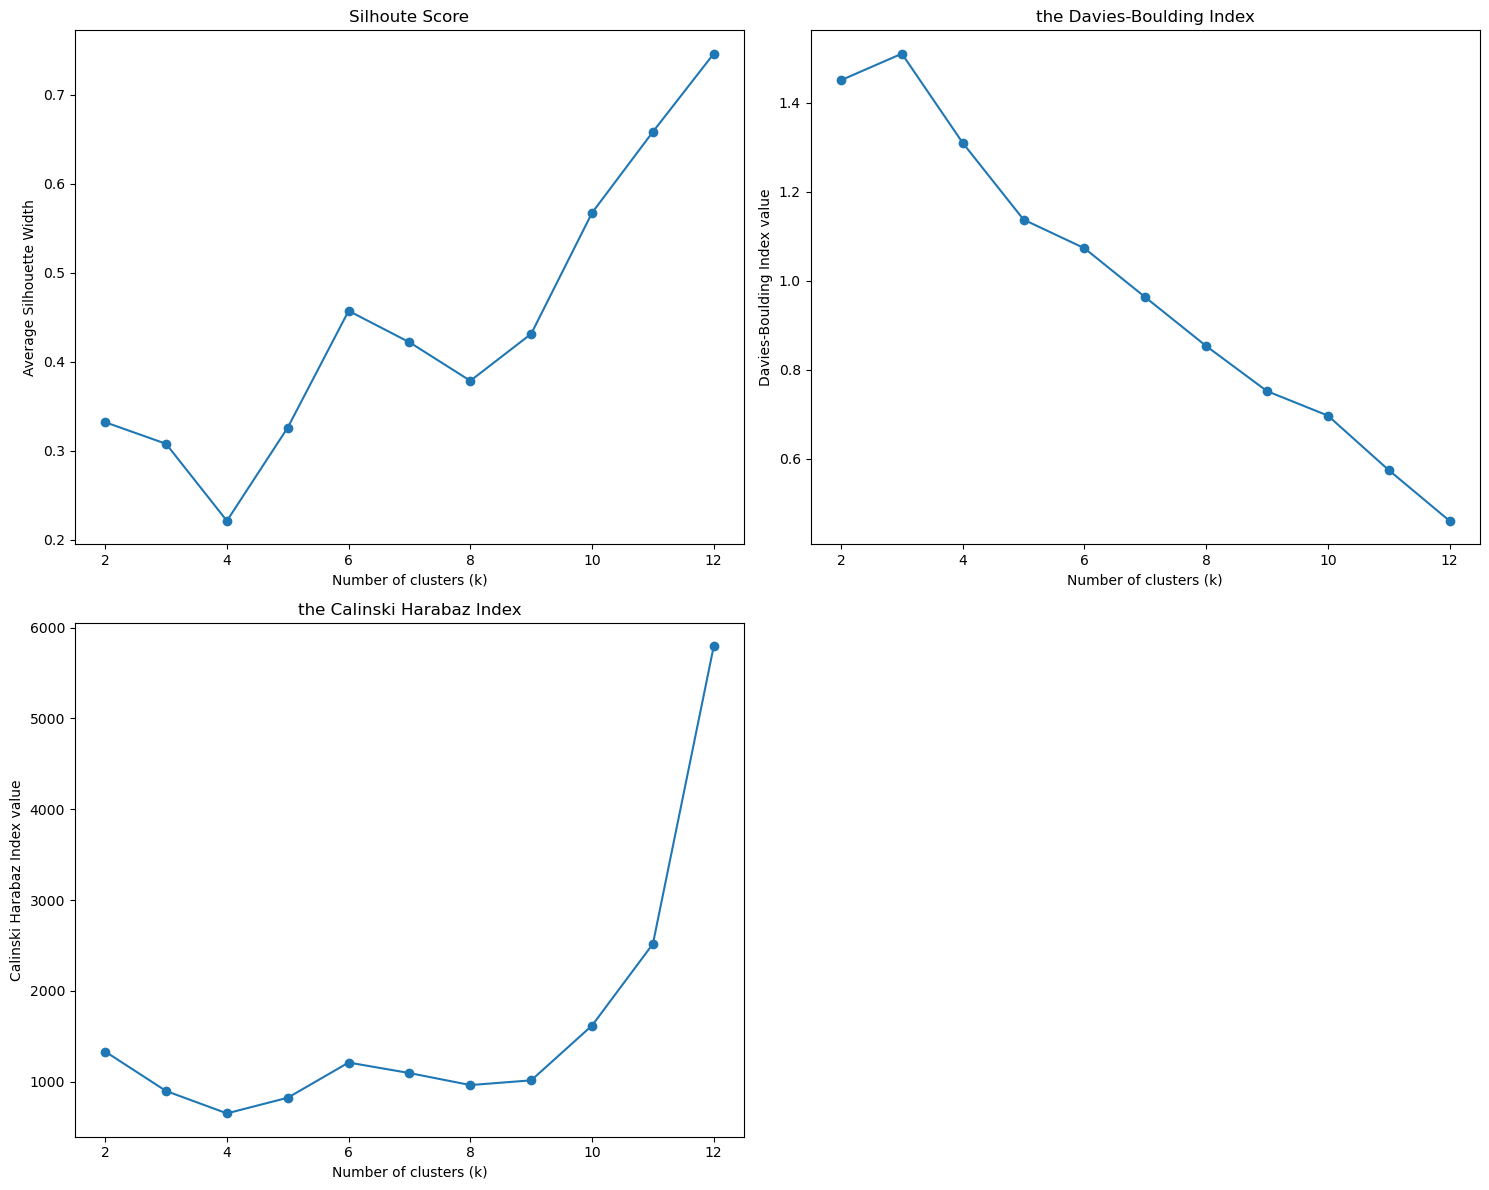

In [191]:
hier_sil(gower_matrix_2, ran = range(2,13), link = 'average')

The number of clusters is probably 12.

In [72]:
Agg_hc_a2 = AgglomerativeClustering(n_clusters = 12, affinity = 'precomputed', linkage = 'average').fit(gower_matrix_2)
#y_hc = Agg_hc.fit_predict(gower_matrix_4_weeks) # model fitting on the dataset

labels_a2 = Agg_hc_a2.labels_

#### **Summary**

Here, it doesn't matter which method we will choose, because all of them give the same results. That's why, average linkage will be chosen.

In [194]:
cluster_labels_2 = labels_c2

In [195]:
trial_data_hier2 = df_users_only_demo_clus2.copy()
trial_data_hier2["cluster"] = cluster_labels_2

Below there is a number of users in each cluster.

In [196]:
trial_data_hier2["cluster"].value_counts()

2     711
7     451
9     435
5     327
0     283
11    223
8     206
4     155
1     125
3      59
10     41
6      18
Name: cluster, dtype: int64

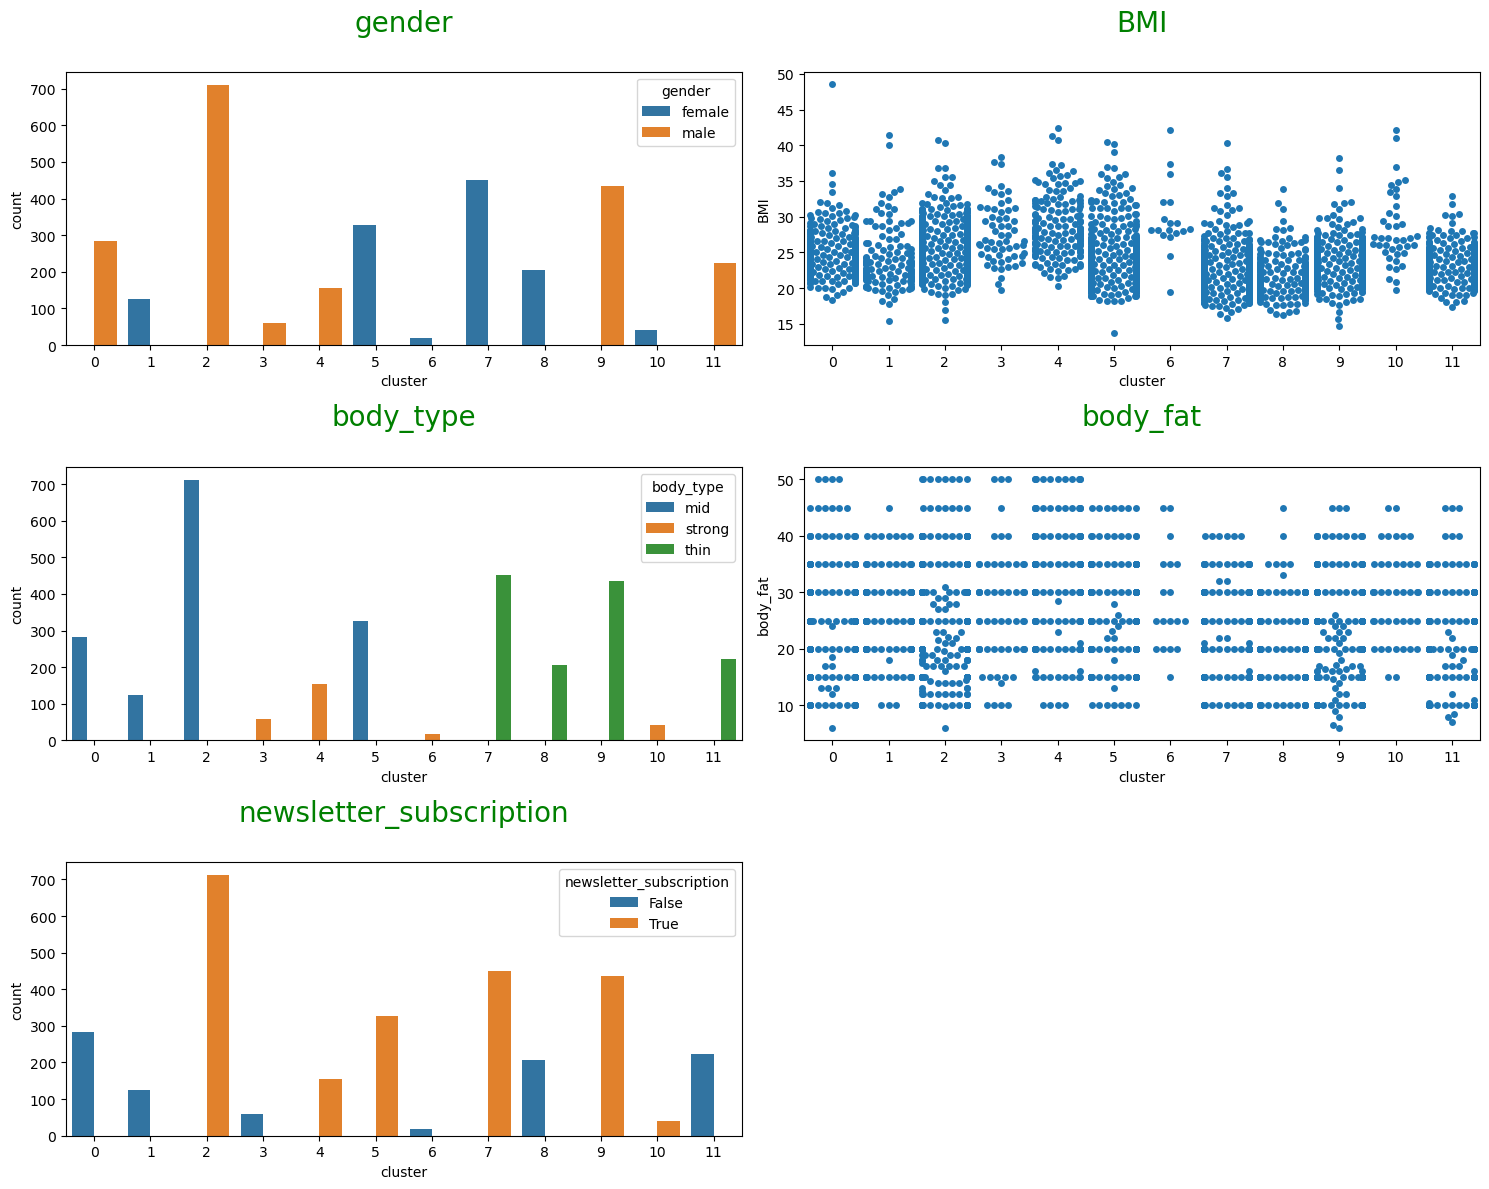

In [198]:
clus_plot(trial_data_hier2, cat_cols = ['gender', 'body_type', 'newsletter_subscription'], 
          num_cols = ['BMI', 'body_fat'])

The description of the cluster could be as follow:

* **Cluster 0** - mid men with newsletter subscription, average to high BMI and all levels of body fat,
* **Cluster 1** - mid men without newsletter subscription, average to high BMI and all levels of body fat,
* **Cluster 2** - thin women with newsletter subscription, lower to medium BMI and mostly low to medium body fat,
* **Cluster 3** - female with mid body type, no newsletter subscription, average BMI and average body fat,
* **Cluster 4** - strong women without newsletter subscription, high BMI and average to high body fat,
* **Cluster 5** - men with thin body type, newsletter subscription, low to medium BMI and low to evenly distributed body fat,
* **Cluster 6** - men with strong body type, newsletter subscription, rather big BMI and evenly distributed body fat,
* **Cluster 7** - women with strong body type, newsletter subscription, rather average big BMI and medium body fat,
* **Cluster 8** - men with strong body type, no newsletter subscription, average to high BMI and evenly distributed body fat,
* **Cluster 9** - women with mid body type, newsletter subscription, low to high BMI and evenly distributed average body fat,
* **Cluster 10** - thin men, no newsletter subscription, low to average BMI and average to lower body fat,
* **Cluster 11** - thin women without newsletter subscription, low to average BMI and low to average body fat.

### **K-prototypes**

In [199]:
df_kpro2 = df_users_only_demo_clus_enc2.copy()

In [200]:
categorical_cols = ['gender', 'body_type', 'newsletter_subscription']

For n_clusters=2, method: Huang, the silhouette score is 0.5301
For n_clusters=2, method: Cao, the silhouette score is 0.5301
For n_clusters=3, method: Huang, the silhouette score is 0.462
For n_clusters=3, method: Cao, the silhouette score is 0.462
For n_clusters=4, method: Huang, the silhouette score is 0.4333
For n_clusters=4, method: Cao, the silhouette score is 0.4333
For n_clusters=5, method: Huang, the silhouette score is 0.4146
For n_clusters=5, method: Cao, the silhouette score is 0.4146
For n_clusters=6, method: Huang, the silhouette score is 0.4095
For n_clusters=6, method: Cao, the silhouette score is 0.3682
For n_clusters=7, method: Huang, the silhouette score is 0.4229
For n_clusters=7, method: Cao, the silhouette score is 0.4167
For n_clusters=8, method: Huang, the silhouette score is 0.4318
For n_clusters=8, method: Cao, the silhouette score is 0.4281
For n_clusters=9, method: Huang, the silhouette score is 0.3654
For n_clusters=9, method: Cao, the silhouette score is 0

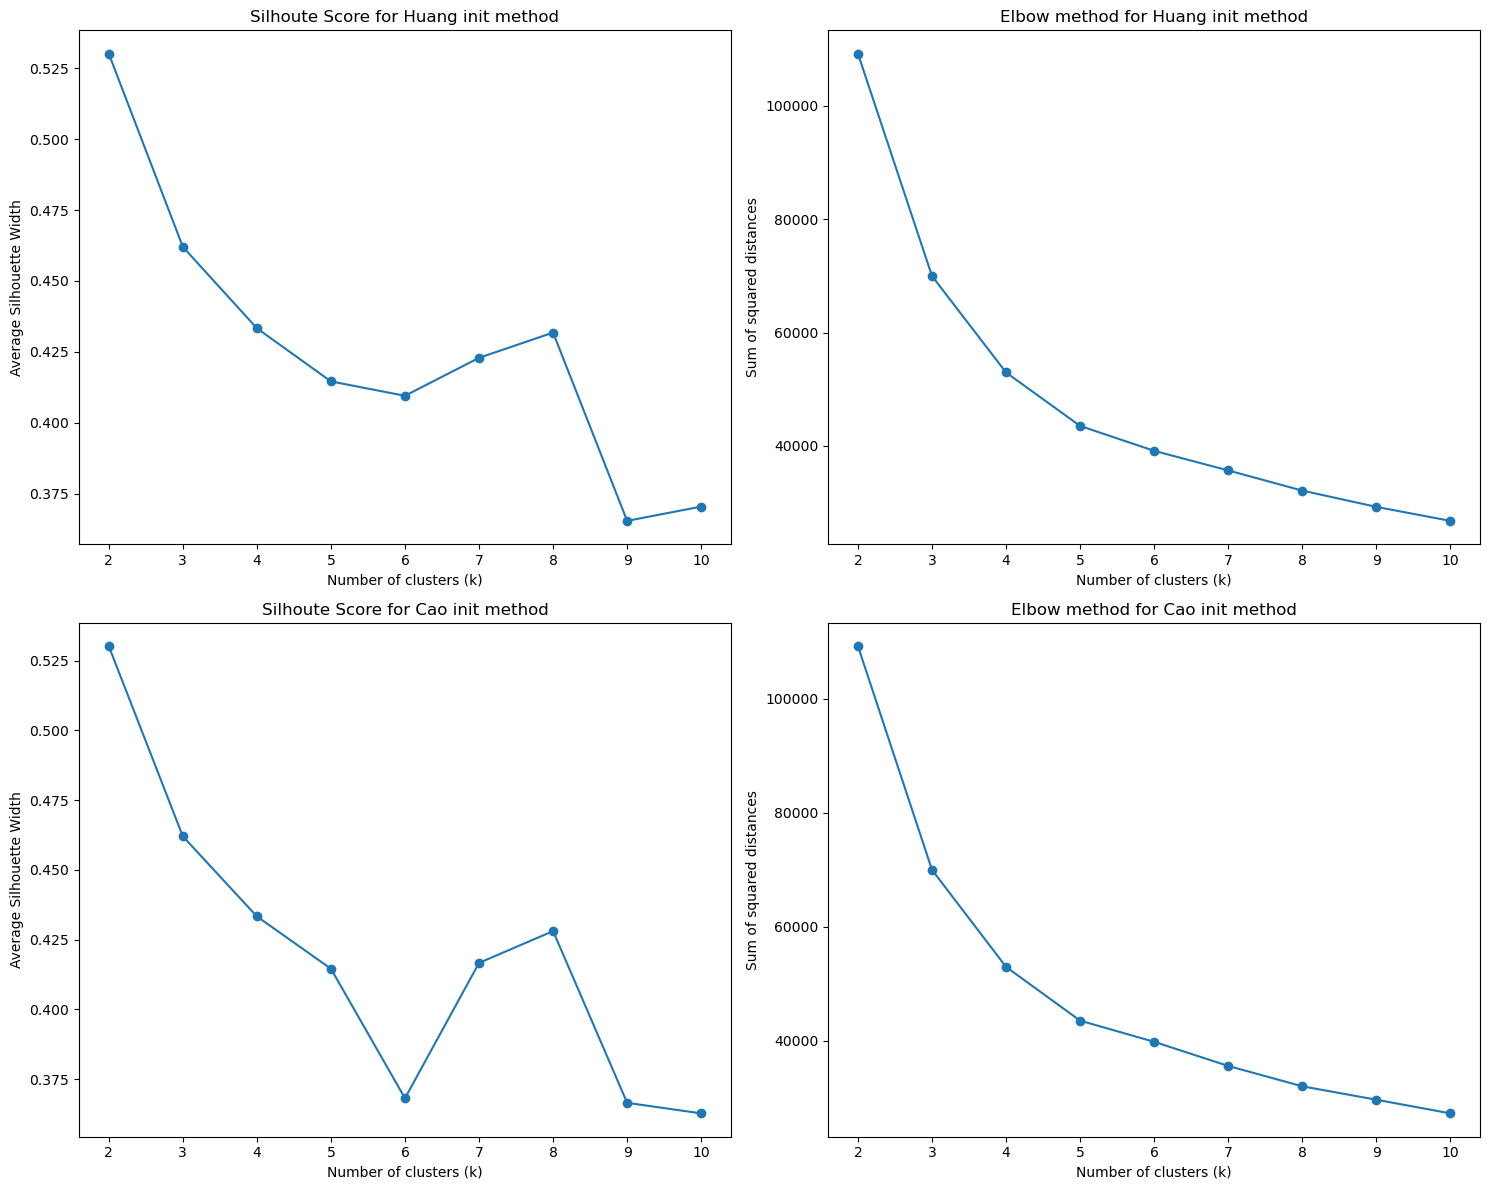

In [201]:
kpro_sil_elbow(df_kpro2, categorical_cols, ran = range(2,11))

In [202]:
kproto2 = KPrototypes(n_clusters=2, init='Huang')
clusters2 = kproto2.fit_predict(df_kpro2, categorical=[0, 2,4])

labels2 = pd.DataFrame(clusters2)
labels2.rename(columns = {0: 'cluster'}, inplace = True)

df_kpro2.reset_index(inplace = True, drop = True)

labeled_data2 = pd.concat((df_users_only_demo_clus2.reset_index(drop = True), labels2),axis=1)

In [203]:
davies_bouldin_score(df_kpro2, labeled_data2['cluster'])

0.6895074128041444

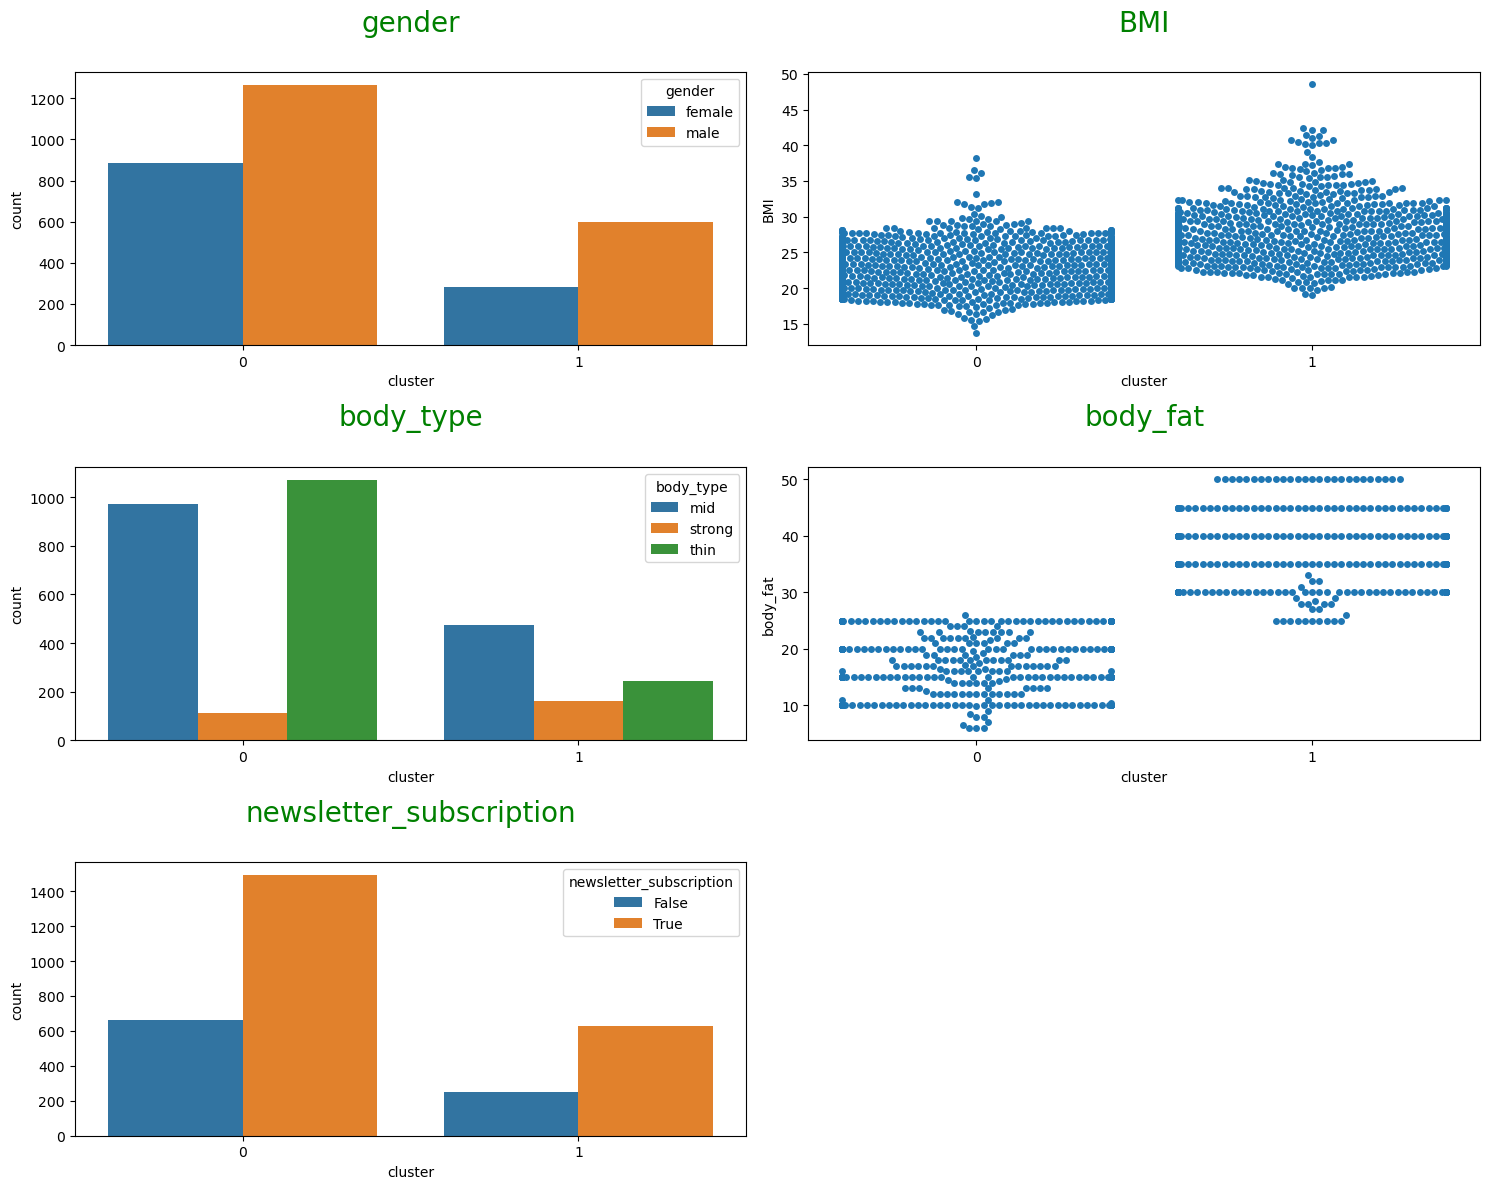

In [205]:
clus_plot(labeled_data2, cat_cols = categorical_cols, 
          num_cols = ['BMI', 'body_fat'])

The description of the cluster could be as follow:

* **Cluster 0** - thin and mid men and women, mostly with newsletter subscription, lower to average BMI and lower to average to high body fat,
* **Cluster 1** - mid, strong and thin men and women, mostly with newsletter subscription, average to high BMI and rather hight body fat.

#### **Scaled data**

In [83]:
df_kpro_sca2 = df_kpro2.copy()

In [84]:
numerical_columns2 = ['BMI', 'body_fat']

In [85]:
scaler = StandardScaler()

# standard scale numerical features
for c in numerical_columns2:
    df_kpro_sca2[c] = scaler.fit_transform(df_kpro_sca2[[c]])

Again, we check hopkins score, it is better than before.

In [86]:
hopkins(df_kpro_sca2)

0.9502710875285747

For n_clusters=2, method: Huang, the silhouette score is 0.3012
For n_clusters=2, method: Cao, the silhouette score is 0.3012
For n_clusters=3, method: Huang, the silhouette score is 0.211
For n_clusters=3, method: Cao, the silhouette score is 0.2073
For n_clusters=4, method: Huang, the silhouette score is 0.1894
For n_clusters=4, method: Cao, the silhouette score is 0.1894
For n_clusters=5, method: Huang, the silhouette score is 0.1567
For n_clusters=5, method: Cao, the silhouette score is 0.1728
For n_clusters=6, method: Huang, the silhouette score is 0.1352
For n_clusters=6, method: Cao, the silhouette score is 0.1491
For n_clusters=7, method: Huang, the silhouette score is 0.1461
For n_clusters=7, method: Cao, the silhouette score is 0.1438
For n_clusters=8, method: Huang, the silhouette score is 0.1302
For n_clusters=8, method: Cao, the silhouette score is 0.1434
For n_clusters=9, method: Huang, the silhouette score is 0.1591
For n_clusters=9, method: Cao, the silhouette score is 

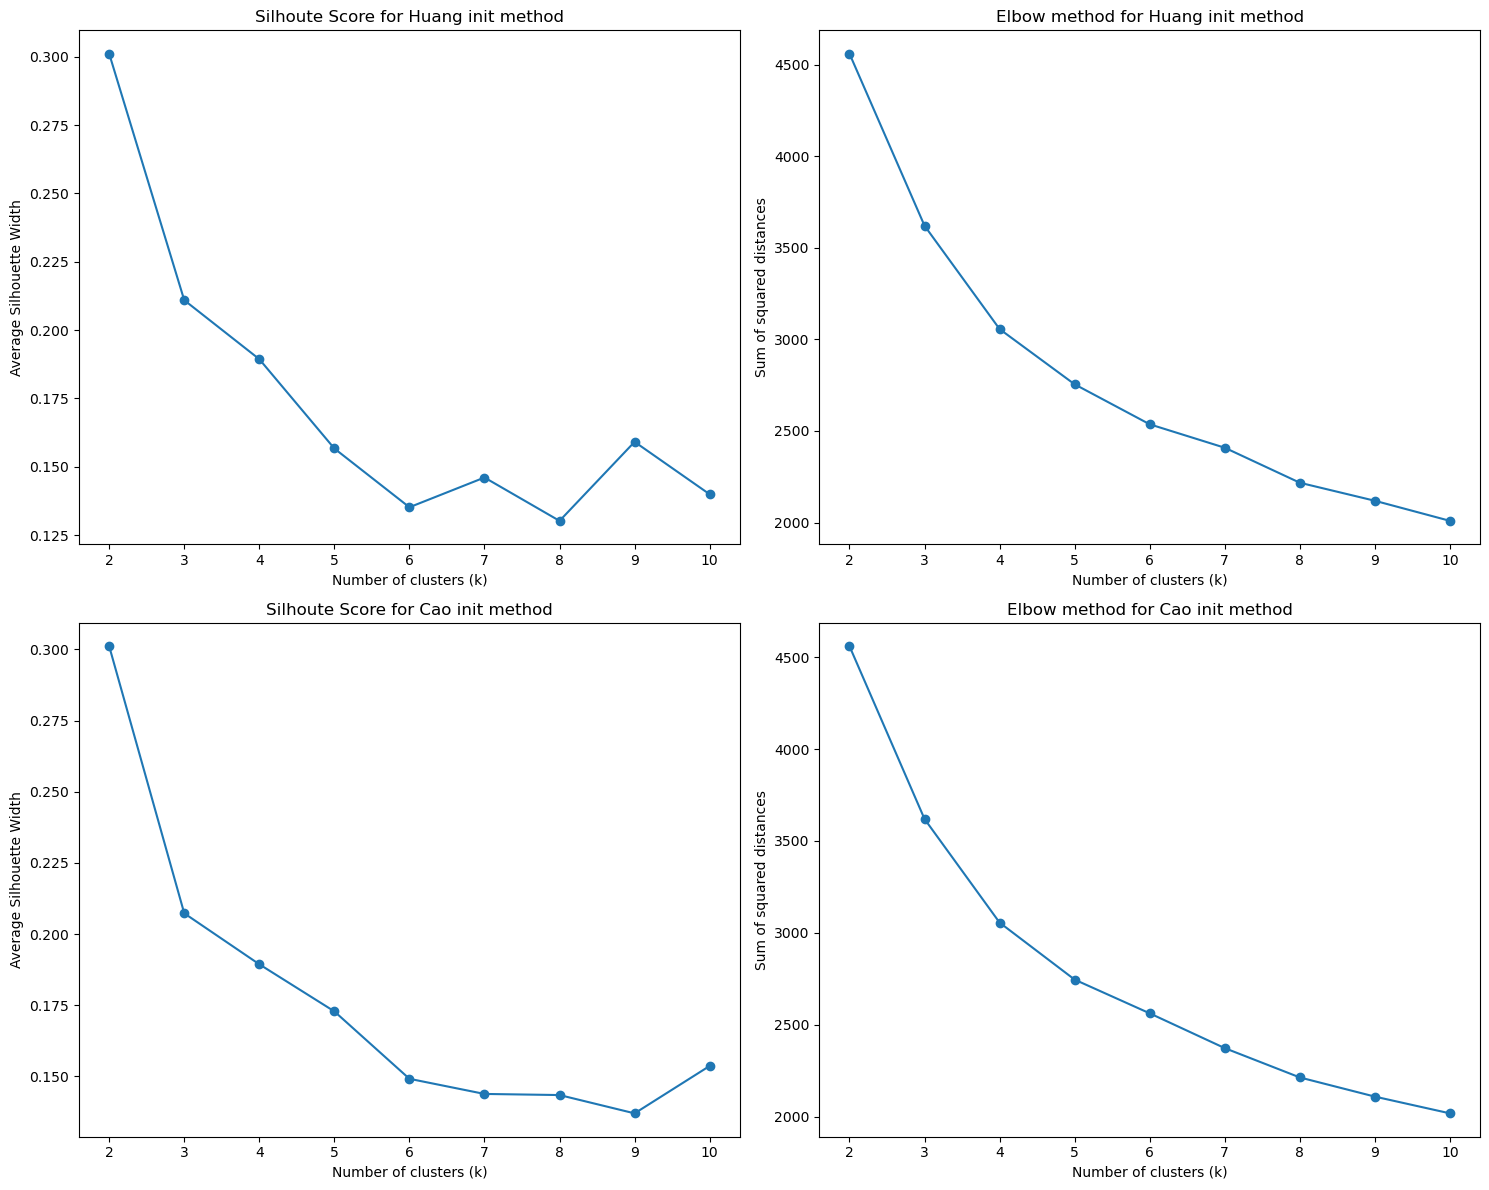

In [87]:
kpro_sil_elbow(df_kpro_sca2, categorical_cols, ran = range(2,11))

The probable number of clusters is 2, but the silhouette score is pretty low, so the clusterization won't be too good.

In [88]:
kproto_sca2 = KPrototypes(n_clusters=2, init='Huang')
clusters_sca2 = kproto_sca2.fit_predict(df_kpro_sca2, categorical=[0, 2,4])

labels_sca2 = pd.DataFrame(clusters_sca2)
labels_sca2.rename(columns = {0: 'cluster'}, inplace = True)

In [89]:
labeled_data_sca2 = pd.concat((df_users_only_demo_clus2.reset_index(drop = True),labels_sca2),axis=1)

In [90]:
labeled_data_sca2['cluster'].value_counts()

0    2004
1    1030
Name: cluster, dtype: int64

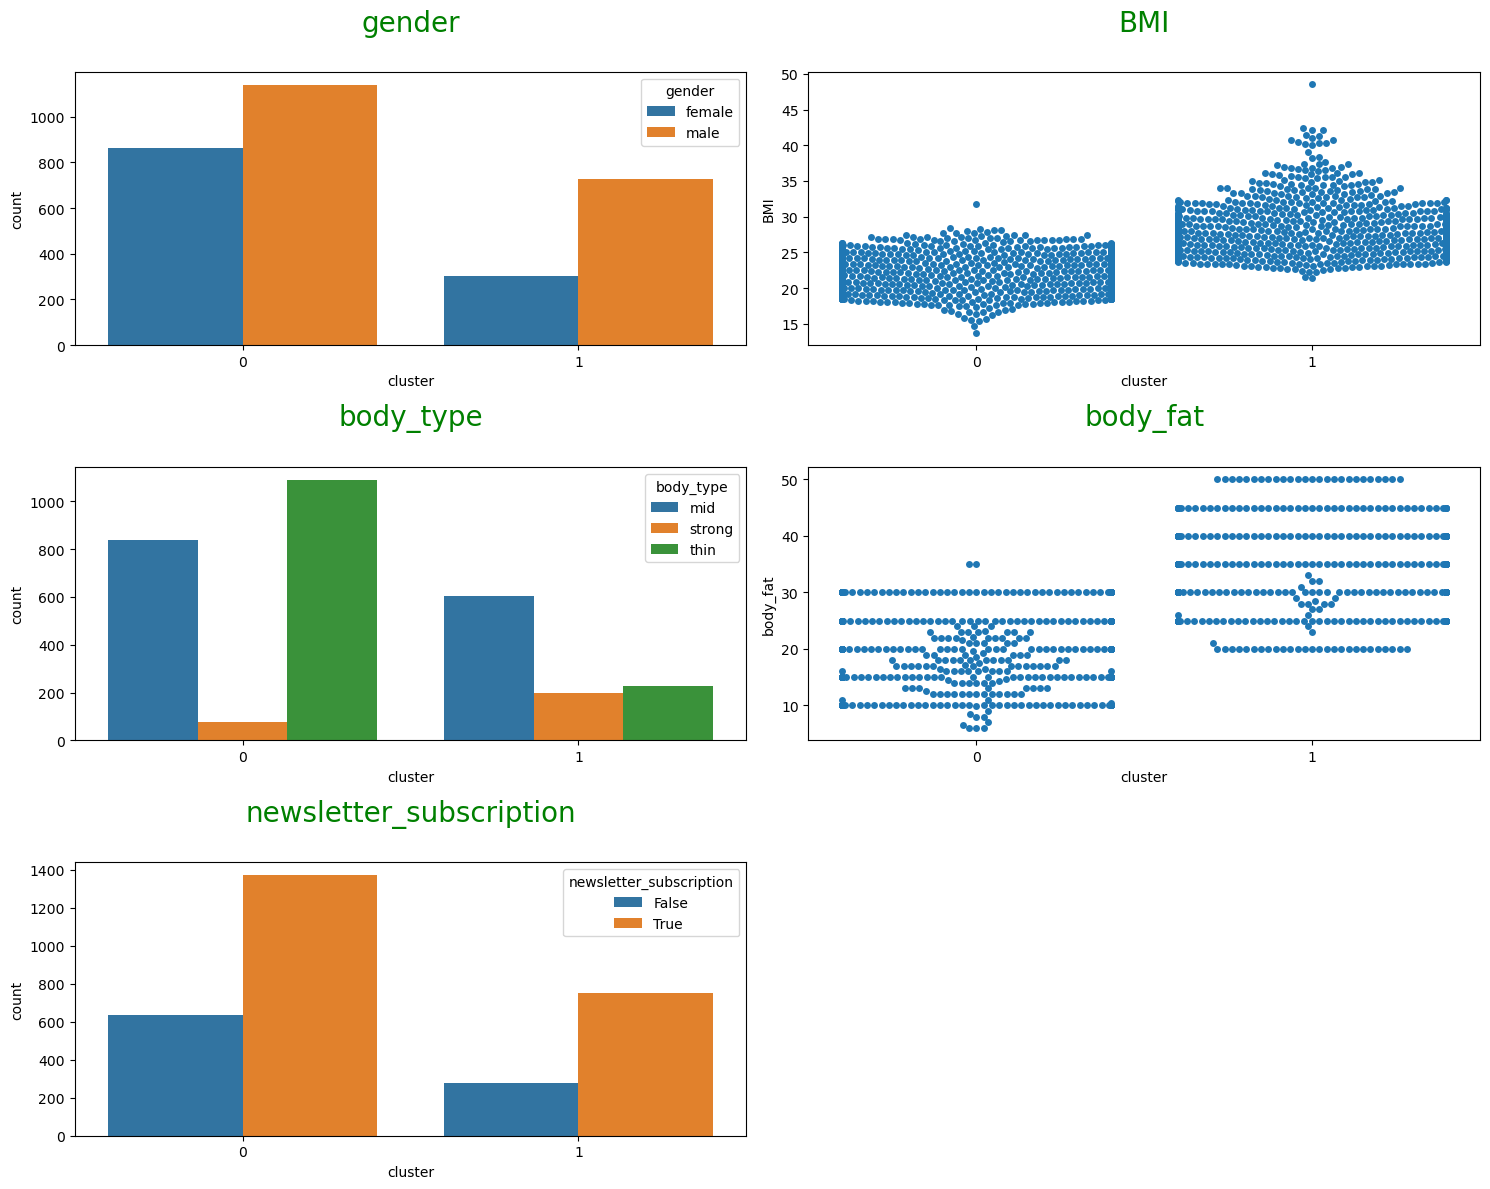

In [91]:
clus_plot(labeled_data_sca2, cat_cols = ['gender', 'body_type', 'newsletter_subscription'], 
          num_cols = ['BMI', 'body_fat'])

The description of the cluster could be as follow:

* **Cluster 0** - mostly men with mostly mid body type, newsletter subscription, average to high BMI and high body fat,
* **Cluster 1** - thin and mid men and women mostly with newsletter subscription, low to average BMI and low to average body fat.

### **Summary**

In [206]:
# data into summary table
data2 = {'Name of algorithm' : ['PAM', 'hierarchial clustering (average linkage)', 
                               'K-prototypes'],
        'Number of clusters (k)' : [10, 12, 2],
        'Silhouette score' : [silhouette_score(gower_matrix_2, trial_data2['cluster']),
                              silhouette_score(gower_matrix_2, trial_data_hier2["cluster"]),
                              silhouette_score(df_kpro2, labeled_data2["cluster"])
                              ],
        'Calinski Harabaz Index' : [calinski_harabasz_score(gower_matrix_2, trial_data2['cluster']),
                                    calinski_harabasz_score(gower_matrix_2, trial_data_hier2["cluster"]),
                                    calinski_harabasz_score(df_kpro2, labeled_data2["cluster"])
                                   ],
        'Davies Bouldin Index' : [davies_bouldin_score(gower_matrix_2, trial_data2['cluster']),
                                  davies_bouldin_score(gower_matrix_2, trial_data_hier2["cluster"]),
                                  davies_bouldin_score(df_kpro2, labeled_data2["cluster"])
                                 ]}


In [207]:
summary_tab2 = pd.DataFrame(data2)
summary_tab2.set_index(['Name of algorithm'], inplace = True)


In [208]:
summary_tab2

Number of clusters (k)  \
Name of algorithm                                                  
PAM                                                           10   
hierarchial clustering (average linkage)                      12   
K-prototypes                                                   2   

                                          Silhouette score  \
Name of algorithm                                            
PAM                                                   0.74   
hierarchial clustering (average linkage)              0.75   
K-prototypes                                          0.53   

                                          Calinski Harabaz Index  \
Name of algorithm                                                  
PAM                                                      4951.49   
hierarchial clustering (average linkage)                 5794.67   
K-prototypes                                             4348.69   

                                          Davies Bouldin Index  
Name of algorithm                                               
PAM                                                       0.60  
hierarchial clustering (average linkage)                  0.46  
K-prototypes                                              0.69

Here the best one is hierarchical clustering with average linkage.

## **Variables gender, body_type, newsletter_subscription, height and weight**

Now, we're going to do exactly the same as before, but we'll take into consideration fewer variables:
* gender,
* weight,
* height,
* body_type and
* newsletter_subscription.

In [209]:
df_users_only_demo_clus3 = df_users_only_demo_clus.loc[:, ['gender', 'height', 'weight',
       'body_type', 'newsletter_subscription']]

df_users_only_demo_clus_enc3 = df_users_only_demo_clus3.copy()

for col in ['gender', 'body_type', 'newsletter_subscription']:
    df_users_only_demo_clus_enc3[col] = LabelEncoder().fit_transform(df_users_only_demo_clus_enc3[col])



For PAM method and hierarchical clustering, we need to create matrix with dissimilarity gower distances. 

In [210]:
gower_matrix_3 = gower.gower_matrix(df_users_only_demo_clus_enc3, cat_features = [True, False, False, True, True])


The hopkins score is very good, so we can proceed with the clusterization.

In [211]:
hopkins(pd.DataFrame(gower_matrix_3))

0.9922900484390182

### **PAM**

First, we will do PAM method.

For n_clusters=2, the silhouette score is 0.3822999894618988, the Davies-Boulding Index is 1.1879, 
 the Calinski Harabaz Index is 1903.9296
For n_clusters=3, the silhouette score is 0.41499999165534973, the Davies-Boulding Index is 1.0641, 
 the Calinski Harabaz Index is 1840.9196
For n_clusters=4, the silhouette score is 0.4300000071525574, the Davies-Boulding Index is 0.9362, 
 the Calinski Harabaz Index is 1785.7554
For n_clusters=5, the silhouette score is 0.5189999938011169, the Davies-Boulding Index is 0.8762, 
 the Calinski Harabaz Index is 2314.3416
For n_clusters=6, the silhouette score is 0.5715000033378601, the Davies-Boulding Index is 0.6942, 
 the Calinski Harabaz Index is 2684.5426
For n_clusters=7, the silhouette score is 0.6484000086784363, the Davies-Boulding Index is 0.5567, 
 the Calinski Harabaz Index is 3666.8646
For n_clusters=8, the silhouette score is 0.70169997215271, the Davies-Boulding Index is 0.5675, 
 the Calinski Harabaz Index is 4140.1007
For n_clusters

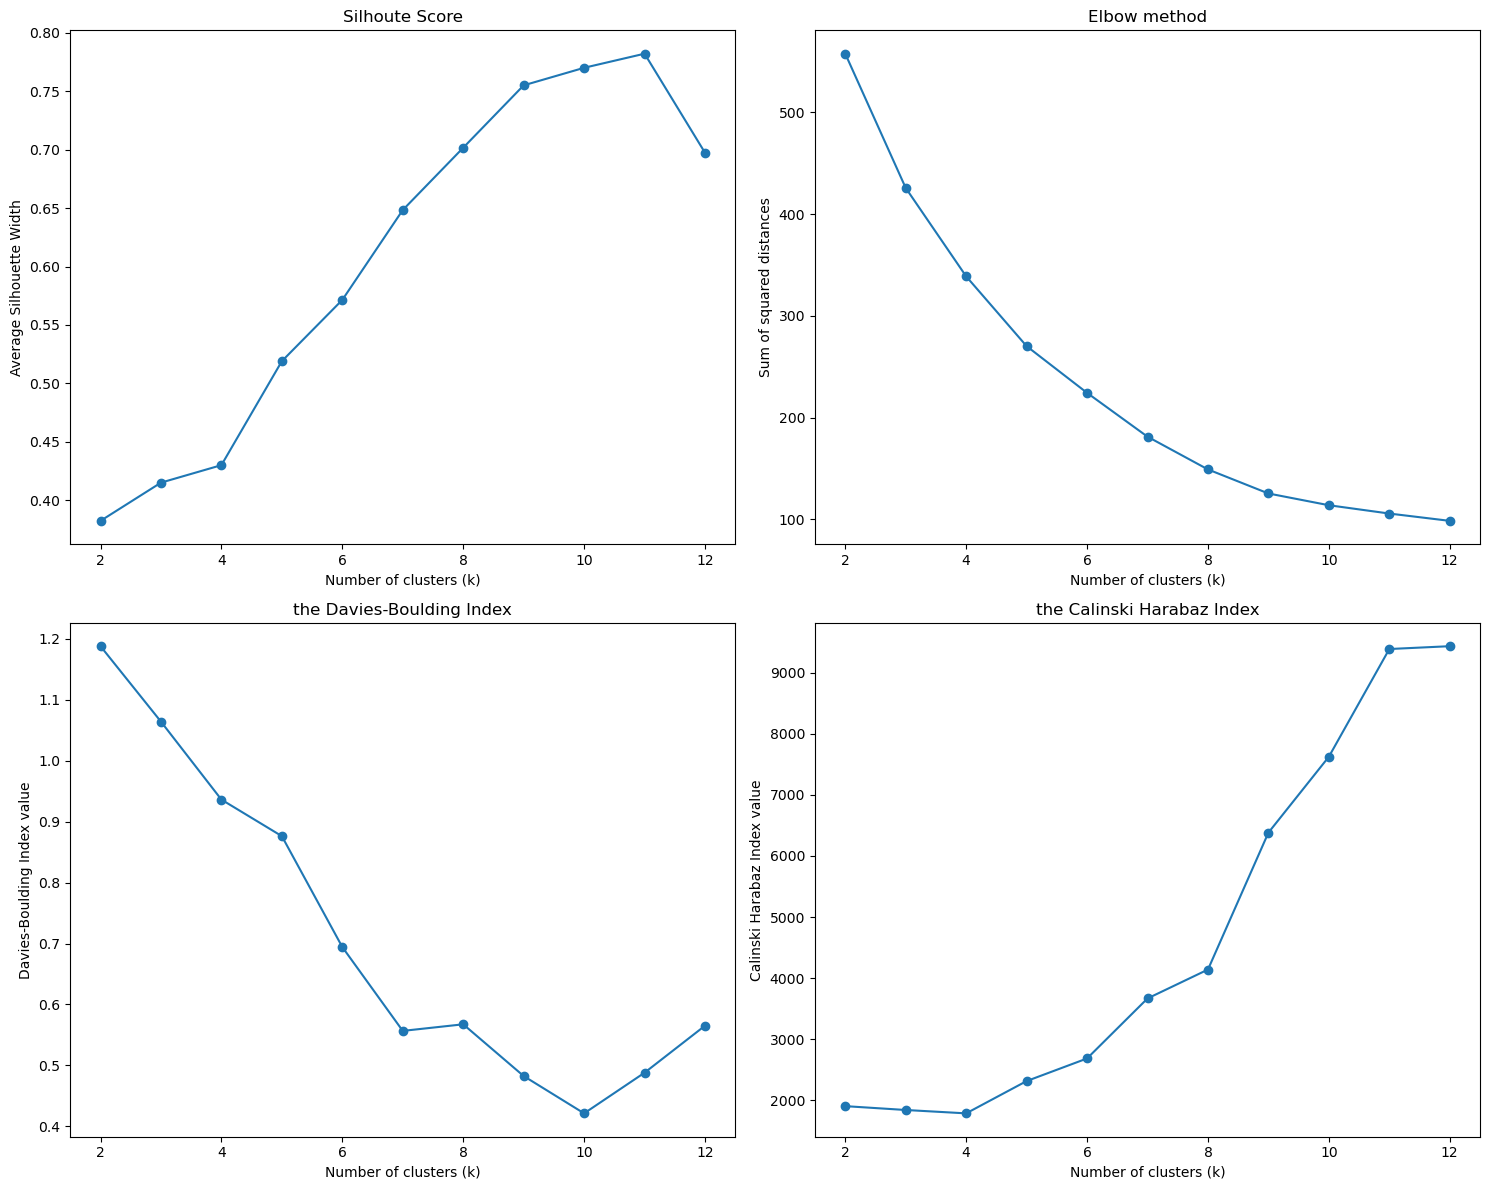

In [212]:
pam_sil_elbow(gower_matrix_3, range(2,13))

The number of clusters is 11. So we fit the model to the data and predict the cluster values.

In [213]:
km_model3 = KMedoids(n_clusters = 11, random_state = 42, metric = 'precomputed', method = 'pam', 
                            init =  'k-medoids++')
km_model3.fit(gower_matrix_3)
km_model3.predict(gower_matrix_3)

array([2, 0, 3, ..., 9, 4, 1])

And now, we add the labels to the dataset.

In [214]:
trial_data3 = df_users_only_demo_clus3.copy()

trial_data3['cluster'] = km_model3.labels_

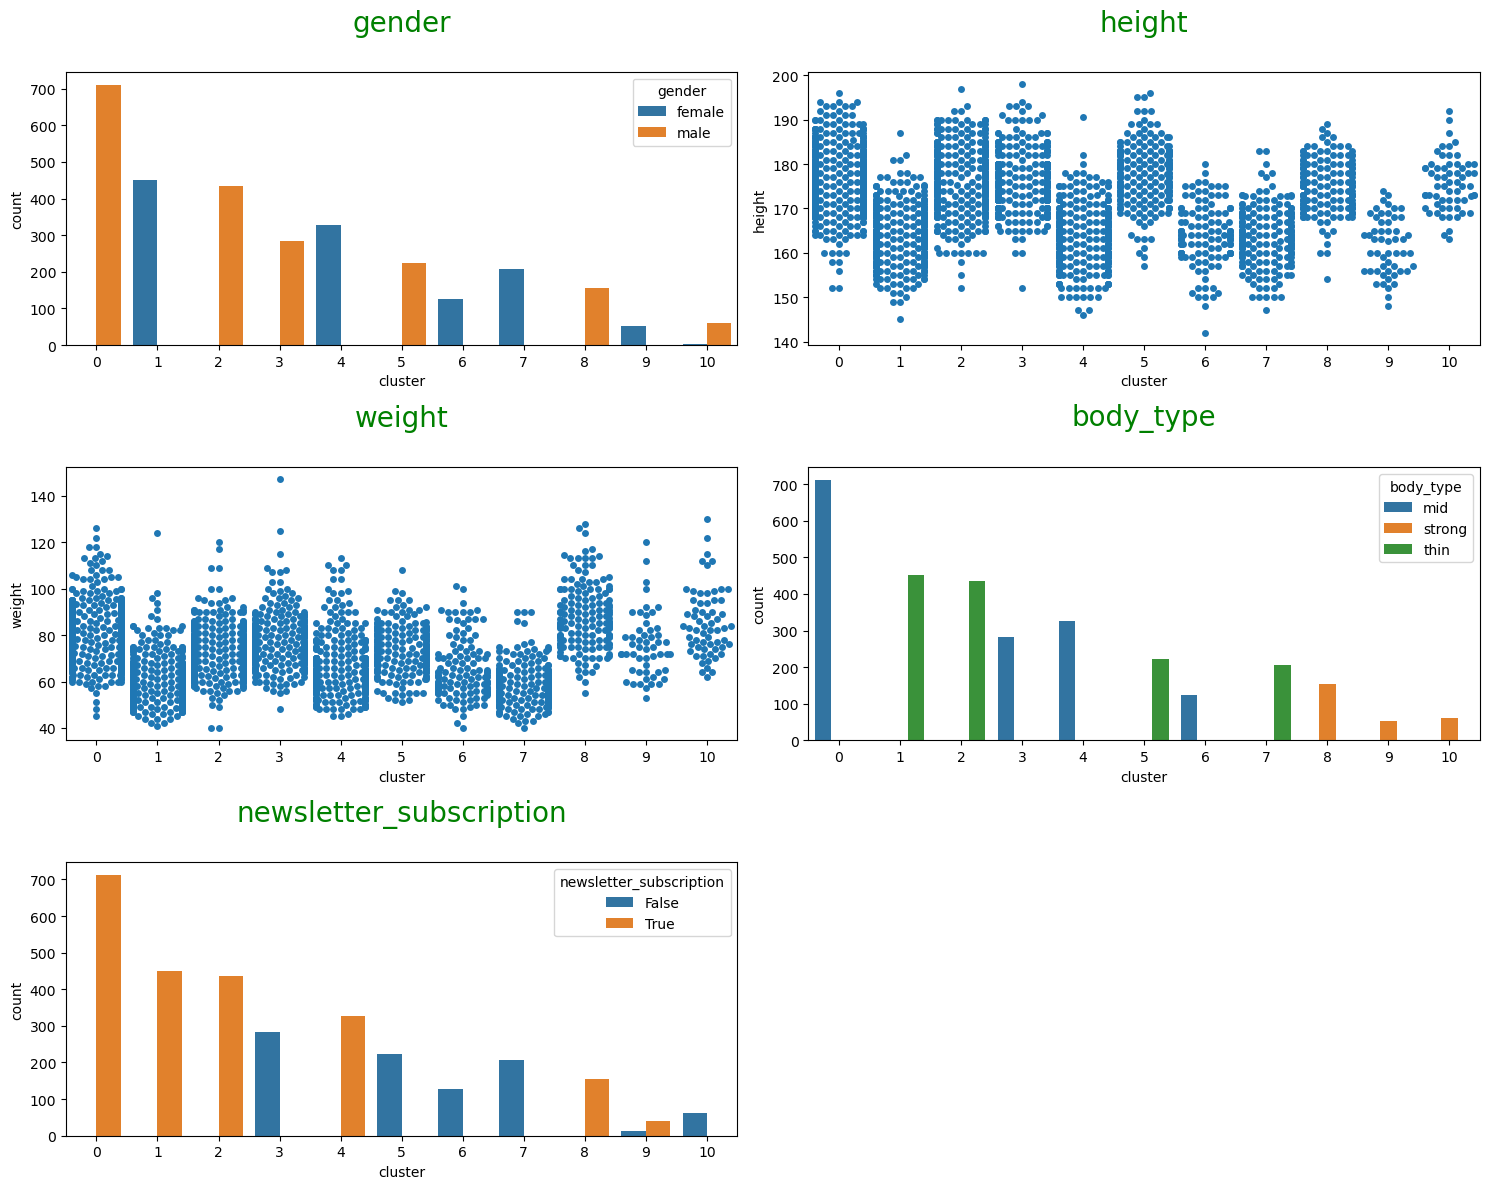

In [215]:
clus_plot(trial_data3, cat_cols = ['gender', 'body_type', 'newsletter_subscription'], 
          num_cols = ['height', 'weight'])

The description of the cluster could be as follow:

* **Cluster 0** - strong men without newsletter subscription, average to higher height and average to high weight,
* **Cluster 1** - mid women with newsletter subscription, medium to lower height and low to average weight,
* **Cluster 2** - men with thin body type with newsletter subscription, tall and medium and high weight,
* **Cluster 3** - female with thin body type, newsletter subscription, lower to medium height and lower weight,
* **Cluster 4** - men with mid body type, newsletter subscription, tall and, average to big weight,
* **Cluster 5** - women with thin body type, no newsletter subscription, shorter to average height and low weight,
* **Cluster 6** - mid men with no newsletter subscription, average to tall height and average to high weight,
* **Cluster 7** - strong men with newsletter subscription, average to tall height and medium weight,
* **Cluster 8** - men with thin body type without newsletter subscription, medium to tall height and low to average weight,
* **Cluster 9** - women with mid body type, no newsletter subscription, average height and low to medium weight,
* **Cluster 10** - women with strong body type without newsletter subscription, rather average height and average weight.

### **Hierarchical clustering**

#### **Single**

For n_clusters=2, the silhouette score is 0.1906999945640564, the Davies-Boulding Index is 0.7973, 
 the Calinski Harabaz Index is 35.6779
For n_clusters=3, the silhouette score is 0.03759999945759773, the Davies-Boulding Index is 0.8987, 
 the Calinski Harabaz Index is 61.0421
For n_clusters=4, the silhouette score is -0.0771000012755394, the Davies-Boulding Index is 1.005, 
 the Calinski Harabaz Index is 55.2311
For n_clusters=5, the silhouette score is 0.028699999675154686, the Davies-Boulding Index is 0.878, 
 the Calinski Harabaz Index is 181.4212
For n_clusters=6, the silhouette score is 0.22930000722408295, the Davies-Boulding Index is 0.7403, 
 the Calinski Harabaz Index is 461.4598
For n_clusters=7, the silhouette score is 0.3513999879360199, the Davies-Boulding Index is 0.692, 
 the Calinski Harabaz Index is 673.0128
For n_clusters=8, the silhouette score is 0.4239000082015991, the Davies-Boulding Index is 0.6145, 
 the Calinski Harabaz Index is 849.3453
For n_clusters=9, the

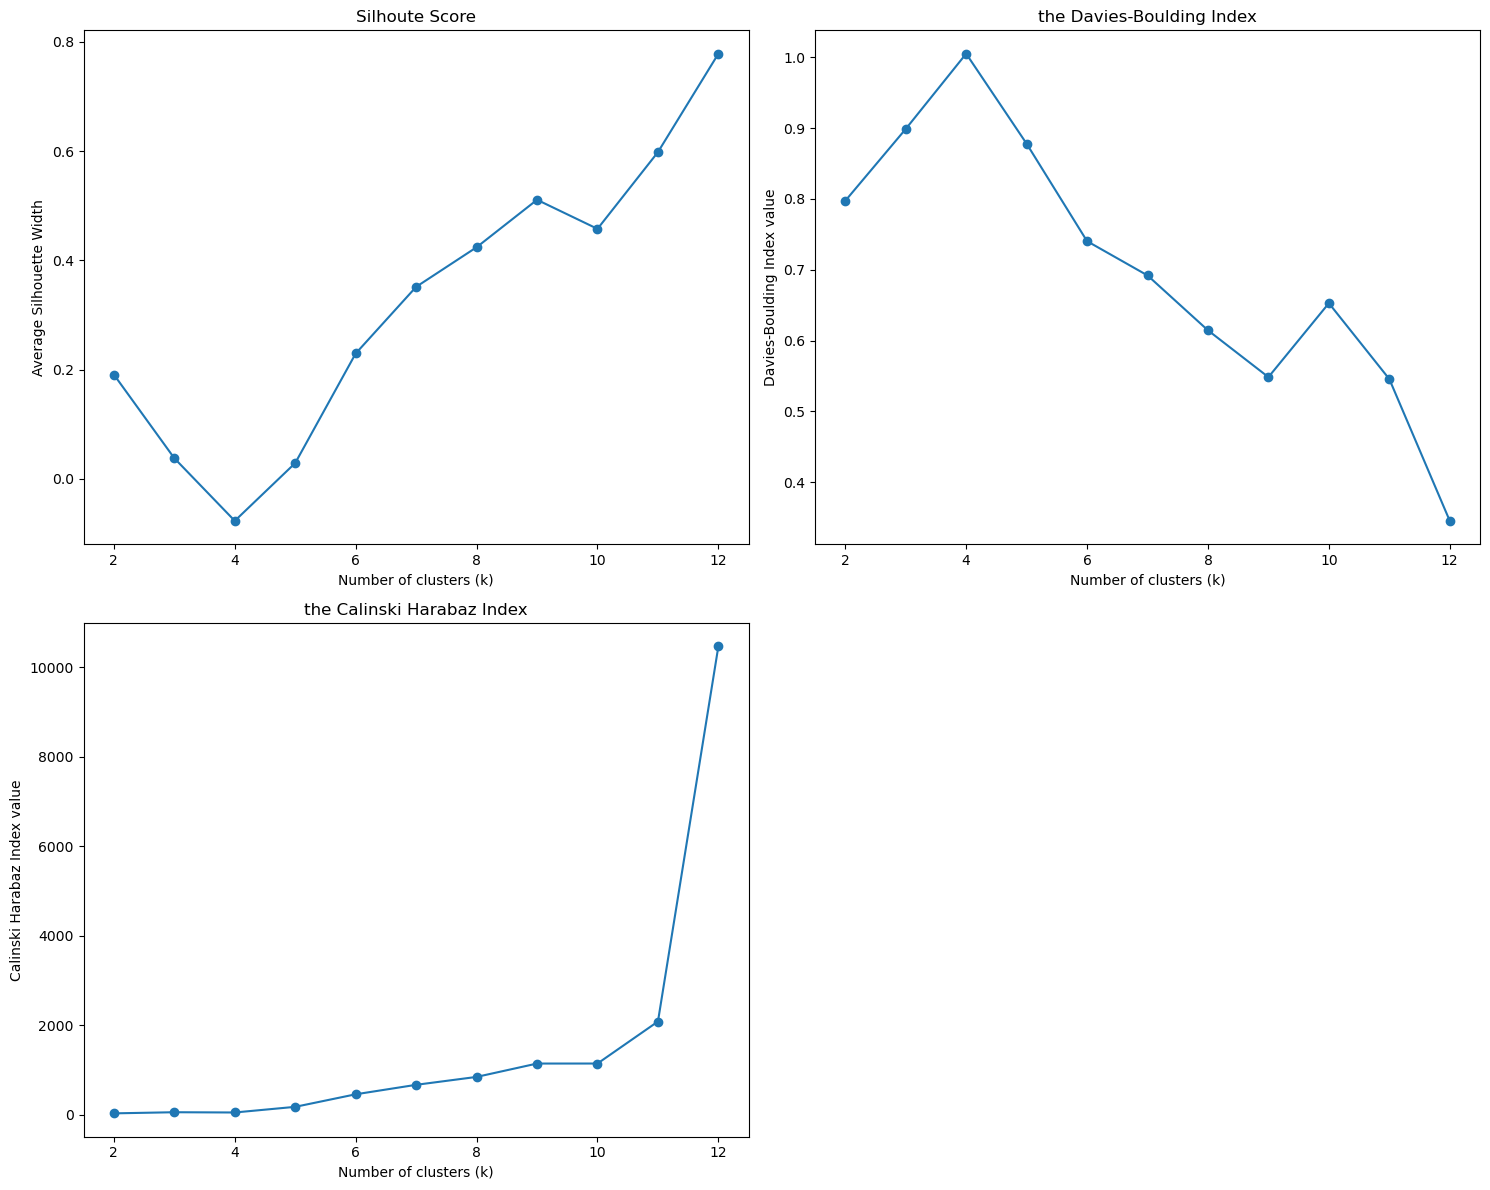

In [216]:
hier_sil(gower_matrix_3, ran = range(2,13), link = 'single')

Number of clusters is probably 12.

In [103]:
Agg_hc3 = AgglomerativeClustering(n_clusters = 12, affinity = 'precomputed', linkage = 'single').fit(gower_matrix_3)
#y_hc = Agg_hc.fit_predict(gower_matrix_4_weeks) # model fitting on the dataset

labels3 = Agg_hc3.labels_

#### **Complete**

For n_clusters=2, the silhouette score is 0.43630000948905945, the Davies-Boulding Index is 1.0907, 
 the Calinski Harabaz Index is 2294.7794
For n_clusters=3, the silhouette score is 0.4560999870300293, the Davies-Boulding Index is 0.9647, 
 the Calinski Harabaz Index is 2184.833
For n_clusters=4, the silhouette score is 0.4950000047683716, the Davies-Boulding Index is 1.0045, 
 the Calinski Harabaz Index is 2159.5522
For n_clusters=5, the silhouette score is 0.4697999954223633, the Davies-Boulding Index is 1.1447, 
 the Calinski Harabaz Index is 1710.4393
For n_clusters=6, the silhouette score is 0.5325000286102295, the Davies-Boulding Index is 0.9716, 
 the Calinski Harabaz Index is 2201.6825
For n_clusters=7, the silhouette score is 0.571399986743927, the Davies-Boulding Index is 0.8993, 
 the Calinski Harabaz Index is 2226.3495
For n_clusters=8, the silhouette score is 0.6743000149726868, the Davies-Boulding Index is 0.7726, 
 the Calinski Harabaz Index is 3364.241
For n_clusters=

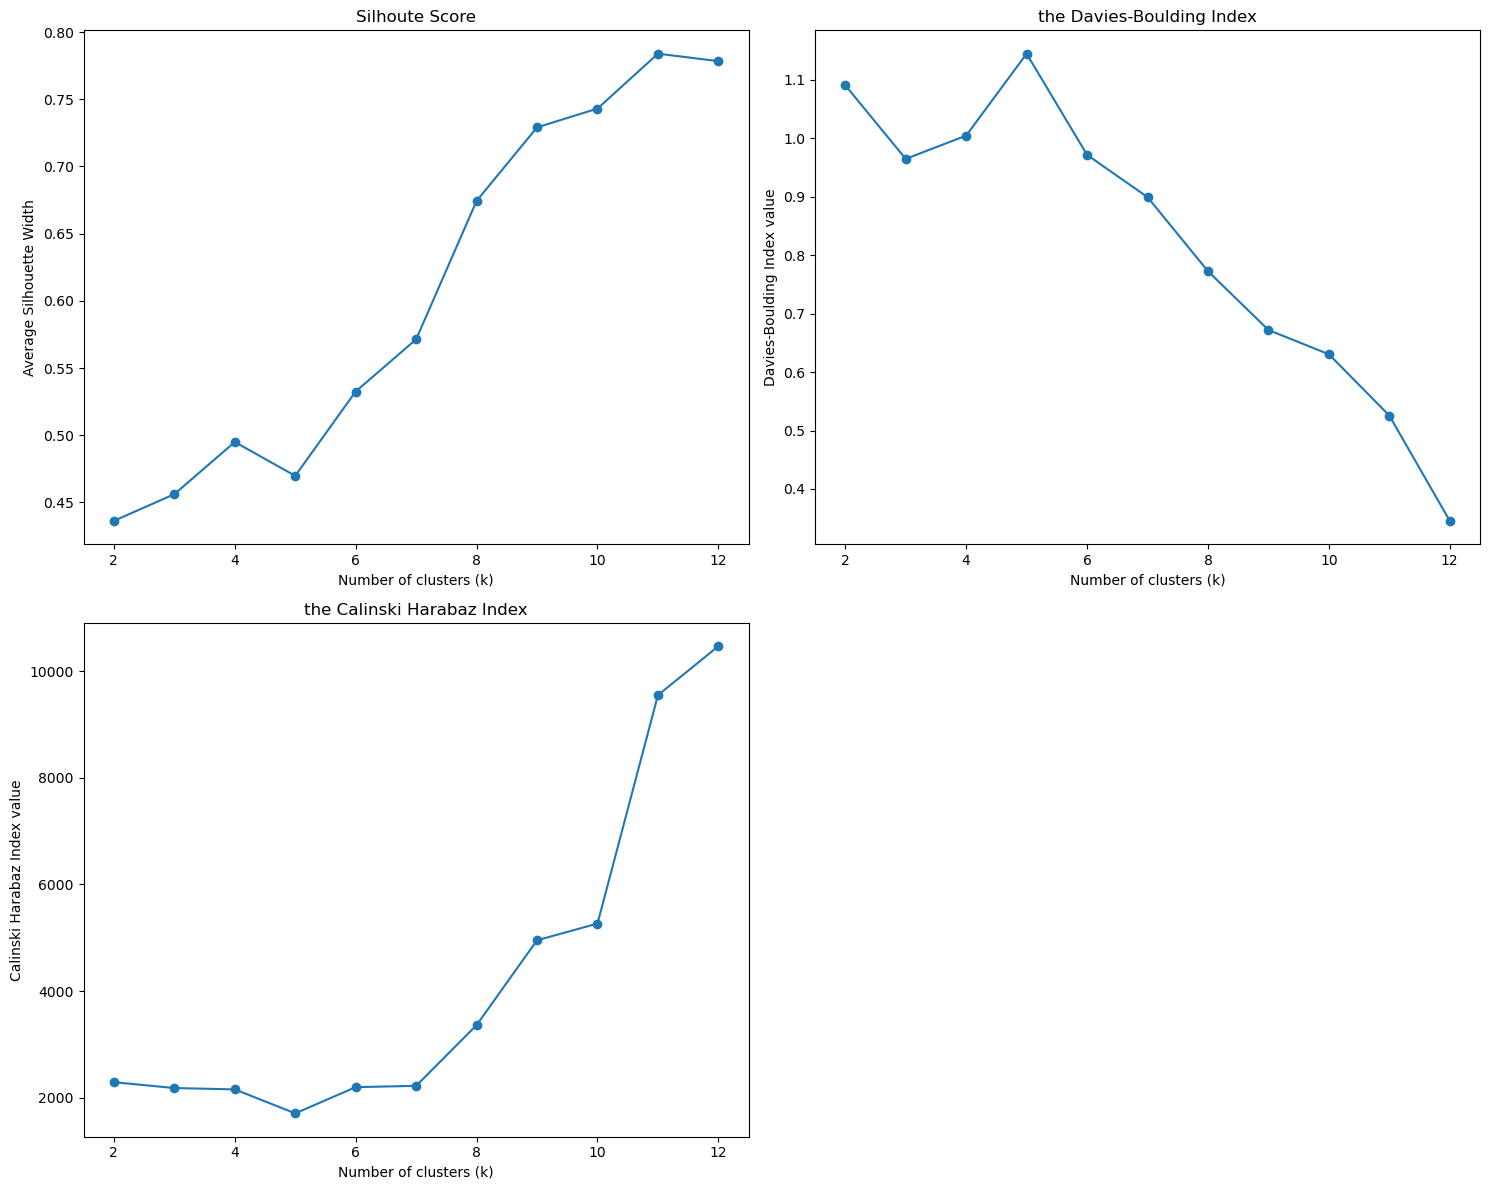

In [217]:
hier_sil(gower_matrix_3, ran = range(2,13), link = 'complete')

Number of clusters is probably 12.

In [105]:
Agg_hc_c3 = AgglomerativeClustering(n_clusters = 12, affinity = 'precomputed', linkage = 'complete').fit(gower_matrix_3)
#y_hc = Agg_hc.fit_predict(gower_matrix_4_weeks) # model fitting on the dataset

labels_c3 = Agg_hc_c3.labels_

#### **Average**

For n_clusters=2, the silhouette score is 0.43630000948905945, the Davies-Boulding Index is 1.0907, 
 the Calinski Harabaz Index is 2294.7794
For n_clusters=3, the silhouette score is 0.3244999945163727, the Davies-Boulding Index is 1.5985, 
 the Calinski Harabaz Index is 1185.4178
For n_clusters=4, the silhouette score is 0.18979999423027039, the Davies-Boulding Index is 1.8263, 
 the Calinski Harabaz Index is 885.1627
For n_clusters=5, the silhouette score is 0.35530000925064087, the Davies-Boulding Index is 1.4401, 
 the Calinski Harabaz Index is 1214.9633
For n_clusters=6, the silhouette score is 0.4691999852657318, the Davies-Boulding Index is 1.1699, 
 the Calinski Harabaz Index is 1534.073
For n_clusters=7, the silhouette score is 0.423799991607666, the Davies-Boulding Index is 0.9423, 
 the Calinski Harabaz Index is 1310.7514
For n_clusters=8, the silhouette score is 0.3725000023841858, the Davies-Boulding Index is 0.7908, 
 the Calinski Harabaz Index is 1225.5961
For n_cluster

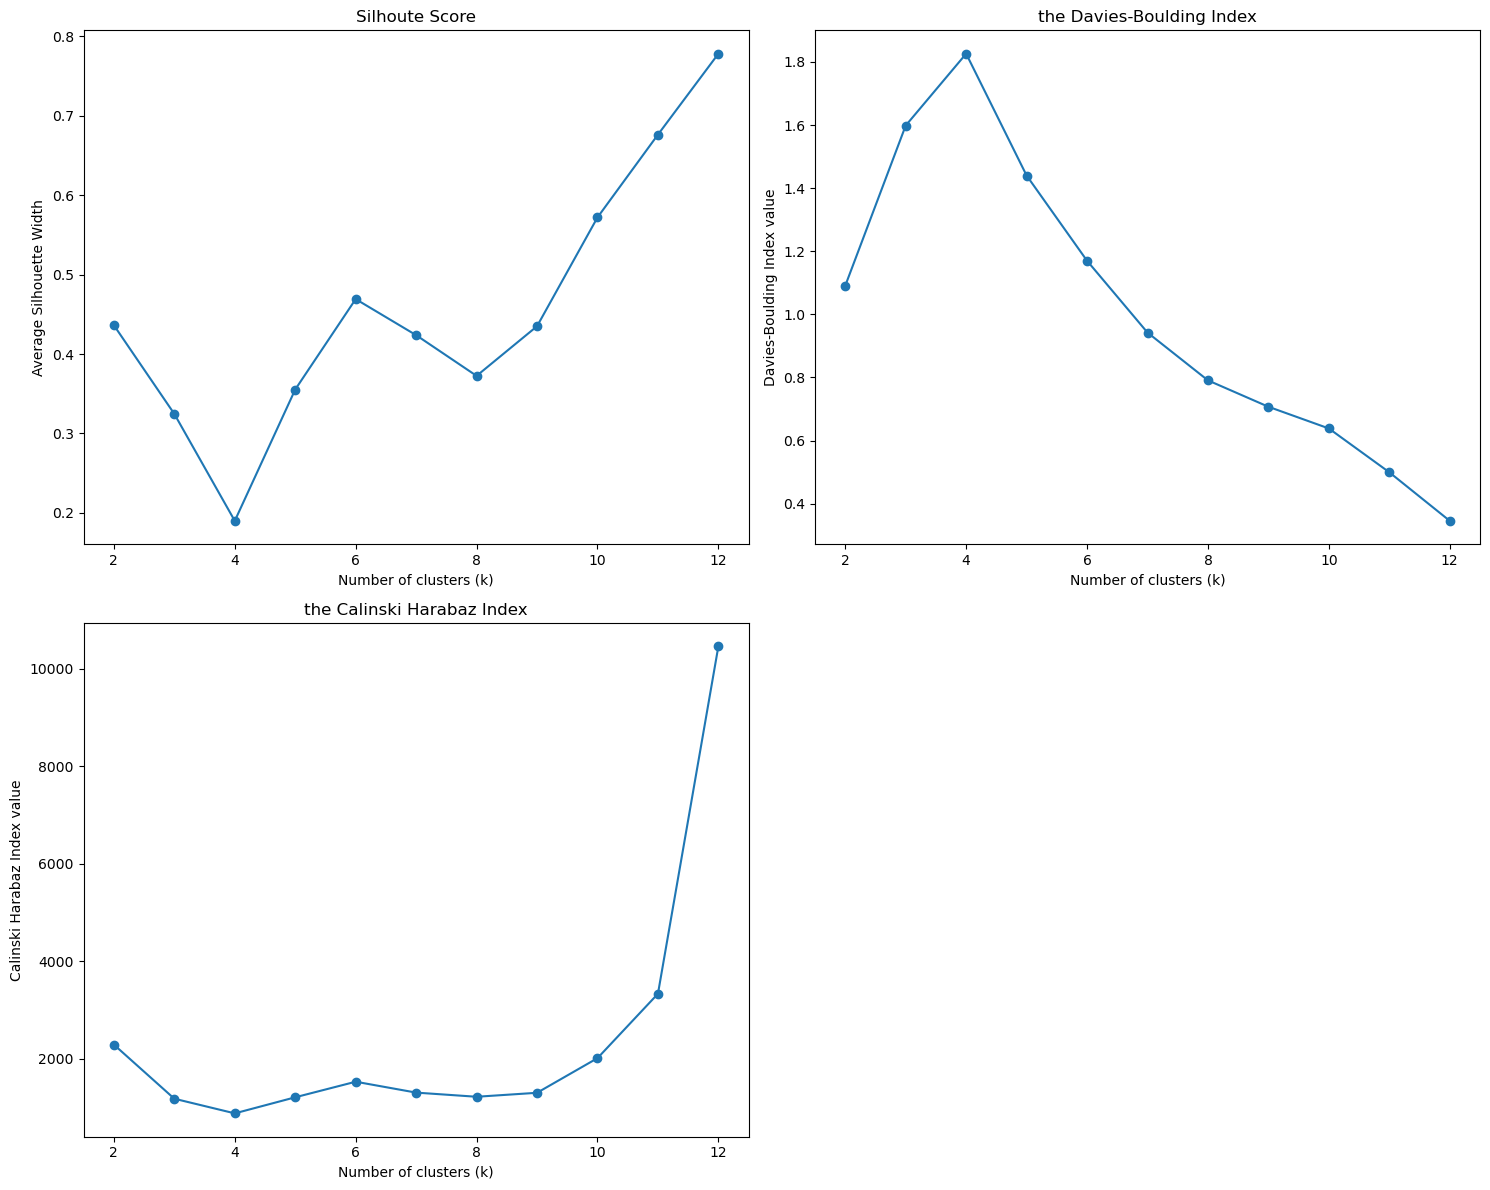

In [218]:
hier_sil(gower_matrix_3, ran = range(2,13), link = 'average')

The number of clusters is probably 12.

In [219]:
Agg_hc_a3 = AgglomerativeClustering(n_clusters = 12, affinity = 'precomputed', linkage = 'average').fit(gower_matrix_3)
#y_hc = Agg_hc.fit_predict(gower_matrix_4_weeks) # model fitting on the dataset

labels_a3 = Agg_hc_a3.labels_

#### **Summary**

Here, it doesn't matter which method we will choose, because all of them give the same results. That's why, average linkage will be chosen.

In [220]:
cluster_labels_3 = labels_a3

trial_data_hier3 = df_users_only_demo_clus3.copy()
trial_data_hier3["cluster"] = cluster_labels_3

Below there is a number of users in each cluster.

In [221]:
trial_data_hier3["cluster"].value_counts()

9     711
0     451
5     435
4     327
1     283
10    223
11    206
2     155
8     125
7      59
3      41
6      18
Name: cluster, dtype: int64

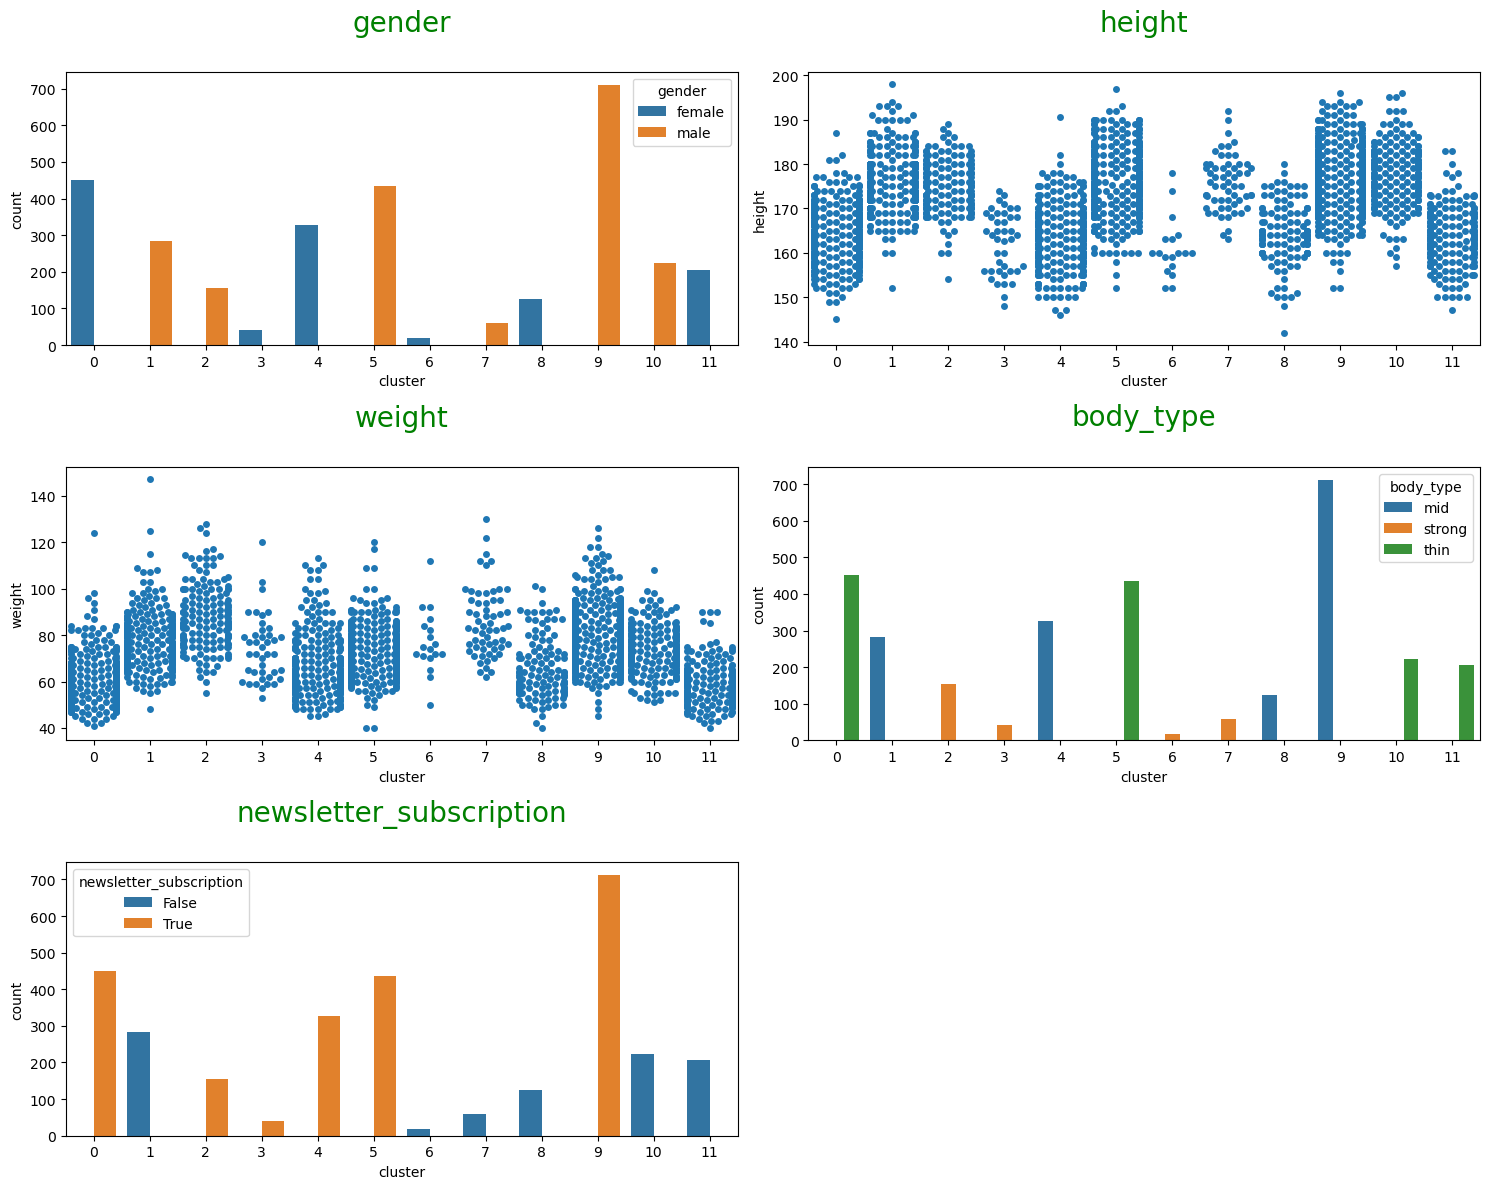

In [222]:
clus_plot(trial_data_hier3, cat_cols = ['gender', 'body_type', 'newsletter_subscription'], 
          num_cols = ['height', 'weight'])

The description of the cluster could be as follow:

* **Cluster 0** - thin women with newsletter subscription, low to medium height and low weight,
* **Cluster 1** - mid men without newsletter subscription, rather tall and with average to high weight,
* **Cluster 2** - strong men with newsletter subscription, average height and rather high weight,
* **Cluster 3** - female with strong body type, newsletter subscription, rather short and average weight,
* **Cluster 4** - mid women with newsletter subscription, low to average height and low to average weight,
* **Cluster 5** - men with thin body type, newsletter subscription, average to tall height and average weight,
* **Cluster 6** - women with strong body type, no newsletter subscription, rather short and average weight,
* **Cluster 7** - men with strong body type, no newsletter subscription, rather tall and high weight,
* **Cluster 8** - women with mid body type, no newsletter subscription, low to average height and low weight,
* **Cluster 9** - men with mid body type, newsletter subscription, medium to high height and average to high weight,
* **Cluster 10** - thin men, no newsletter subscription, average to high height and average weight,
* **Cluster 11** - thin women without newsletter subscription, short and with low weight.

### **K-prototypes**

In [223]:
df_kpro3 = df_users_only_demo_clus_enc3.copy()

categorical_cols = ['gender', 'body_type', 'newsletter_subscription']

In [224]:
df_kpro3.head()

gender  height  weight  body_type  newsletter_subscription
0         1  180.00   70.00          2                        1
35        1  186.00   79.00          0                        1
67        1  186.00   86.00          0                        0
103       1  178.00   70.00          0                        0
198       0  164.00   62.00          2                        1

For n_clusters=2, method: Huang, the silhouette score is 0.4626
For n_clusters=2, method: Cao, the silhouette score is 0.4626
For n_clusters=3, method: Huang, the silhouette score is 0.4064
For n_clusters=3, method: Cao, the silhouette score is 0.4064
For n_clusters=4, method: Huang, the silhouette score is 0.3557
For n_clusters=4, method: Cao, the silhouette score is 0.3556
For n_clusters=5, method: Huang, the silhouette score is 0.3629
For n_clusters=5, method: Cao, the silhouette score is 0.3611
For n_clusters=6, method: Huang, the silhouette score is 0.3417
For n_clusters=6, method: Cao, the silhouette score is 0.3365
For n_clusters=7, method: Huang, the silhouette score is 0.3124
For n_clusters=7, method: Cao, the silhouette score is 0.3115
For n_clusters=8, method: Huang, the silhouette score is 0.32
For n_clusters=8, method: Cao, the silhouette score is 0.3191
For n_clusters=9, method: Huang, the silhouette score is 0.3119
For n_clusters=9, method: Cao, the silhouette score is 0

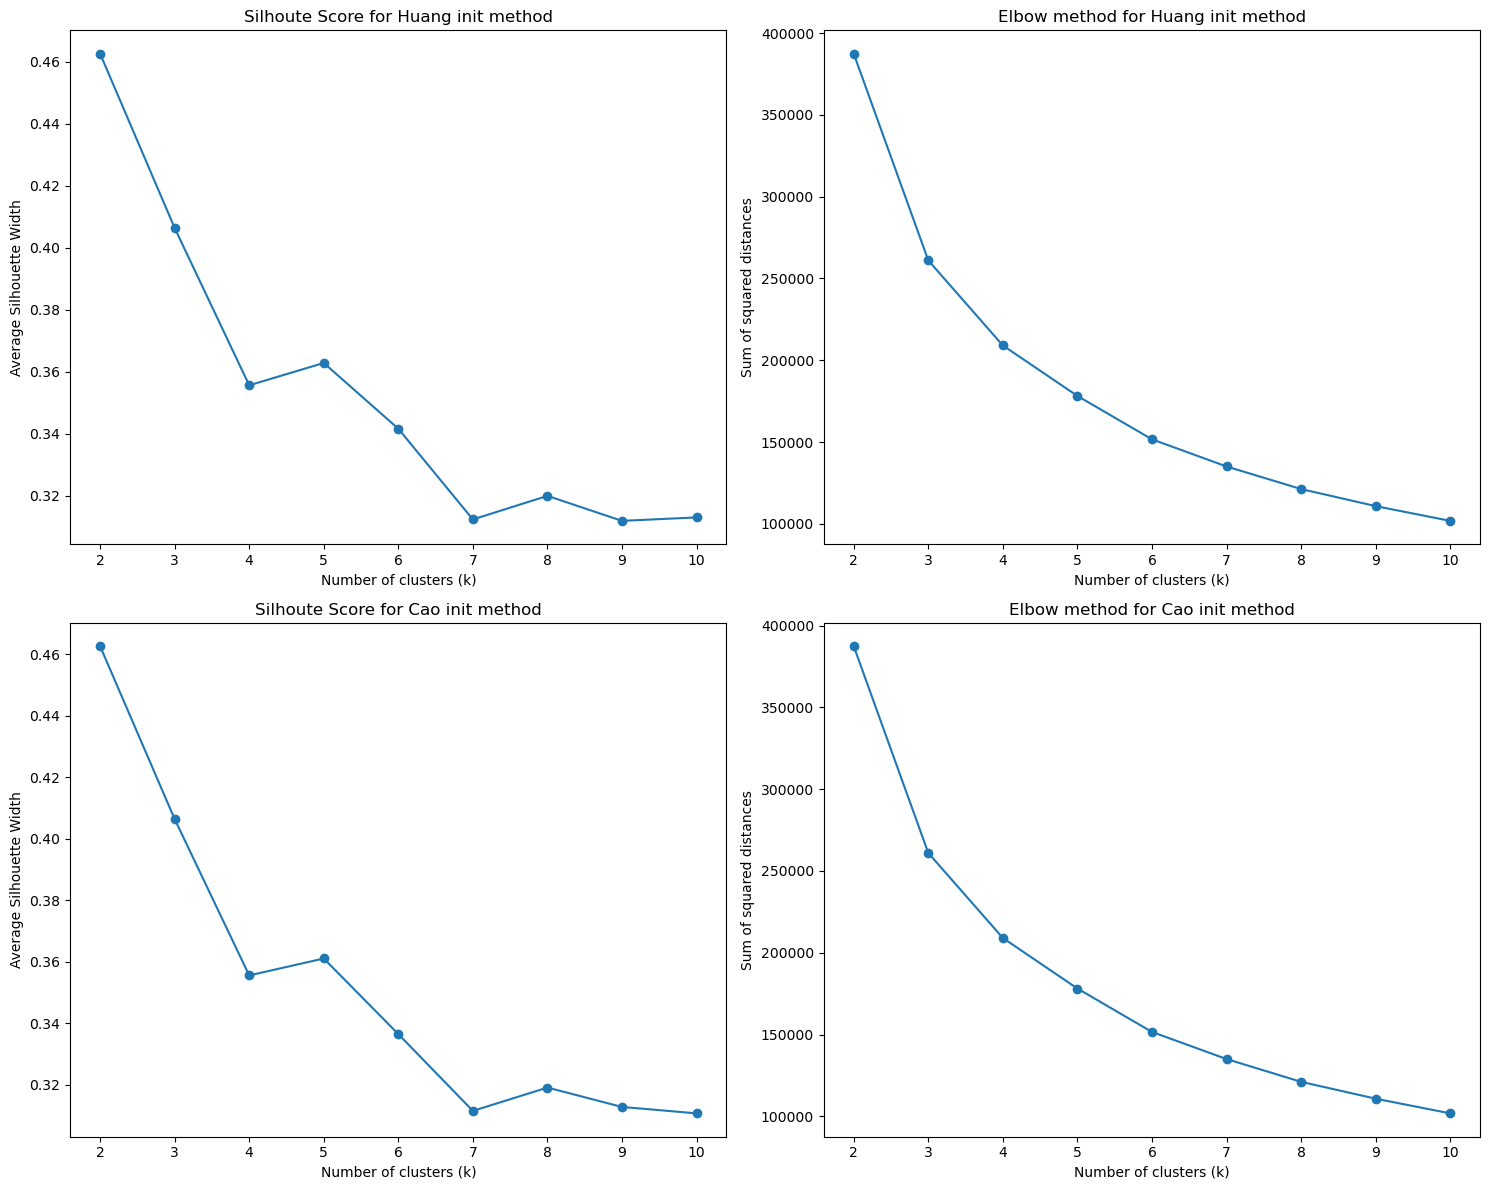

In [225]:
kpro_sil_elbow(df_kpro3, categorical_cols, ran = range(2,11))

In [226]:
kproto3 = KPrototypes(n_clusters=2, init='Huang')
clusters3 = kproto3.fit_predict(df_kpro3, categorical=[0, 3,4])

In [227]:
labels3 = pd.DataFrame(clusters3)
labels3.rename(columns = {0: 'cluster'}, inplace = True)

df_kpro3.reset_index(inplace = True, drop = True)

labeled_data3 = pd.concat((df_users_only_demo_clus3.reset_index(drop = True), labels2),axis=1)

In [124]:
davies_bouldin_score(df_kpro3, labeled_data3['cluster'])

1.798705292952765

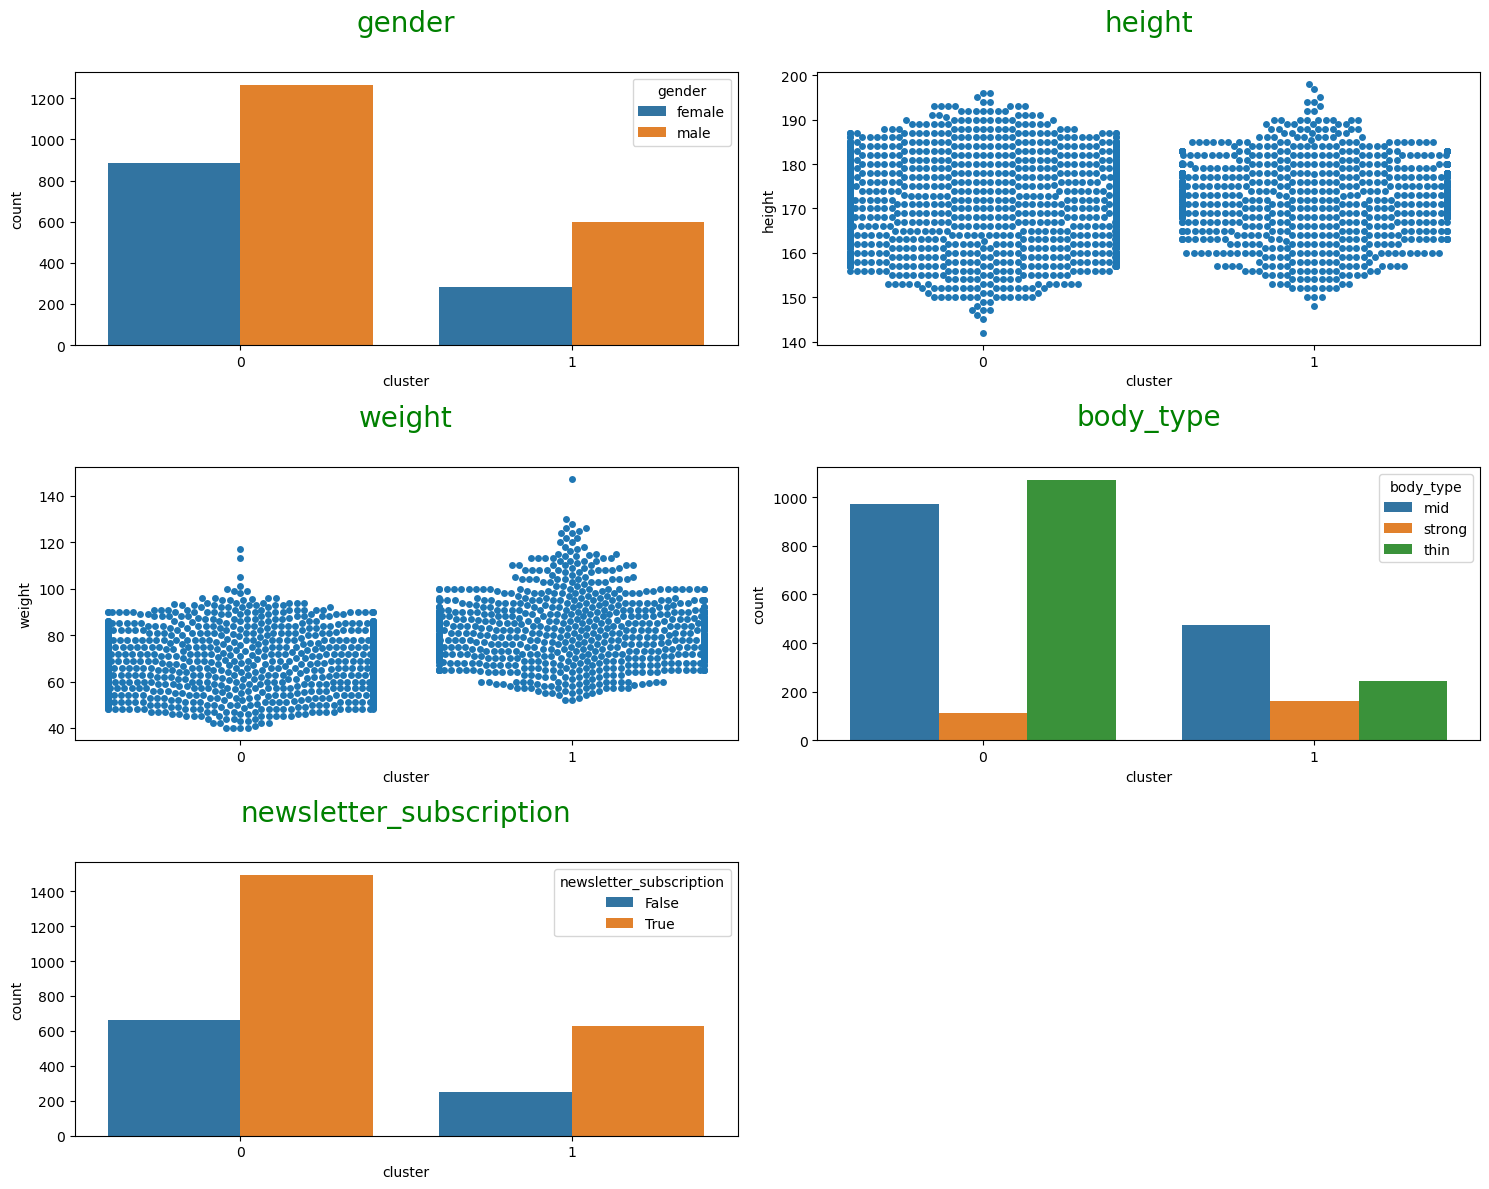

In [229]:
clus_plot(labeled_data3, cat_cols = categorical_cols, 
          num_cols = ['height', 'weight'])

The description of the cluster could be as follow:

* **Cluster 0** - men and women with mostly mid and thin body type, mostly with newsletter subscription, low to high height and low to average weight,
* **Cluster 1** - men and women with mid, strong and thin body type, mostly with newsletter subscription, average height and average weight.

#### **Scaled data**

In [129]:
df_kpro_sca3 = df_kpro3.copy()

numerical_columns3 = ['height', 'weight', 'age_in_years']

scaler = StandardScaler()

# standard scale numerical features
for c in numerical_columns3:
    df_kpro_sca3[c] = scaler.fit_transform(df_kpro_sca3[[c]])

Again, we check hopkins score, it is better than before.

In [119]:
hopkins(df_kpro_sca3)

0.9306023938764284

For n_clusters=2, method: Huang, the silhouette score is 0.3259
For n_clusters=2, method: Cao, the silhouette score is 0.3259
For n_clusters=3, method: Huang, the silhouette score is 0.2202
For n_clusters=3, method: Cao, the silhouette score is 0.223
For n_clusters=4, method: Huang, the silhouette score is 0.2196
For n_clusters=4, method: Cao, the silhouette score is 0.2168
For n_clusters=5, method: Huang, the silhouette score is 0.1749
For n_clusters=5, method: Cao, the silhouette score is 0.1922
For n_clusters=6, method: Huang, the silhouette score is 0.1874
For n_clusters=6, method: Cao, the silhouette score is 0.1837
For n_clusters=7, method: Huang, the silhouette score is 0.1797
For n_clusters=7, method: Cao, the silhouette score is 0.1474
For n_clusters=8, method: Huang, the silhouette score is 0.1569
For n_clusters=8, method: Cao, the silhouette score is 0.1801
For n_clusters=9, method: Huang, the silhouette score is 0.1636
For n_clusters=9, method: Cao, the silhouette score is 

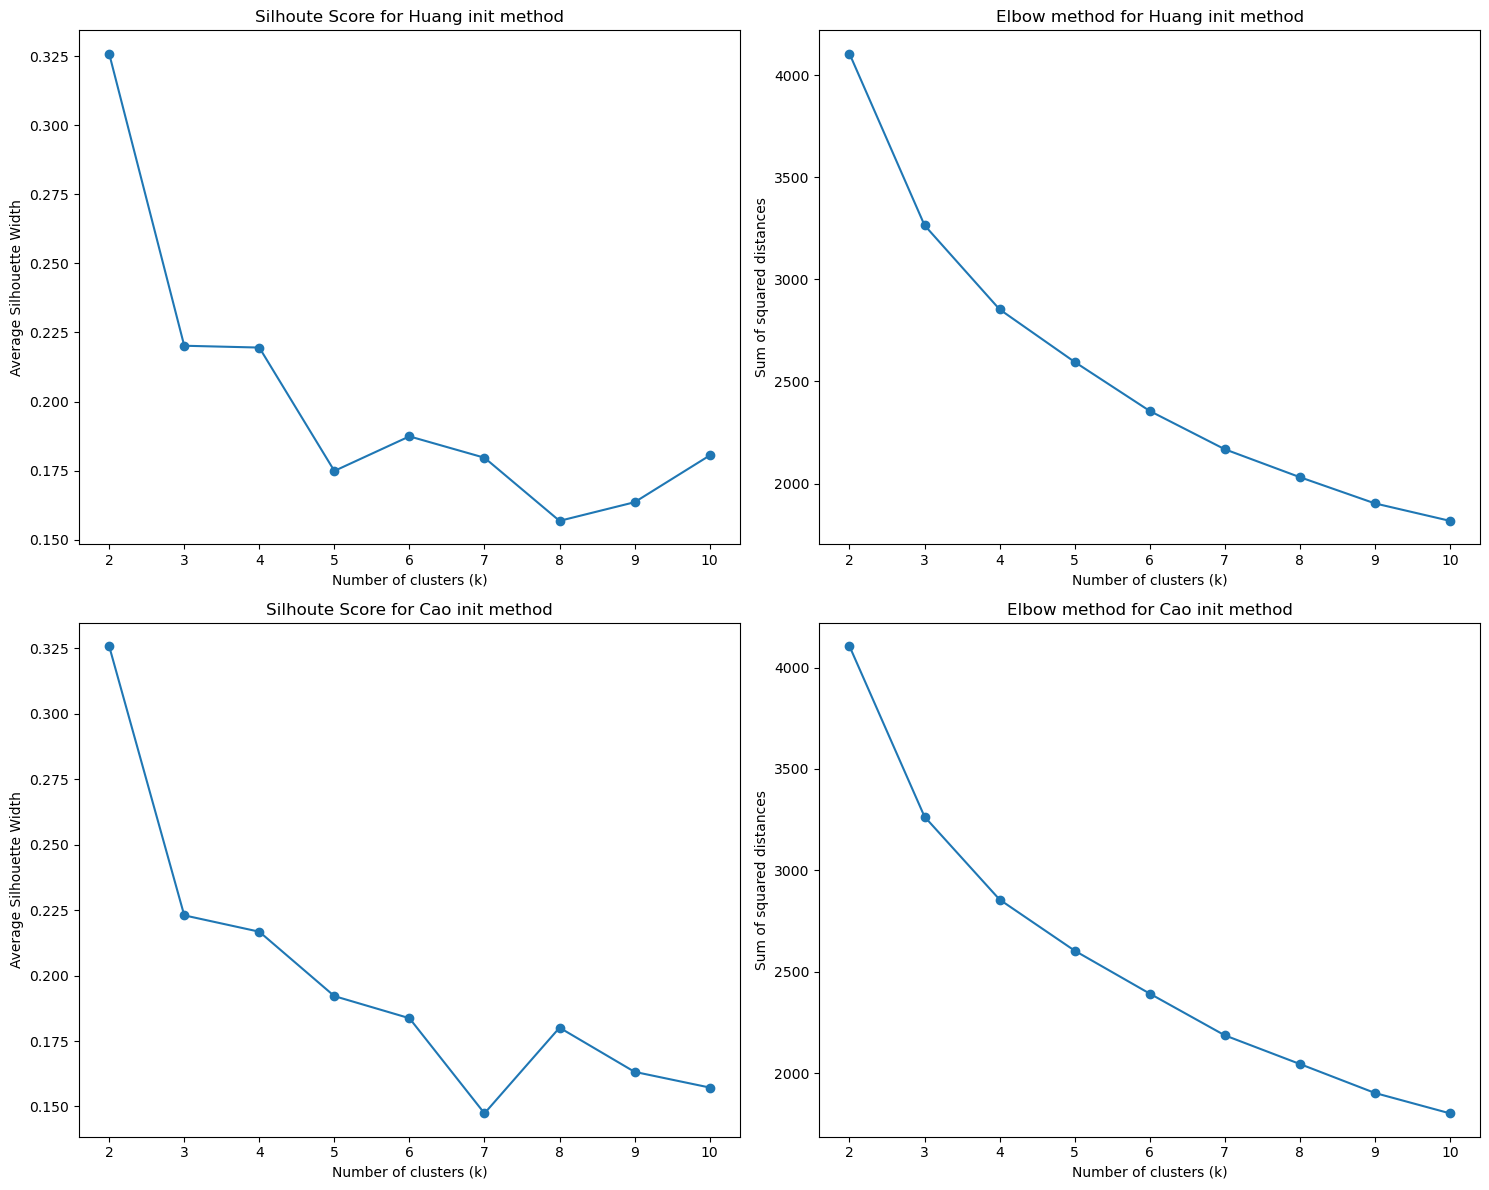

In [120]:
kpro_sil_elbow(df_kpro_sca3, categorical_cols, ran = range(2,11))

The probable number of clusters is 2, but the silhouette score is pretty low, so the clusterization won't be too good.

In [121]:
kproto_sca3 = KPrototypes(n_clusters=2, init='Huang')
clusters_sca3 = kproto_sca3.fit_predict(df_kpro_sca3, categorical=[0,3,4])

labels_sca3 = pd.DataFrame(clusters_sca3)
labels_sca3.rename(columns = {0: 'cluster'}, inplace = True)

labeled_data_sca3 = pd.concat((df_users_only_demo_clus3.reset_index(drop = True),labels_sca3),axis=1)

labeled_data_sca3['cluster'].value_counts()

1    1742
0    1292
Name: cluster, dtype: int64

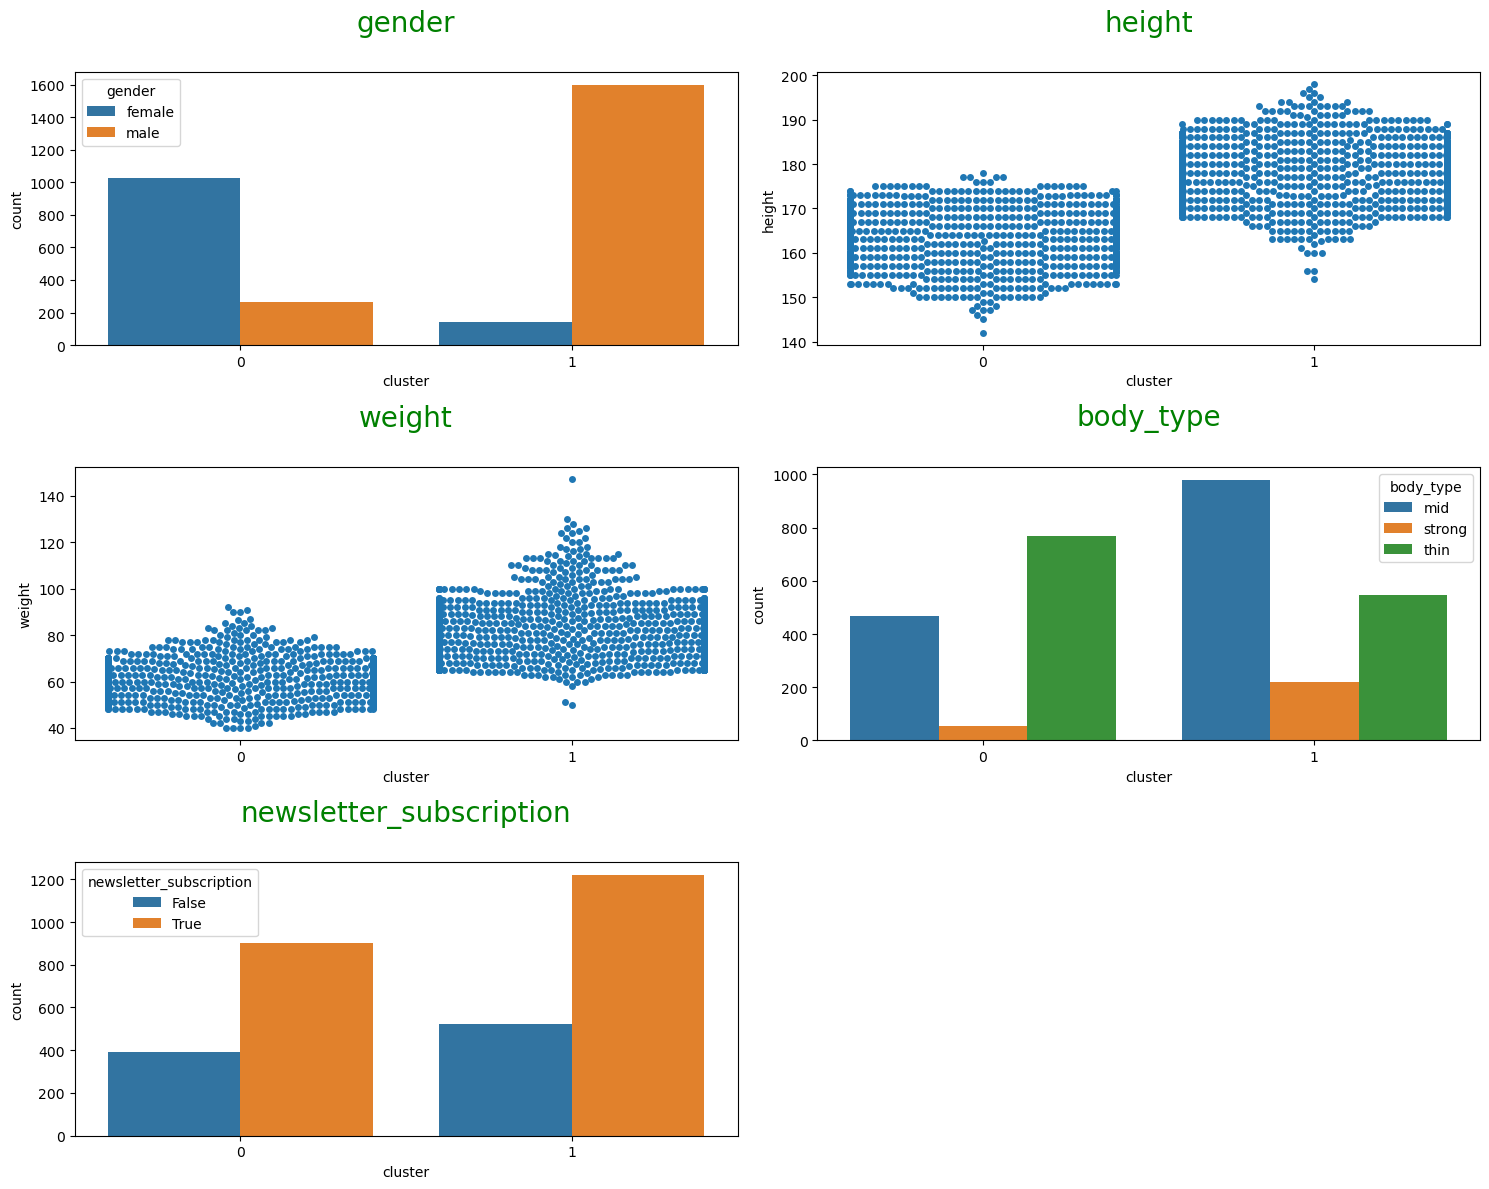

In [122]:
clus_plot(labeled_data_sca3, cat_cols = ['gender', 'body_type', 'newsletter_subscription'], 
          num_cols = ['height', 'weight'])

The description of the cluster could be as follow:

* **Cluster 0** - mostly men with mostly mid body type, newsletter subscription, average to high BMI and high body fat,
* **Cluster 1** - thin and mid men and women mostly with newsletter subscription, low to average BMI and low to average body fat.

### **Summary**

In [230]:
# data into summary table
data3 = {'Name of algorithm' : ['PAM', 'hierarchial clustering (average linkage)', 
                               'K-prototypes'],
        'Number of clusters (k)' : [11, 12, 2],
        'Silhouette score' : [silhouette_score(gower_matrix_3, trial_data3['cluster']),
                              silhouette_score(gower_matrix_3, trial_data_hier3["cluster"]),
                              silhouette_score(df_kpro3, labeled_data3["cluster"])
                              ],
        'Calinski Harabaz Index' : [calinski_harabasz_score(gower_matrix_3, trial_data3['cluster']),
                                    calinski_harabasz_score(gower_matrix_3, trial_data_hier3["cluster"]),
                                    calinski_harabasz_score(df_kpro3, labeled_data3["cluster"])
                                   ],
        'Davies Bouldin Index' : [davies_bouldin_score(gower_matrix_3, trial_data3['cluster']),
                                  davies_bouldin_score(gower_matrix_3, trial_data_hier3["cluster"]),
                                  davies_bouldin_score(df_kpro3, labeled_data3["cluster"])
                                 ]}

In [231]:
summary_tab3 = pd.DataFrame(data3)
summary_tab3.set_index(['Name of algorithm'], inplace = True)

In [232]:
summary_tab3

Number of clusters (k)  \
Name of algorithm                                                  
PAM                                                           11   
hierarchial clustering (average linkage)                      12   
K-prototypes                                                   2   

                                          Silhouette score  \
Name of algorithm                                            
PAM                                                   0.78   
hierarchial clustering (average linkage)              0.78   
K-prototypes                                          0.17   

                                          Calinski Harabaz Index  \
Name of algorithm                                                  
PAM                                                      9386.98   
hierarchial clustering (average linkage)                10464.89   
K-prototypes                                              611.86   

                                          Davies Bouldin Index  
Name of algorithm                                               
PAM                                                       0.49  
hierarchial clustering (average linkage)                  0.35  
K-prototypes                                              1.79

Here the best one is hierarchical clustering with average linkage.

## **Variables gender, body_type, newsletter_subscription and BMI**

Variables taken into consideration are:
* gender,
* BMI,
* body_type and
* newsletter_subscription.

In [131]:
df_users_only_demo_clus4 = df_users_only_demo_clus.loc[:, ['gender', 'BMI',
       'body_type', 'newsletter_subscription', 'age_in_years']]

In [132]:
df_users_only_demo_clus_enc4 = df_users_only_demo_clus4.copy()

for col in ['gender', 'body_type', 'newsletter_subscription']:
    df_users_only_demo_clus_enc4[col] = LabelEncoder().fit_transform(df_users_only_demo_clus_enc4[col])

In [133]:
df_users_only_demo_clus_enc4.head()

gender   BMI  body_type  newsletter_subscription  age_in_years
0         1 21.60          2                        1         32.00
35        1 22.84          0                        1         48.00
67        1 24.86          0                        0         37.00
103       1 22.09          0                        0         29.00
198       0 23.05          2                        1         43.00

In [134]:
gower_matrix_4 = gower.gower_matrix(df_users_only_demo_clus_enc4, cat_features = [True, False, True, True, False])

In [135]:
hopkins(pd.DataFrame(gower_matrix_4)) # hopkins score to see if data is good for clustering

0.9902601537720969

### **PAM**

For n_clusters=2, the silhouette score is 0.3504999876022339, the Davies-Boulding Index is 1.3487, 
 the Calinski Harabaz Index is 1422.3571
For n_clusters=3, the silhouette score is 0.35120001435279846, the Davies-Boulding Index is 1.1173, 
 the Calinski Harabaz Index is 1421.3838
For n_clusters=4, the silhouette score is 0.41280001401901245, the Davies-Boulding Index is 0.9429, 
 the Calinski Harabaz Index is 1578.6815
For n_clusters=5, the silhouette score is 0.5198000073432922, the Davies-Boulding Index is 0.8453, 
 the Calinski Harabaz Index is 1999.1135
For n_clusters=6, the silhouette score is 0.5785999894142151, the Davies-Boulding Index is 0.7286, 
 the Calinski Harabaz Index is 2308.0577
For n_clusters=7, the silhouette score is 0.6610000133514404, the Davies-Boulding Index is 0.535, 
 the Calinski Harabaz Index is 3282.3517
For n_clusters=8, the silhouette score is 0.7150999903678894, the Davies-Boulding Index is 0.5995, 
 the Calinski Harabaz Index is 3710.5929
For n_cluste

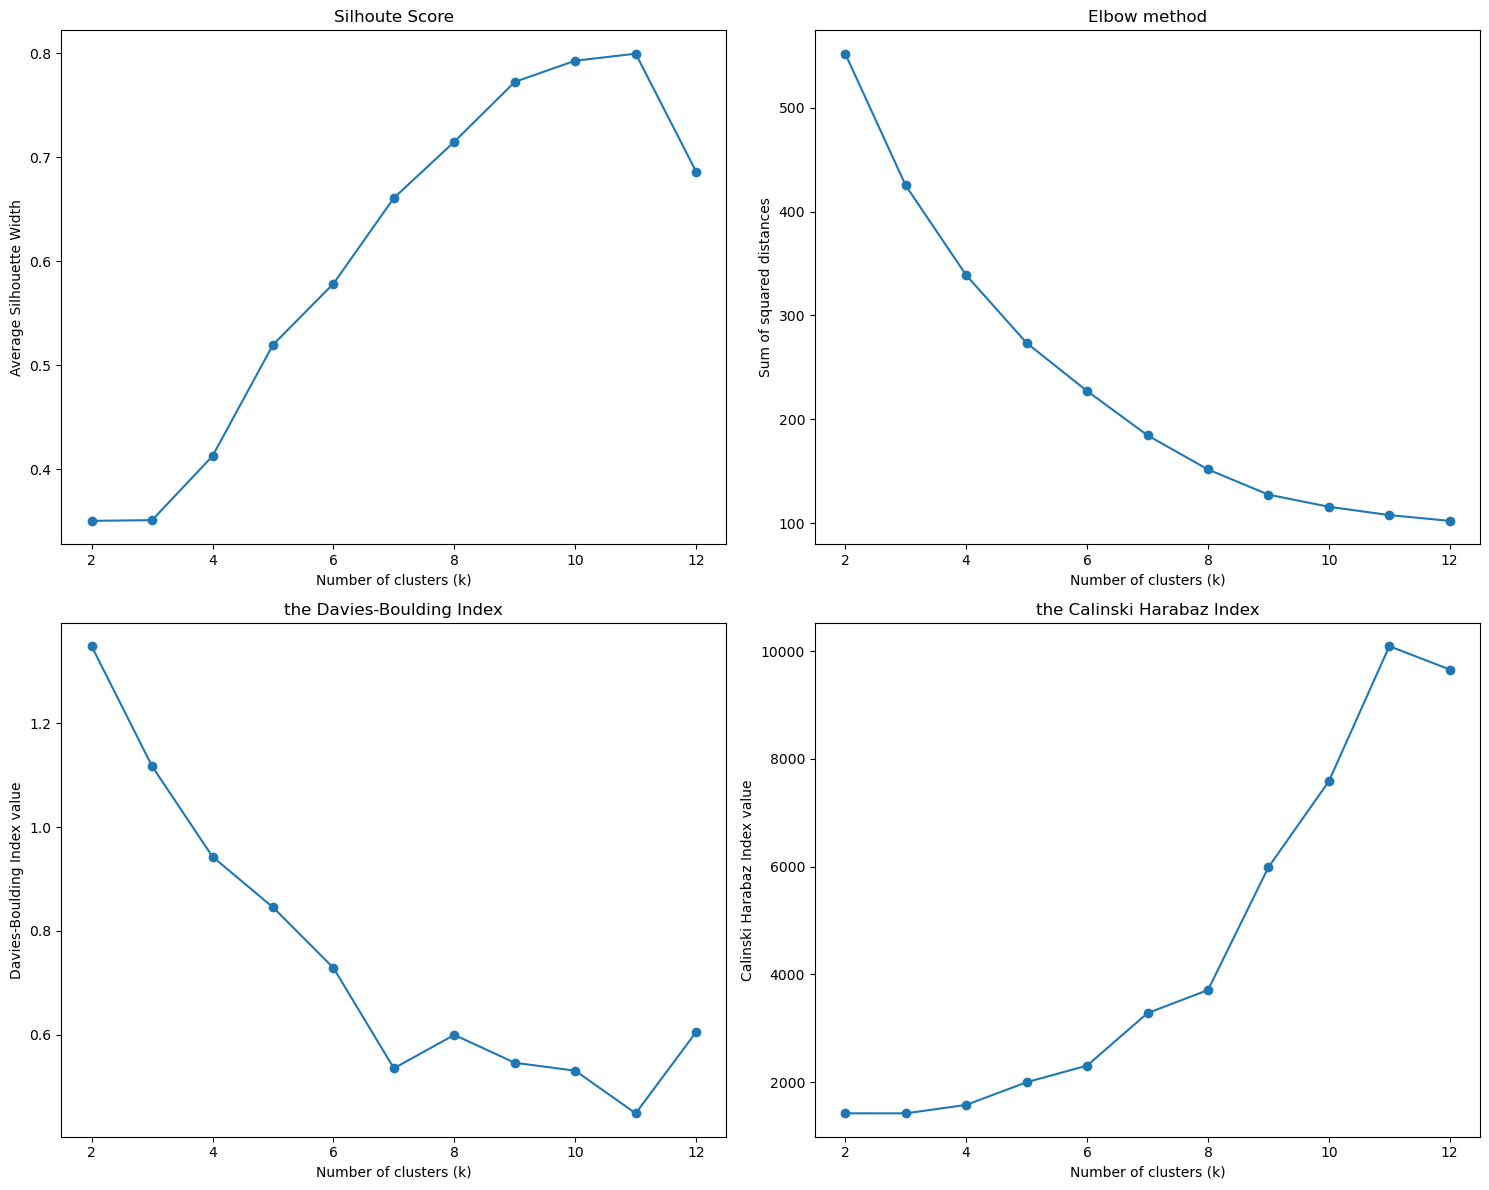

In [136]:
pam_sil_elbow(gower_matrix_4, range(2,13))

The number of clusters is 12.

In [137]:
km_model4 = KMedoids(n_clusters = 11, random_state = 42, metric = 'precomputed', method = 'pam', 
                            init =  'k-medoids++')
km_model4.fit(gower_matrix_4)
km_model4.predict(gower_matrix_4)

array([ 2,  8,  4, ..., 10,  5,  3])

In [138]:
trial_data4 = df_users_only_demo_clus4.copy()

trial_data4['cluster'] = km_model4.labels_

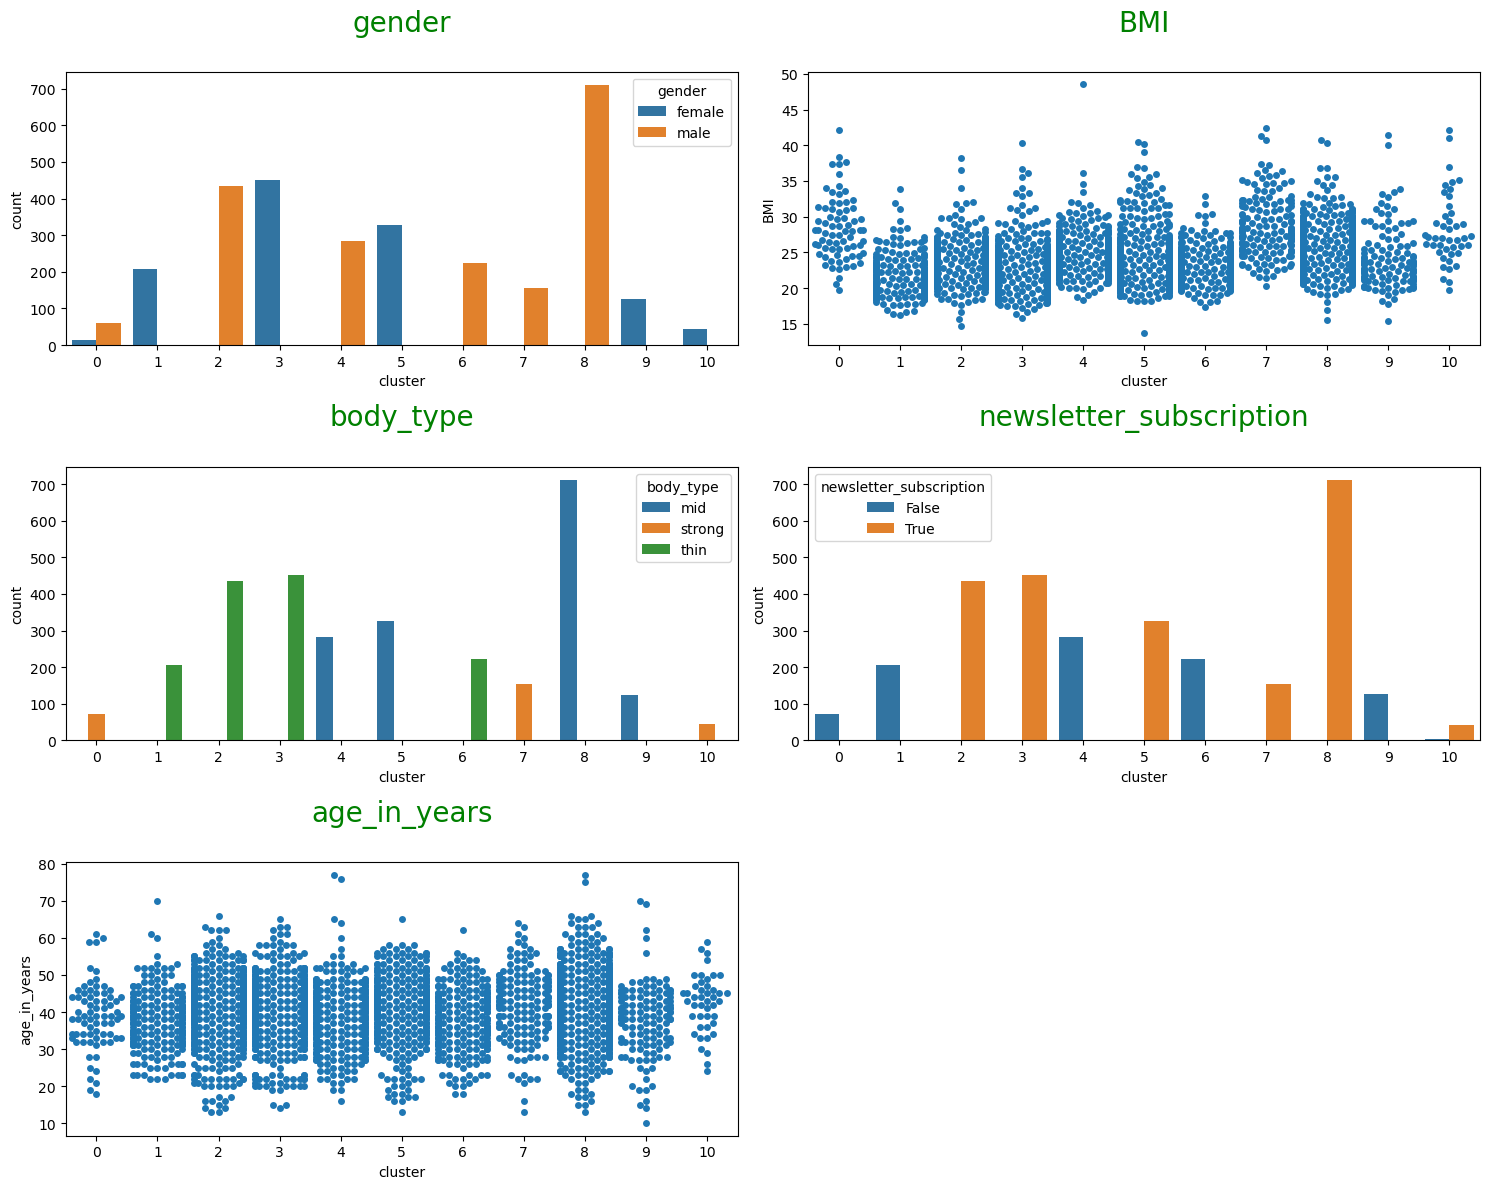

In [139]:
clus_plot(trial_data4, cat_cols = ['gender', 'body_type', 'newsletter_subscription'], 
          num_cols = ['BMI', 'age_in_years'])

The description of the cluster could be as follow:

* **Cluster 0** - strong men mostly with no newsletter subscription and average to high BMI,
* **Cluster 1** - mid women with newsletter subscription and average to high BMI,
* **Cluster 2** - men with mid body type with newsletter subscription and average to high BMI,
* **Cluster 3** - female with thin body type, no newsletter subscription and low to medium BMI,
* **Cluster 4** - thin women with newsletter subscription and low to medium BMI,
* **Cluster 5** - thin male with newsletter subscription and average BMI,
* **Cluster 6** - men with thin body type, no newsletter subscription and rather average BMI,
* **Cluster 7** - men with mid body type, no newsletter subscription and medium to high BMI,
* **Cluster 8** - men with strong body type, newsletter subscription and high BMI,
* **Cluster 9** - women with mid body type, no newsletter subscription, rather low to average BMI,
* **Cluster 10** - women with strong body type, newsletter subscription and rather average BMI,
* **Cluster 11** - women with strong body type, no newsletter subscription and rather high BMI.

In [233]:
df_users_with_cluster = pd.merge(df_users_only_demo_id, trial_data4['cluster'], left_index = True, right_index = True)

In [234]:
df_with_cluster = pd.merge(df, df_users_with_cluster.loc[:, ['id_users', 'cluster']], left_on = 'id_users', right_on = 'id_users')

In [235]:
#df_with_cluster.to_csv(r'/home/evida-monika/mhunters/final_data_5.csv'+ '.bz2', header=True, index=False,compression='bz2')


### **Hierarchical clustering**

#### **Single**

For n_clusters=2, the silhouette score is 0.21709999442100525, the Davies-Boulding Index is 0.7721, 
 the Calinski Harabaz Index is 39.4977
For n_clusters=3, the silhouette score is 0.16979999840259552, the Davies-Boulding Index is 0.8553, 
 the Calinski Harabaz Index is 119.0516
For n_clusters=4, the silhouette score is 0.10509999841451645, the Davies-Boulding Index is 0.8547, 
 the Calinski Harabaz Index is 115.9546
For n_clusters=5, the silhouette score is -0.03460000082850456, the Davies-Boulding Index is 1.0529, 
 the Calinski Harabaz Index is 119.6193
For n_clusters=6, the silhouette score is 0.03660000115633011, the Davies-Boulding Index is 0.9594, 
 the Calinski Harabaz Index is 234.5084
For n_clusters=7, the silhouette score is -0.0003000000142492354, the Davies-Boulding Index is 0.957, 
 the Calinski Harabaz Index is 210.9007
For n_clusters=8, the silhouette score is 0.10459999740123749, the Davies-Boulding Index is 0.892, 
 the Calinski Harabaz Index is 287.8905
For n_cluste

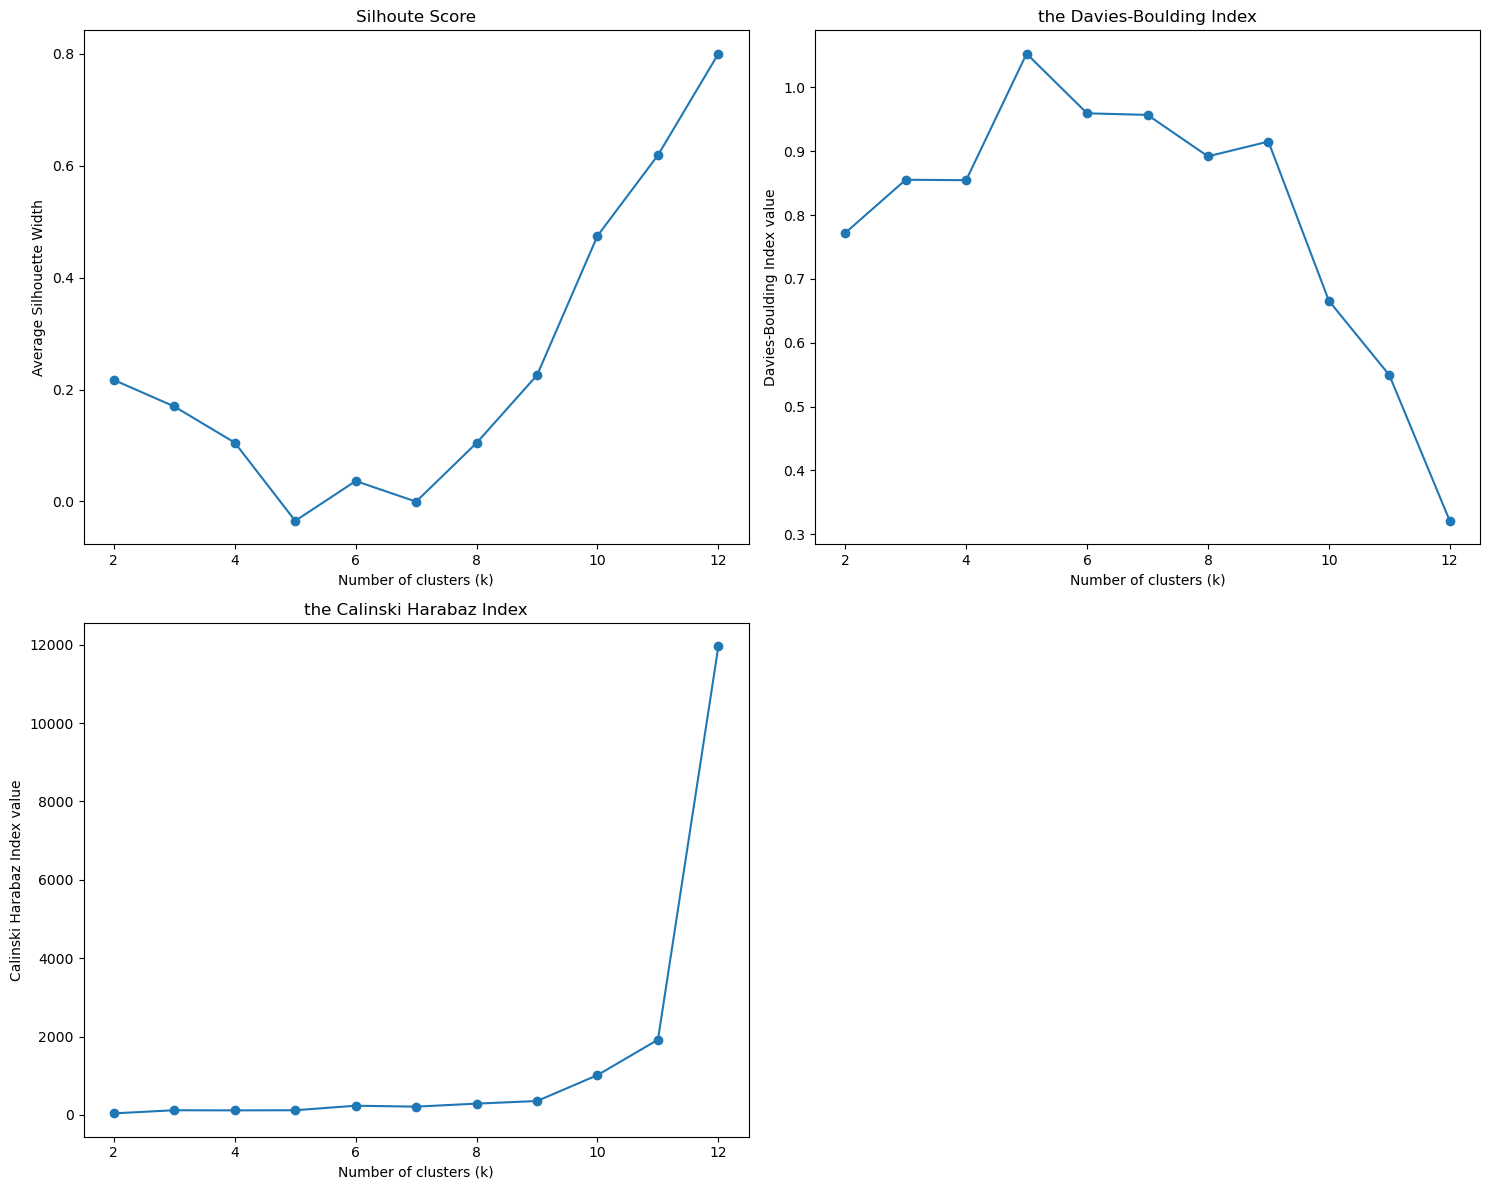

In [140]:
hier_sil(gower_matrix_4, ran = range(2,13), link = 'single')

Number of clusters is probably 12.

In [136]:
Agg_hc4 = AgglomerativeClustering(n_clusters = 12, affinity = 'precomputed', linkage = 'single').fit(gower_matrix_4)
#y_hc = Agg_hc.fit_predict(gower_matrix_4_weeks) # model fitting on the dataset

labels4 = Agg_hc4.labels_

#### **Complete**

For n_clusters=2, the silhouette score is 0.36899998784065247, the Davies-Boulding Index is 1.309, 
 the Calinski Harabaz Index is 1529.4478
For n_clusters=3, the silhouette score is 0.2946999967098236, the Davies-Boulding Index is 1.6326, 
 the Calinski Harabaz Index is 946.4678
For n_clusters=4, the silhouette score is 0.3474999964237213, the Davies-Boulding Index is 1.4158, 
 the Calinski Harabaz Index is 974.8287
For n_clusters=5, the silhouette score is 0.49410000443458557, the Davies-Boulding Index is 1.1613, 
 the Calinski Harabaz Index is 1465.2679
For n_clusters=6, the silhouette score is 0.46639999747276306, the Davies-Boulding Index is 1.1673, 
 the Calinski Harabaz Index is 1289.3742
For n_clusters=7, the silhouette score is 0.5647000074386597, the Davies-Boulding Index is 1.0134, 
 the Calinski Harabaz Index is 1716.4021
For n_clusters=8, the silhouette score is 0.6032999753952026, the Davies-Boulding Index is 0.8996, 
 the Calinski Harabaz Index is 1791.0151
For n_cluster

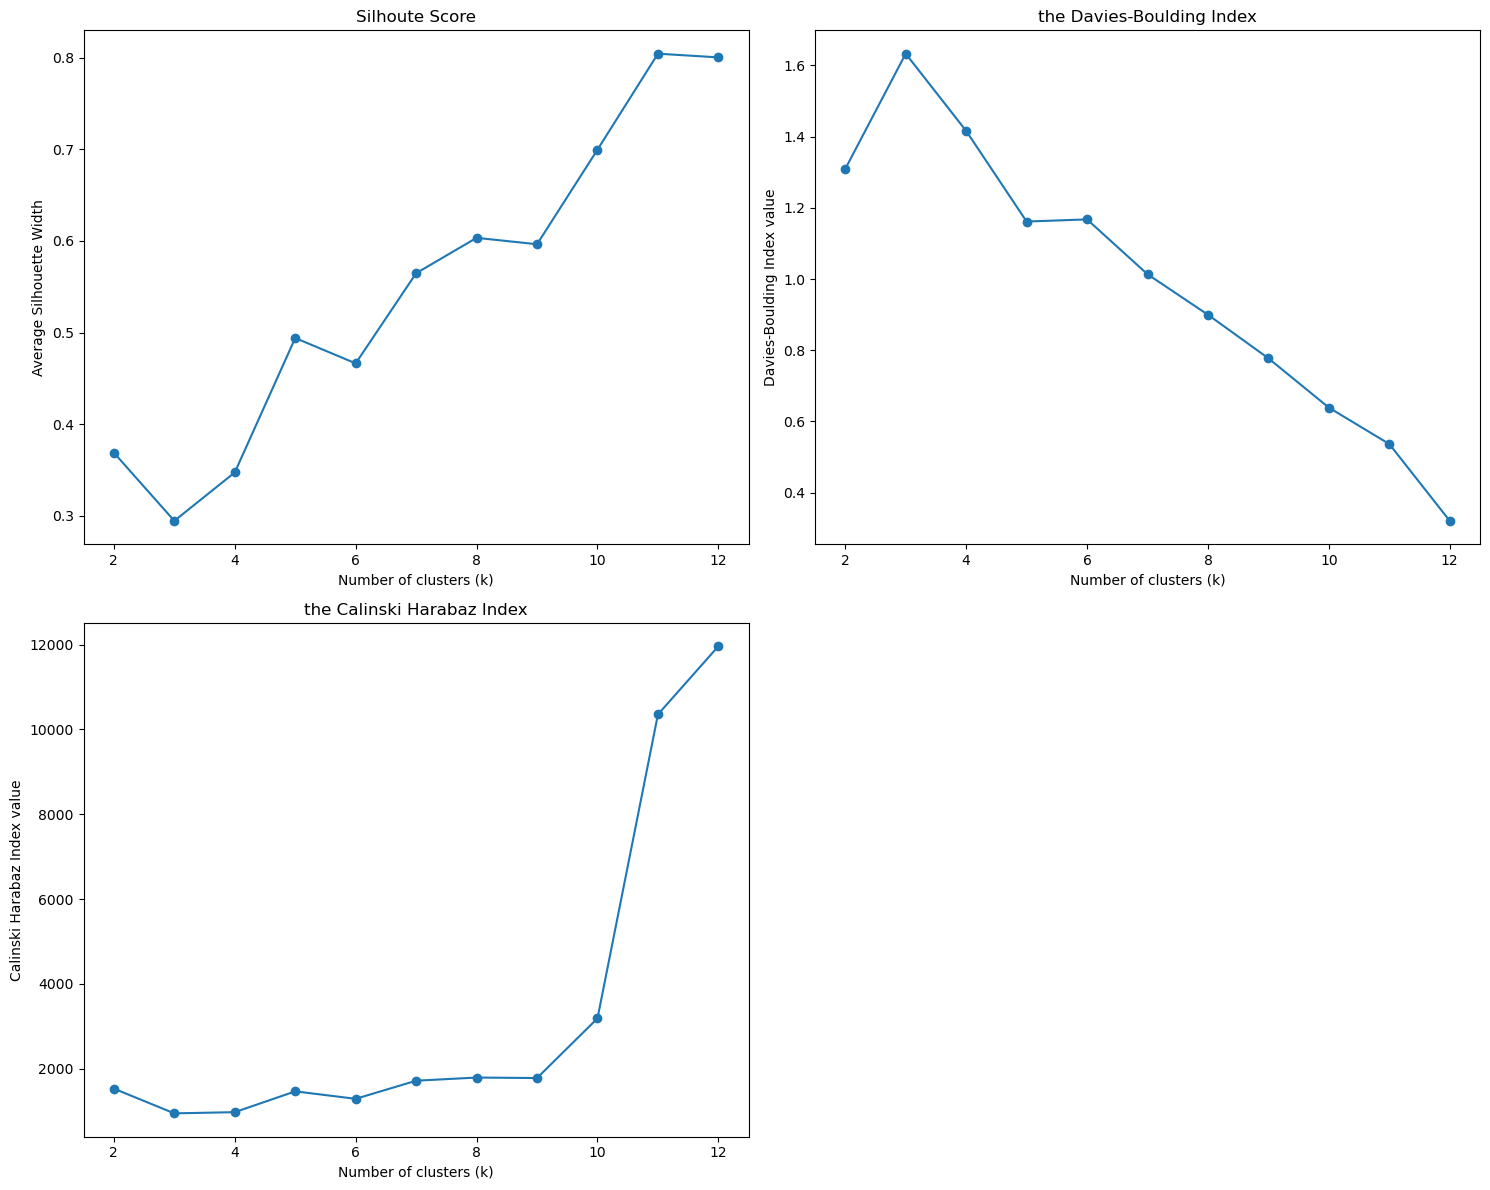

In [141]:
hier_sil(gower_matrix_4, ran = range(2,13), link = 'complete')

Number of clusters is probably 12.

In [143]:
Agg_hc_c4 = AgglomerativeClustering(n_clusters = 12, affinity = 'precomputed', linkage = 'complete').fit(gower_matrix_4)
#y_hc = Agg_hc.fit_predict(gower_matrix_4_weeks) # model fitting on the dataset

labels_c4 = Agg_hc_c4.labels_

#### **Average**

For n_clusters=2, the silhouette score is 0.3407999873161316, the Davies-Boulding Index is 1.4401, 
 the Calinski Harabaz Index is 1354.5003
For n_clusters=3, the silhouette score is 0.3034000098705292, the Davies-Boulding Index is 1.547, 
 the Calinski Harabaz Index is 894.6802
For n_clusters=4, the silhouette score is 0.36980000138282776, the Davies-Boulding Index is 1.3447, 
 the Calinski Harabaz Index is 1018.6814
For n_clusters=5, the silhouette score is 0.319599986076355, the Davies-Boulding Index is 1.1602, 
 the Calinski Harabaz Index is 831.1908
For n_clusters=6, the silhouette score is 0.4551999866962433, the Davies-Boulding Index is 1.0857, 
 the Calinski Harabaz Index is 1211.9995
For n_clusters=7, the silhouette score is 0.4106000065803528, the Davies-Boulding Index is 0.9449, 
 the Calinski Harabaz Index is 1037.0538
For n_clusters=8, the silhouette score is 0.36329999566078186, the Davies-Boulding Index is 0.838, 
 the Calinski Harabaz Index is 970.7338
For n_clusters=9,

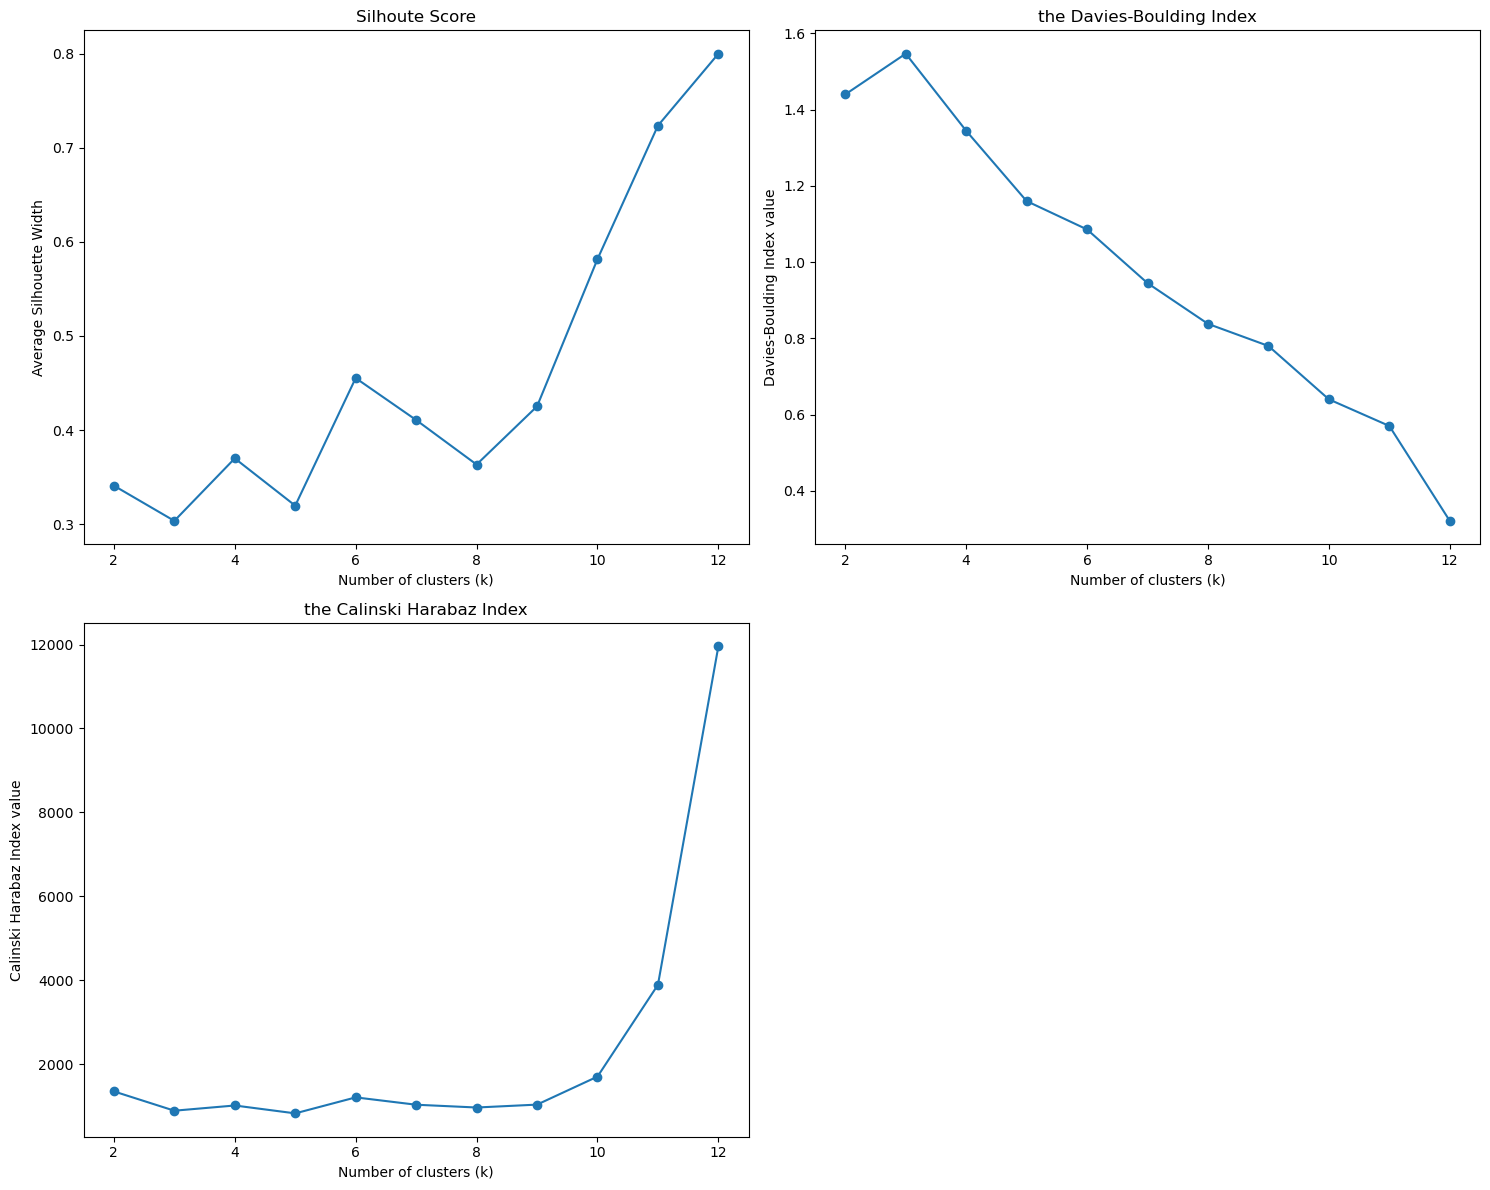

In [142]:
hier_sil(gower_matrix_4, ran = range(2,13), link = 'average')

The number of clusters is probably 12.

In [140]:
Agg_hc_a4 = AgglomerativeClustering(n_clusters = 12, affinity = 'precomputed', linkage = 'average').fit(gower_matrix_4)
#y_hc = Agg_hc.fit_predict(gower_matrix_4_weeks) # model fitting on the dataset

labels_a4 = Agg_hc_a4.labels_

#### **Summary**

Here, it doesn't matter which method we will choose, because all of them give the same results. That's why, average linkage will be chosen.

In [144]:
cluster_labels_4 = labels_c4

trial_data_hier4 = df_users_only_demo_clus4.copy()
trial_data_hier4["cluster"] = cluster_labels_4

Below there is a number of users in each cluster.

In [145]:
trial_data_hier4["cluster"].value_counts()

6     711
3     451
5     435
4     327
0     283
10    223
7     206
1     155
2     125
8      59
9      41
11     18
Name: cluster, dtype: int64

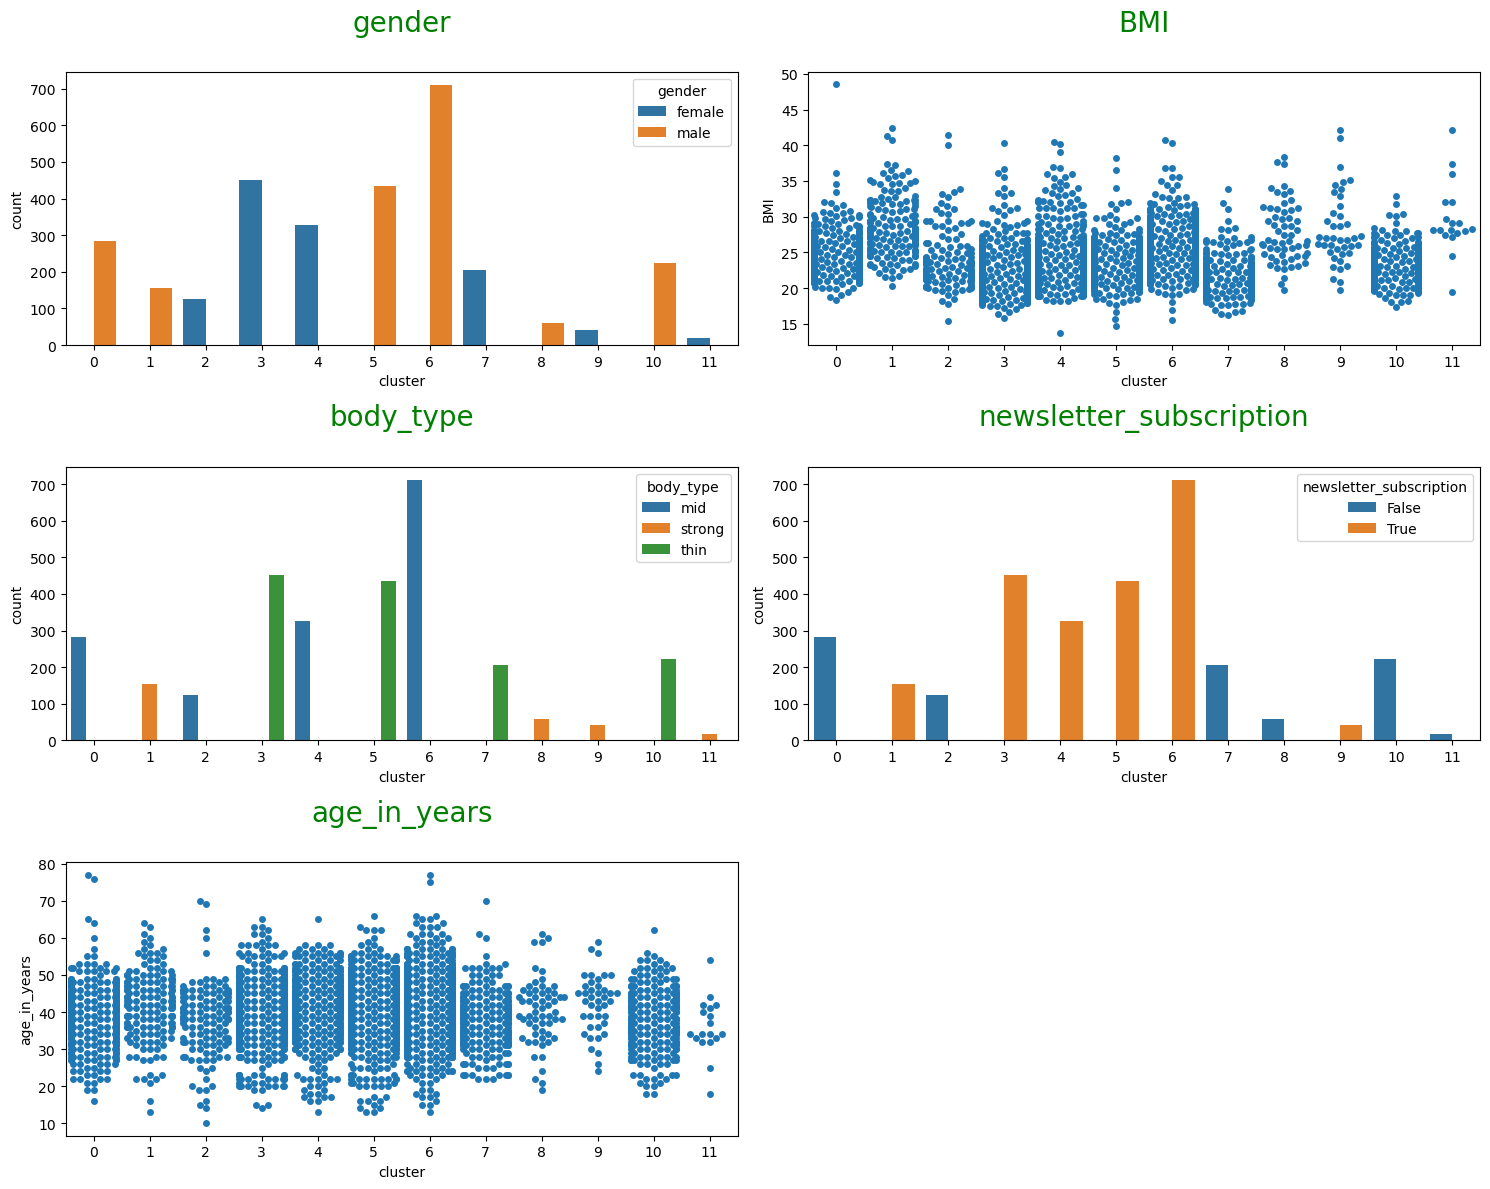

In [146]:
clus_plot(trial_data_hier4, cat_cols = ['gender', 'body_type', 'newsletter_subscription'], 
          num_cols = ['BMI', 'age_in_years'])

The description of the cluster could be as follow:

* **Cluster 0** - mid men without newsletter subscription and average BMI,
* **Cluster 1** - thin men with newsletter subscription and average BMI,
* **Cluster 2** - mid women without newsletter subscription and lower to medium BMI,
* **Cluster 3** - male with strong body type, no newsletter subscription and average to high BMI,
* **Cluster 4** - strong men with newsletter subscription and high BMI,
* **Cluster 5** - women with thin body type, newsletter subscription and low to medium BMI,
* **Cluster 6** - women with strong body type, newsletter subscription and rather average BMI,
* **Cluster 7** - women with strong body type, no newsletter subscription and rather high BMI,
* **Cluster 8** - women with mid body type, newsletter subscription and average to high BMI,
* **Cluster 9** - thin woman without newsletter subscription and low to medium BMI,
* **Cluster 10** - mid men with newsletter subscription and average to high BMI,
* **Cluster 11** - thin men without newsletter subscription and low to average BMI.

### **K-prototypes**

In [147]:
df_kpro4 = df_users_only_demo_clus_enc4.copy()

For n_clusters=2, method: Huang, the silhouette score is 0.4422
For n_clusters=2, method: Cao, the silhouette score is 0.4421
For n_clusters=3, method: Huang, the silhouette score is 0.3667
For n_clusters=3, method: Cao, the silhouette score is 0.3617
For n_clusters=4, method: Huang, the silhouette score is 0.3408
For n_clusters=4, method: Cao, the silhouette score is 0.3408
For n_clusters=5, method: Huang, the silhouette score is 0.3477
For n_clusters=5, method: Cao, the silhouette score is 0.3477
For n_clusters=6, method: Huang, the silhouette score is 0.322
For n_clusters=6, method: Cao, the silhouette score is 0.333
For n_clusters=7, method: Huang, the silhouette score is 0.3349
For n_clusters=7, method: Cao, the silhouette score is 0.3349
For n_clusters=8, method: Huang, the silhouette score is 0.306
For n_clusters=8, method: Cao, the silhouette score is 0.3058
For n_clusters=9, method: Huang, the silhouette score is 0.2945
For n_clusters=9, method: Cao, the silhouette score is 0.

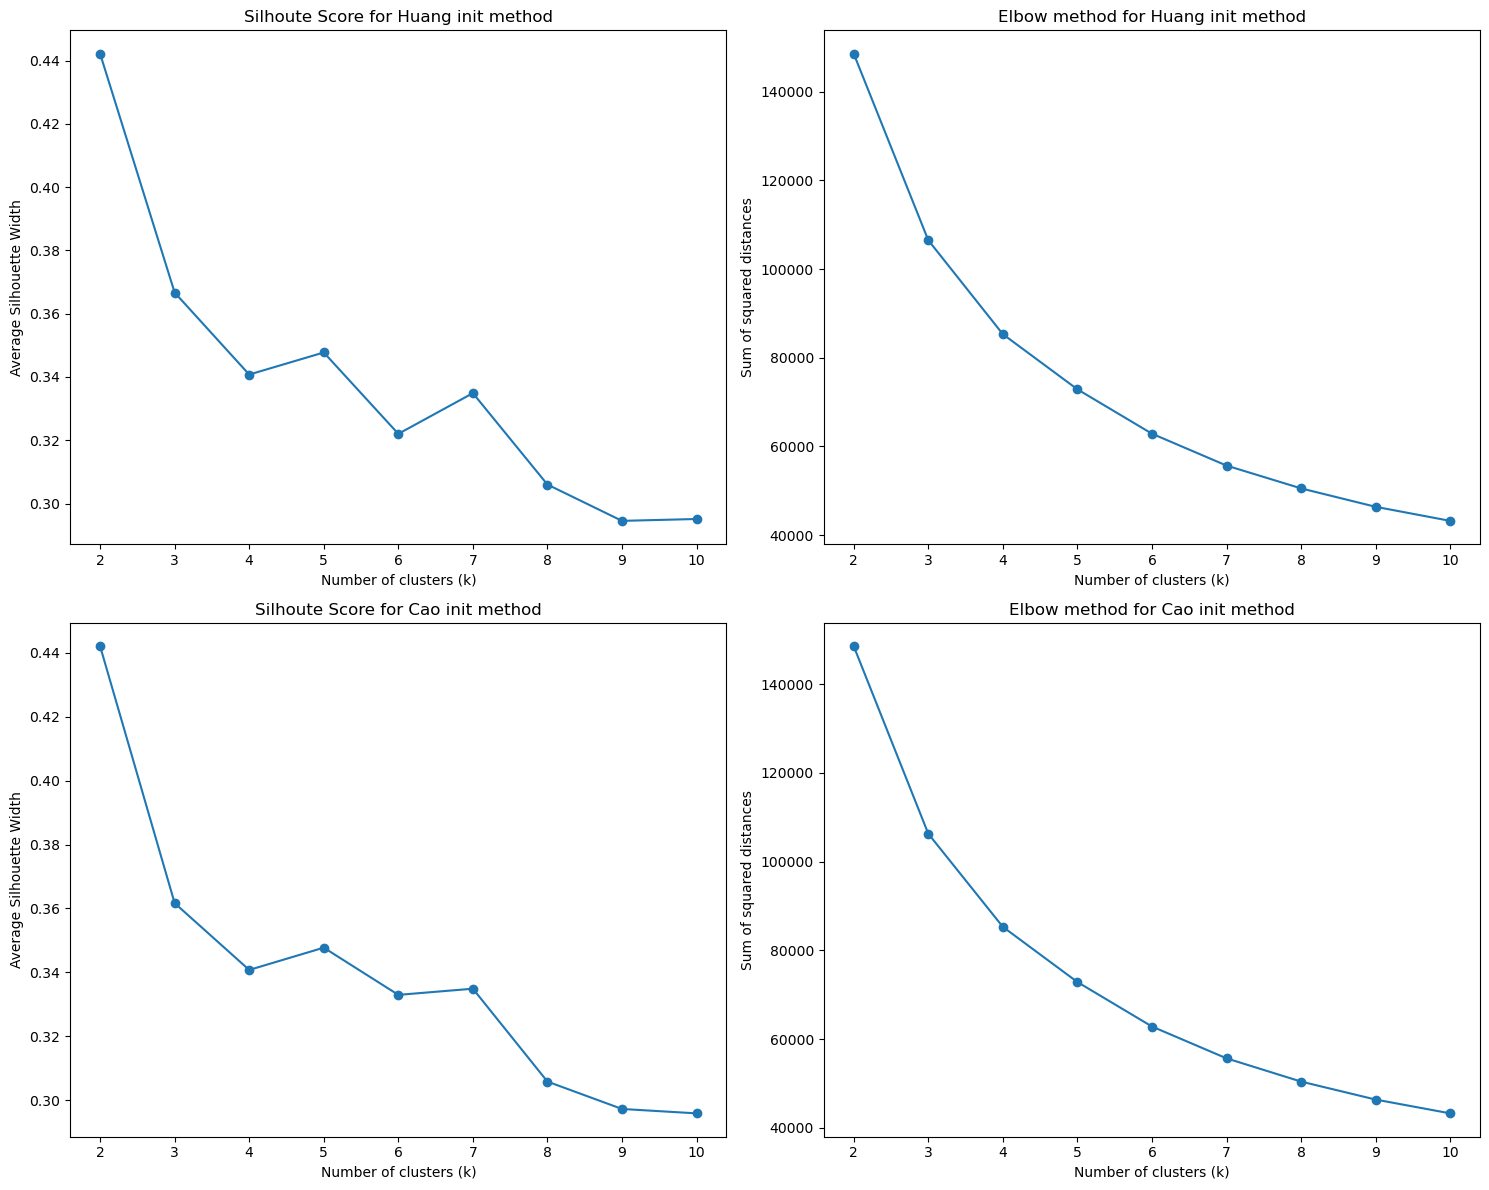

In [148]:
kpro_sil_elbow(df_kpro4, categorical_cols, ran = range(2,11))

In [161]:
kproto4 = KPrototypes(n_clusters=2, init='Huang')
clusters4 = kproto4.fit_predict(df_kpro4, categorical=[0, 2,3])

labels4 = pd.DataFrame(clusters4)
labels4.rename(columns = {0: 'cluster'}, inplace = True)

df_kpro4.reset_index(inplace = True, drop = True)

labeled_data4 = pd.concat((df_users_only_demo_clus4.reset_index(drop = True), labels4),axis=1)

In [162]:
davies_bouldin_score(df_kpro4, labeled_data4['cluster'])

0.8140685621315855

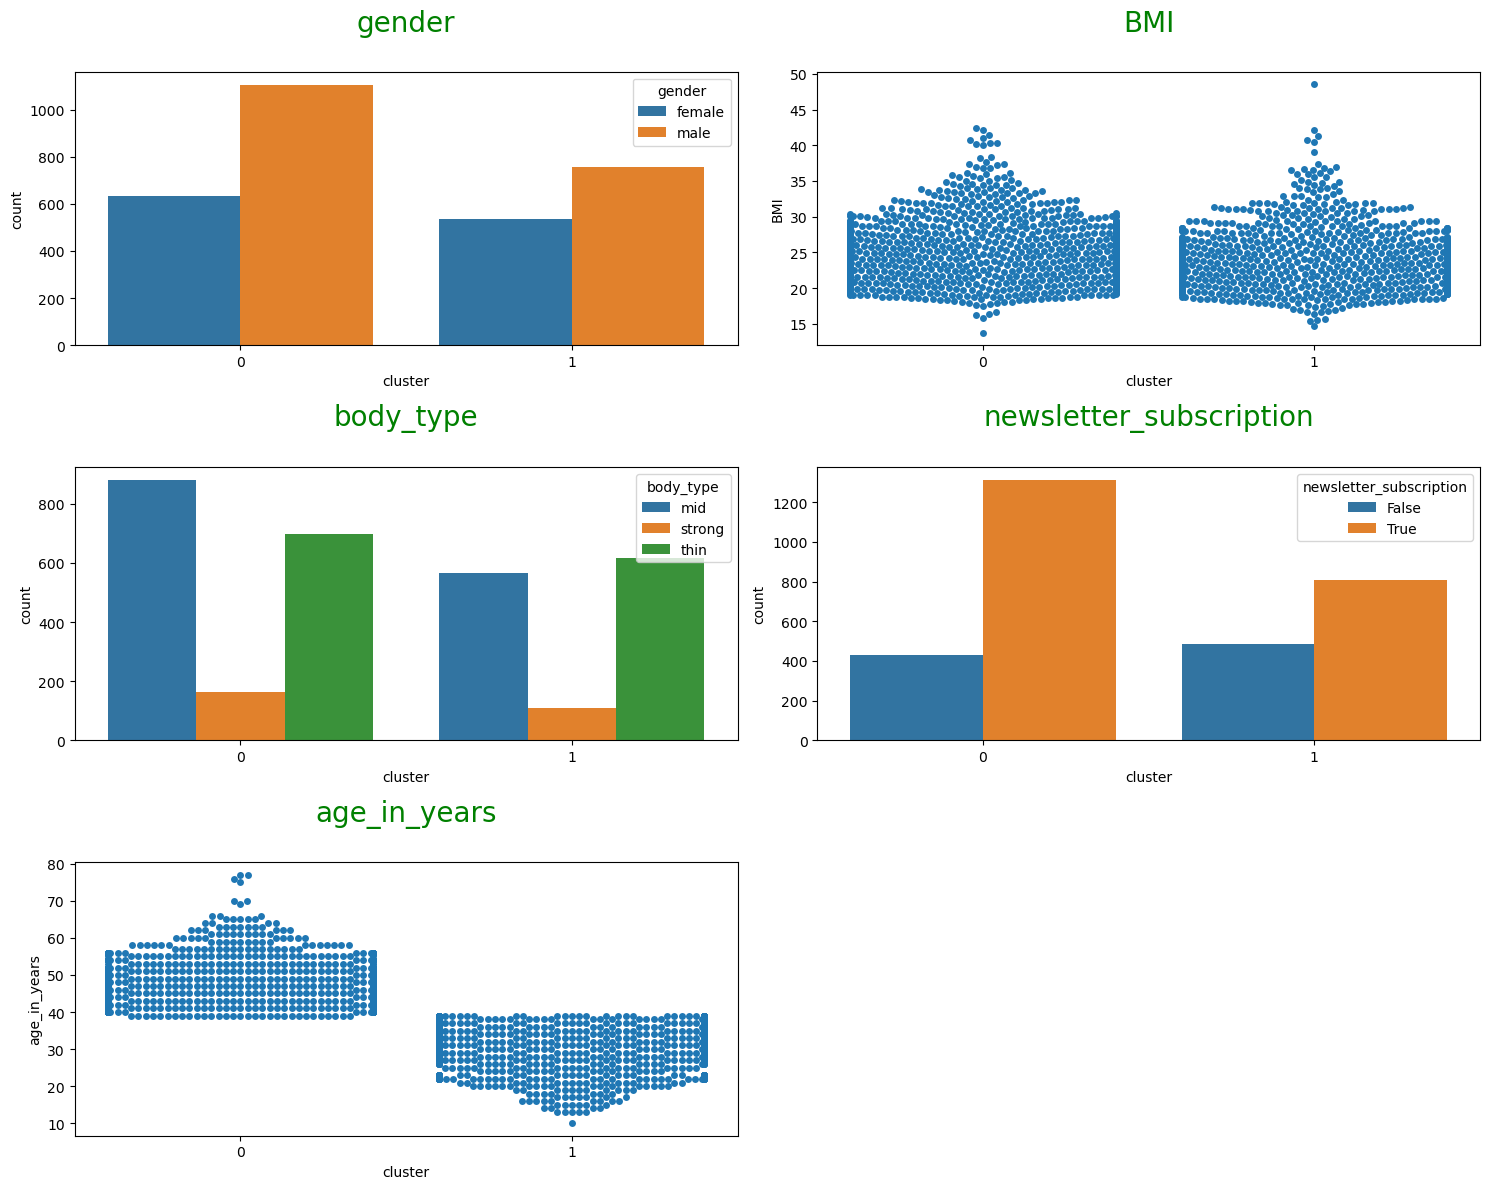

In [163]:
clus_plot(labeled_data4, cat_cols = categorical_cols, 
          num_cols = ['BMI', 'age_in_years'])

The description of the cluster could be as follow:

* **Cluster 0** - mostly mid men, mostly with newsletter subscription and average to high BMI,
* **Cluster 1** - thin and mid men and women, mostly with newsletter subscription and low to average BMI.

#### **Scaled data**

In [149]:
df_kpro_sca4 = df_kpro4.copy()

numerical_columns4 = ['BMI']

scaler = StandardScaler()

# standard scale numerical features
for c in numerical_columns4:
    df_kpro_sca4[c] = scaler.fit_transform(df_kpro_sca4[[c]])

Again, we check hopkins score, it is better than before.

In [150]:
hopkins(df_kpro_sca4)

0.9773796994357181

For n_clusters=2, method: Huang, the silhouette score is 0.2675
For n_clusters=2, method: Cao, the silhouette score is 0.2684
For n_clusters=3, method: Huang, the silhouette score is 0.2493
For n_clusters=3, method: Cao, the silhouette score is 0.2493
For n_clusters=4, method: Huang, the silhouette score is 0.1998
For n_clusters=4, method: Cao, the silhouette score is 0.209
For n_clusters=5, method: Huang, the silhouette score is 0.2445
For n_clusters=5, method: Cao, the silhouette score is 0.2447
For n_clusters=6, method: Huang, the silhouette score is 0.2399
For n_clusters=6, method: Cao, the silhouette score is 0.2583
For n_clusters=7, method: Huang, the silhouette score is 0.2495
For n_clusters=7, method: Cao, the silhouette score is 0.2681
For n_clusters=8, method: Huang, the silhouette score is 0.1959
For n_clusters=8, method: Cao, the silhouette score is 0.2545
For n_clusters=9, method: Huang, the silhouette score is 0.2737
For n_clusters=9, method: Cao, the silhouette score is 

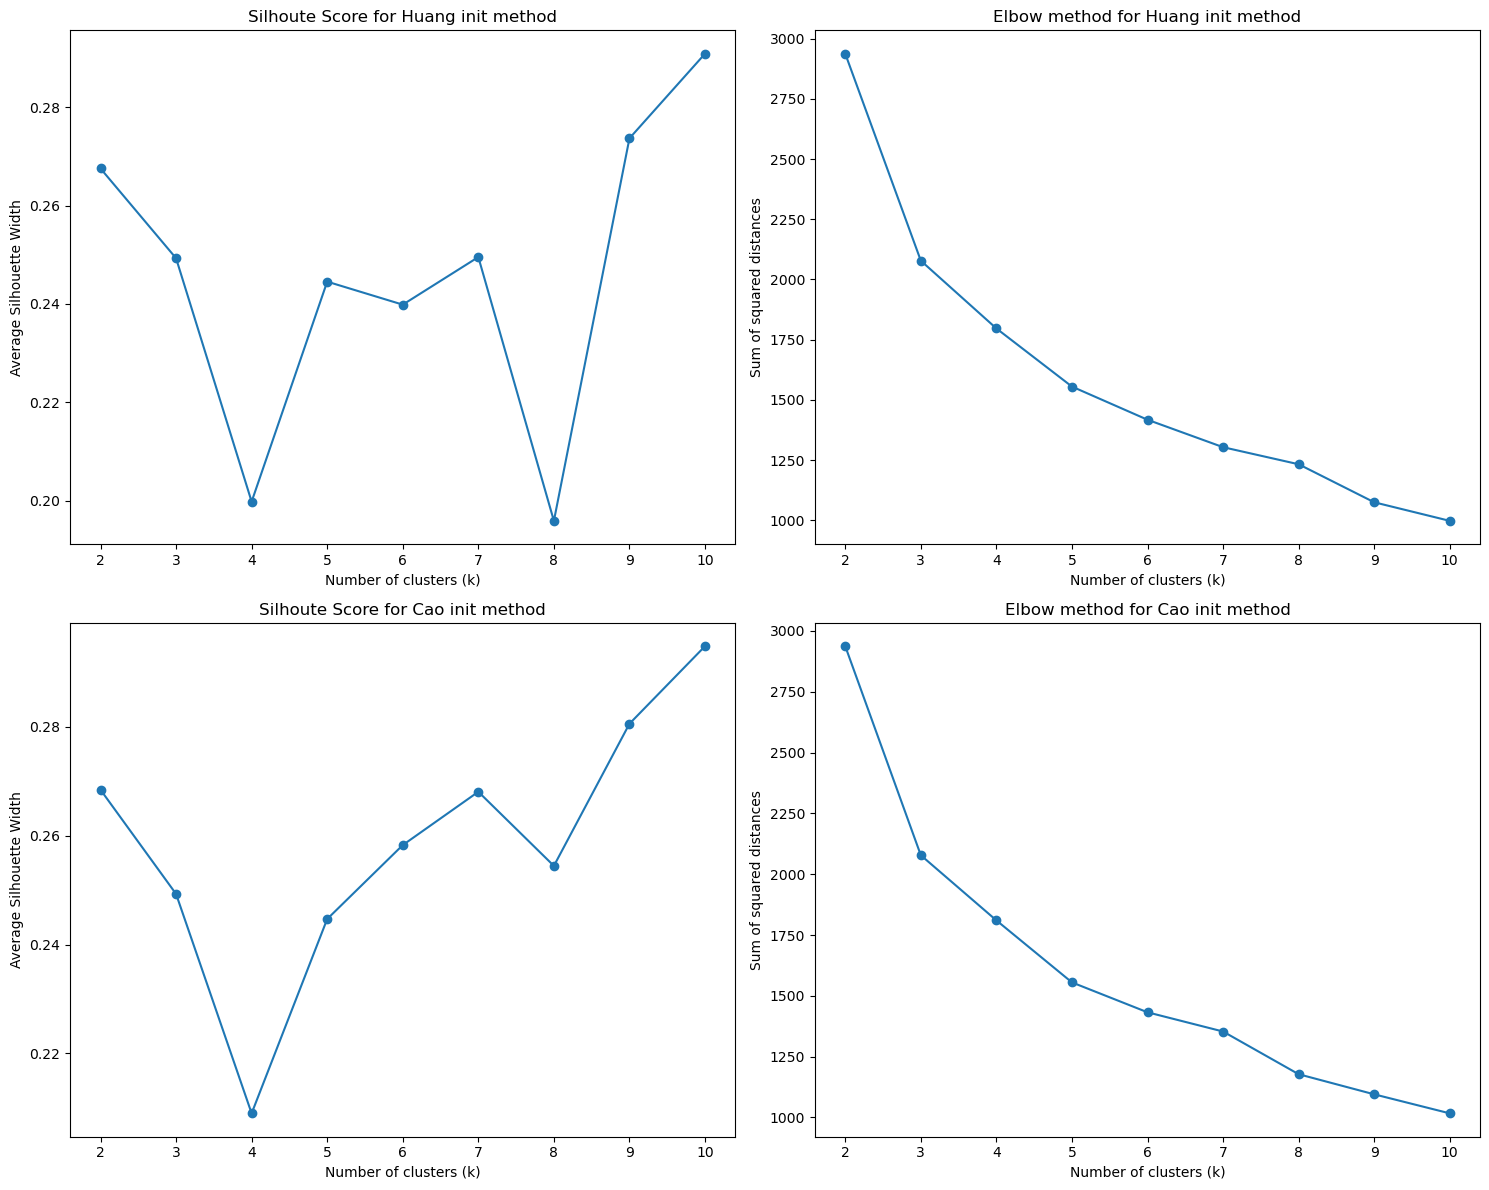

In [151]:
kpro_sil_elbow(df_kpro_sca4, categorical_cols, ran = range(2,11))

The probable number of clusters is 2, but the silhouette score is pretty low, so the clusterization won't be too good.

In [152]:
kproto_sca4 = KPrototypes(n_clusters=2, init='Huang')
clusters_sca4 = kproto_sca4.fit_predict(df_kpro_sca4, categorical=[0, 2,3])

labels_sca4 = pd.DataFrame(clusters_sca4)
labels_sca4.rename(columns = {0: 'cluster'}, inplace = True)

labeled_data_sca4 = pd.concat((df_users_only_demo_clus4.reset_index(drop = True),labels_sca4),axis=1)

labeled_data_sca4['cluster'].value_counts()

1    2018
0    1016
Name: cluster, dtype: int64

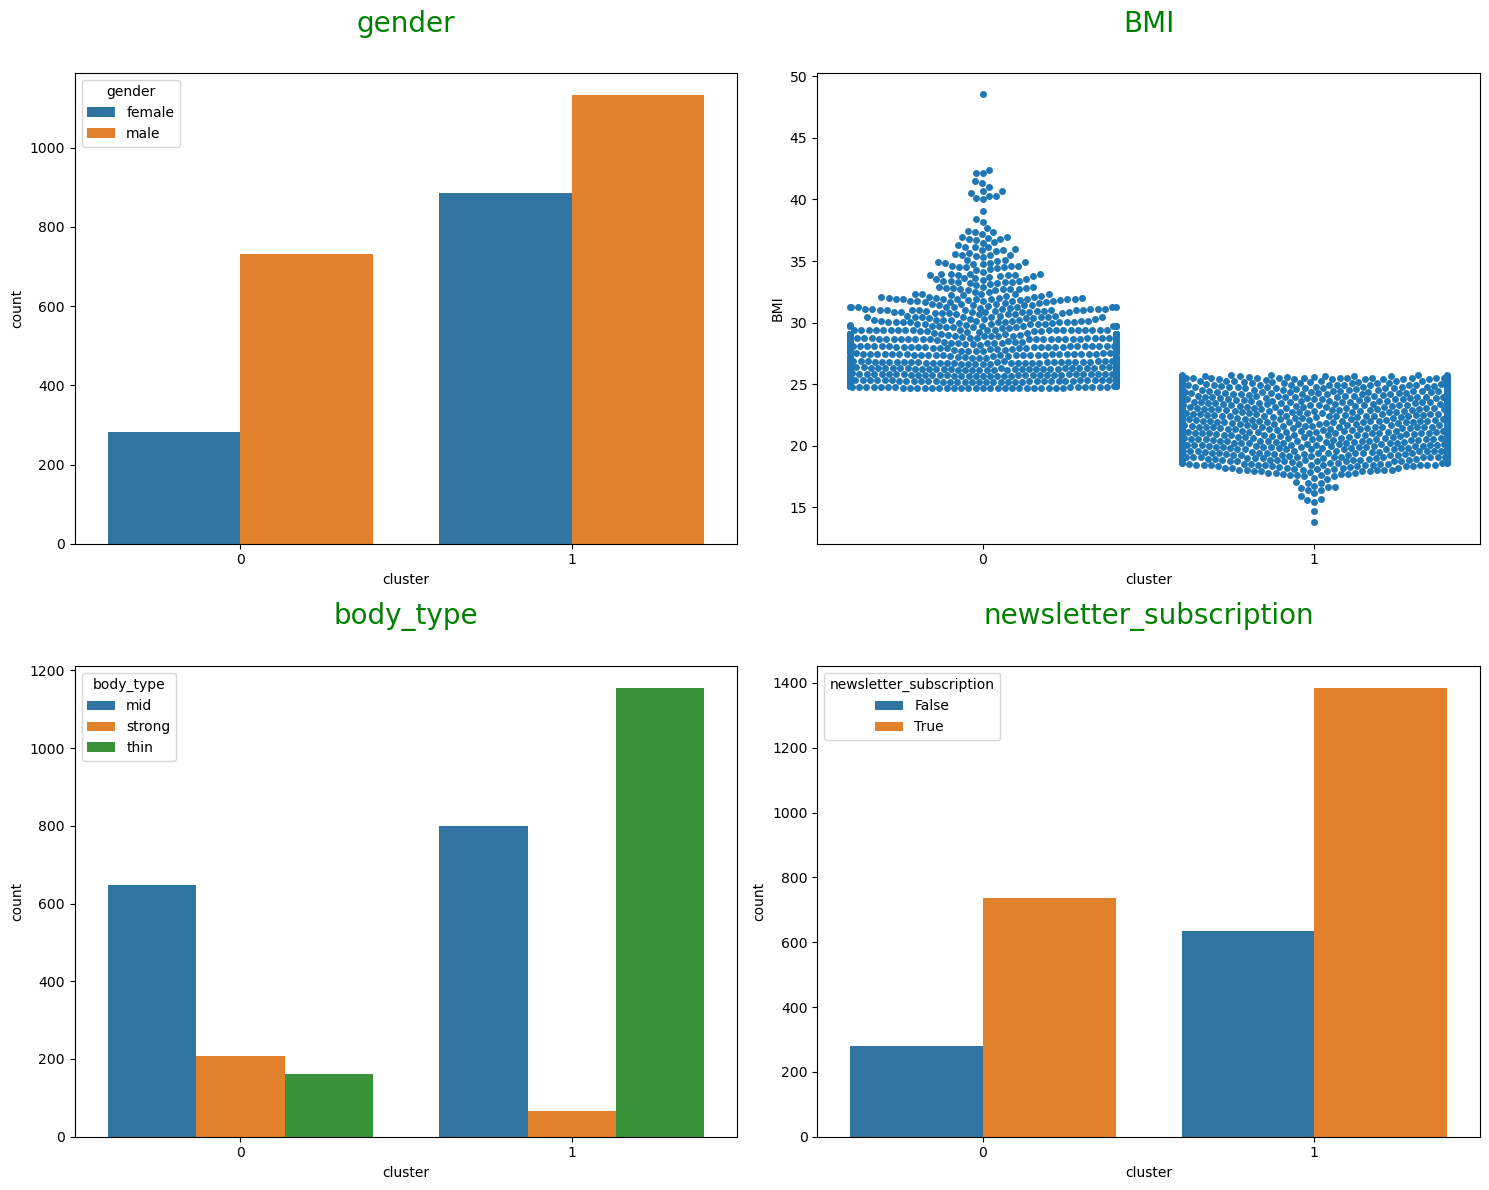

In [153]:
clus_plot(labeled_data_sca4, cat_cols = ['gender', 'body_type', 'newsletter_subscription'], 
          num_cols = ['BMI'])

The description of the cluster could be as follow:

* **Cluster 0** - mostly men with mostly mid body type, newsletter subscription and average to high BMI,
* **Cluster 1** - mostly thin and mid men and women mostly with newsletter subscription and low to average BMI.

### **Summary**

In [164]:
# data into summary table
data4 = {'Name of algorithm' : ['PAM', 'hierarchial clustering (average linkage)', 
                               'K-prototypes'],
        'Number of clusters (k)' : [12, 12, 2],
        'Silhouette score' : [silhouette_score(gower_matrix_4, trial_data4['cluster']),
                              silhouette_score(gower_matrix_4, trial_data_hier4["cluster"]),
                              silhouette_score(df_kpro4, labeled_data4["cluster"])
                              ],
        'Calinski Harabaz Index' : [calinski_harabasz_score(gower_matrix_4, trial_data4['cluster']),
                                    calinski_harabasz_score(gower_matrix_4, trial_data_hier4["cluster"]),
                                    calinski_harabasz_score(df_kpro4, labeled_data4["cluster"])
                                   ],
        'Davies Bouldin Index' : [davies_bouldin_score(gower_matrix_4, trial_data4['cluster']),
                                  davies_bouldin_score(gower_matrix_4, trial_data_hier4["cluster"]),
                                  davies_bouldin_score(df_kpro4, labeled_data4["cluster"])
                                 ]}

In [165]:
summary_tab4 = pd.DataFrame(data4)
summary_tab4.set_index(['Name of algorithm'], inplace = True)

In [166]:
summary_tab4

Number of clusters (k)  \
Name of algorithm                                                  
PAM                                                           12   
hierarchial clustering (average linkage)                      12   
K-prototypes                                                   2   

                                          Silhouette score  \
Name of algorithm                                            
PAM                                                   0.80   
hierarchial clustering (average linkage)              0.80   
K-prototypes                                          0.44   

                                          Calinski Harabaz Index  \
Name of algorithm                                                  
PAM                                                     10093.41   
hierarchial clustering (average linkage)                11960.83   
K-prototypes                                             3331.27   

                                          Davies Bouldin Index  
Name of algorithm                                               
PAM                                                       0.45  
hierarchial clustering (average linkage)                  0.32  
K-prototypes                                              0.81

Here the best are PAM and hierarchical and they have the same scores.